# Desafio - Clustering
# Segmentação de Clientes

### Proposto por Gustavo Pilatti (iFood)
### Resolução por Daniel Jullien

## Índice
* [Introdução](#introduction)
* [Metodologia](#methodology)
* [Aquisição de Dados](#data)
* [Limpeza dos Dados](#cleaning)
* [Análise Exploratória Inicial](#eda)
* [Feature Engineering](#featureengineering)
* [Análise Exploratória Final](#finaleda)
* [Redução de Dimensionalidade](#reducao_dimensionalidade)
* [Segmentação](#clustering)
* [Resultados](#results)
* [Conclusão](#conclusao)

## 1. Introdução <a name="introduction"></a>

## Base de dados 

## 2. Metodologia<a name="methodology"></a>

## 3. Aquisição de Dados<a name="data"></a>

Importaremos as bibliotecas utilizadas.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas para tratamento de dados
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

pd.set_option('display.max_columns', None)

# Bibliotecas para visualização
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
import folium

# Bibliotecas processamento
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler

# Redução de dimensionalidade
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Clustering Models
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.cluster.vq import whiten
from sklearn.cluster import KMeans, estimate_bandwidth, MeanShift, DBSCAN
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from kneed import KneeLocator

from tqdm import tqdm


In [2]:
biblioteca = pd.read_excel('Documentação Base - Clustering.xlsx')
mkt_raw = pd.read_csv('Marketing.xls', sep=';')
orders_raw = pd.read_csv('Orders.xls', sep=';')
sessions_raw = pd.read_csv('sessions.xls', sep=';')

In [3]:
biblioteca

,Nome da base,Nome da variável,Descrição
0,orders,order_id,ID único para pedido
1,orders,order_shift,0 - 4:59h - weekday/weekend dawn\n5 - 9:59h - ...
2,orders,order_origin,"Tipo do Merchant: STORE (loja), QUICKLY_MEAL (..."
3,orders,delivery_fee,Taxa de entrega paga pelo cliente
4,orders,scheduled,Booleano que indica se o pedido foi agendado
5,orders,total_amount,Valor total pago pelo cliente (em Unidades Mon...
6,orders,subsidy_amount,"Subsídio, desconto dado no pedido (em Unidades..."
7,orders,device_platform,Plataforma (sistema operacional) utilizado par...
8,orders,device_type,"Canal de origem do pedido (SITE, MOBILE, etc)"
9,orders,device_app_version,Versão do aplicativo do iFood que fez o pedido


In [4]:
mkt_raw.head()

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19
2,61c051ee-d37c-45c6-8c22-c236db3b62b7,2018-09-02,Active,Active,206,2018-09-02
3,82e48692-e4fa-494e-b03e-6815a819b7b1,2017-11-10,Reactivated,Churn,47,2018-05-01
4,382af025-14c8-4ba9-b62f-deddd6f25789,2019-08-05,Inactive,Inactive,66,2019-08-12


In [5]:
mkt_raw.shape

(20249, 6)

In [6]:
sessions_raw.head()

,session_id,user_account_uuid,session_started,session_ended,install_timestamp,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,first_order_has_voucher,media_campaign,load_time,available_restaurants,rownumber
0,0a364c77-4375-4334-8f64-a06bdd22229c,5a2fbdea-e2ee-41a5-b47c-41fbebdc78ef,2020-02-01T00:00:03.924Z,2020-02-01T00:10:51.217Z,NaN,19,5,6,6,7,False,NaN,5.0,462.0,1
1,b01811cd-ad2c-42f1-bccf-b90698ccc7a8,20cb43a7-c90d-4451-b067-e1b934746de6,2020-02-01T00:00:09.616Z,2020-02-01T00:14:22.713Z,NaN,14,1,0,0,0,NaN,NaN,5.0,128.0,2
2,aa453bd1-da47-4cfa-9ce7-a7e2c9227dec,b6bd9094-c2f0-471c-b6ec-9475d8d0591b,2020-02-01T00:00:14.479Z,2020-02-01T00:08:20.102Z,NaN,31,4,4,3,1,False,NaN,6.0,187.0,3
3,39ca6d98-c9d1-4dff-9158-c7416be6d309,d7ddb2ac-31bf-4e3d-848a-9efc86a70f6d,2020-02-01T00:00:14.650Z,2020-02-01T00:02:49.615Z,NaN,12,3,0,0,0,NaN,NaN,5.0,22.0,4
4,cf456658-0426-46c2-b6c1-fc27c186e15e,8d9bb514-cc57-4181-bb9d-b94b7fbbfd98,2020-02-01T00:00:41.607Z,2020-02-01T00:16:57.415Z,NaN,4,0,0,0,0,NaN,NaN,28.0,3.0,5


In [7]:
sessions_raw.shape

(3591511, 15)

In [8]:
orders_raw.head()

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,875.0,False,5375.0,0.00,ANDROID,MOBILE,9.39.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,83c3e069dbd7267a7565a16b879cd968c0968a27ac16e6...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.38,RJ,RIO DE JANEIRO,PAVUNA,21650420,-43.38,-22.83,False,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8,2020-02-28T19:06:31.861Z
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,weekend dinner,RESTAURANT,0.0,False,2987.5,1250.00,IOS,MOBILE,9.63.0,-22.93-43.18,RJ,RIO DE JANEIRO,FLAMENGO,-43.18,-22.94,2531d200d387f462ed6e096086723c43b48de9b6c3ec05...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.93-43.21,RJ,RIO DE JANEIRO,Rio Comprido,20261170,-43.22,-22.93,True,2020-08-21T21:12:23.295Z,2020-08-21T21:59:18.732Z,1.0,407bab9f-f485-48cd-abea-66e6283058c3,5.0,8,2020-09-04T00:14:14.365Z
2,00214248-5a2d-4333-a919-c1f3afd31389,weekday dinner,RESTAURANT,0.0,False,3737.5,2123.75,IOS,MOBILE,9.56.0,-23.6-46.64,SP,SAO PAULO,Vila Clementino,-46.65,-23.60,e648c3eeabfbbc52d415e4f2b4bb07ed0206c7fff7fb9c...,Comida Peruana,5384e3b557315ce815e7e3425a4d067f1ecff96978501e...,-23.61-46.67,SP,SAO PAULO,INDIANOPOLIS,4029200,-46.67,-23.62,True,2020-07-02T20:21:51.900Z,2020-07-02T20:53:39.176Z,3.0,a16865d2-a3ca-4251-afab-083dadeb06e9,5.0,5,2020-07-03T03:49:03.214Z
3,007199e6-6be4-42d0-986c-a0de7650dc80,weekday dinner,RESTAURANT,862.5,False,2237.5,1.25,DESKTOP,SITE,8.39.0,-22.96-43.39,RJ,RIO DE JANEIRO,Curicica,-43.39,-22.96,c3b2f2bc35b781c126ab4e78db73aa5609e55b1eff34c8...,Pizza,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.96-43.4,RJ,RIO DE JANEIRO,Curicica,22780193,-43.40,-22.96,False,2020-08-19T20:16:16.718Z,2020-08-19T22:16:16.298Z,0.0,a7f00fd8-d5d6-4604-9bce-ffe35b16848d,5.0,10,2020-08-26T17:44:08.137Z
4,00bb6d10-0a9b-4fe3-9b25-8d18f50bcc3a,weekday lunch,RESTAURANT,0.0,False,2750.0,0.00,DESKTOP,SITE,8.12.0,-23.57-46.64,SP,SAO PAULO,Liberdade,-46.64,-23.57,63271292b131c157593c309acfcbcd5756ec1440879e64...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.59-46.64,SP,SAO PAULO,Vila Mariana,4009002,-46.64,-23.59,True,2020-04-15T13:01:55.231Z,2020-04-15T17:02:37.723Z,1.0,63284037-3ade-4600-88e9-5009b9504d8f,5.0,10,2020-04-17T22:05:13.983Z


In [9]:
orders_raw.shape

(226269, 34)

## 4. Limpeza dos Dados <a name="cleaning"></a>

Nesta etapa será feita uma limpeza dos dados para possibilitar uma boa EDA, na qual serão realizas as seguintes etapas:
- Avaliação do tipo do dado e transformação se necessário
- Verificação de dados duplicados
- Preenchimento dos dados nulos, quando possível
- Correção de dados incorretos
  
  Para facilitar a análise dos dados nulos, a função abaixo será utilizada.

In [10]:
def find_missing(data):
    '''
    Função para identificar e listar as variáveis com valores faltantes
    '''
    miss_df = pd.DataFrame({'ColumnName':[],'TotalMissing':[],'PercentMissing':[]})
    for col in data.columns:
        sum_miss_val = data[col].isna().sum()
        percent_miss_val = round((sum_miss_val/data.shape[0])*100,2)
        miss_df = miss_df.append(dict(zip(miss_df.columns,[col,sum_miss_val,percent_miss_val])), ignore_index=True)
        miss_df = miss_df[miss_df['TotalMissing']>0].sort_values('TotalMissing', ascending=False)
    return miss_df

#### Marketing

In [11]:
mkt_clean = mkt_raw.copy()

In [12]:
mkt_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   account_id               20249 non-null  object
 1   registration_date        20249 non-null  object
 2   ifood_status             20249 non-null  object
 3   ifood_status_last_month  20249 non-null  object
 4   total_order_count        20249 non-null  int64 
 5   first_order_date         20248 non-null  object
dtypes: int64(1), object(5)
memory usage: 949.3+ KB


In [13]:
mkt_clean.head(2)

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19


As informações de data, que apresentam apenas o dia, mês e ano, serão transformados em datetime.

In [14]:
mkt_clean['registration_date'] =  pd.to_datetime(mkt_clean['registration_date'])
mkt_clean['first_order_date'] =  pd.to_datetime(mkt_clean['first_order_date'])

In [15]:
mkt_clean.duplicated().sum()

0

In [16]:
find_missing(mkt_clean)

,ColumnName,TotalMissing,PercentMissing
0,first_order_date,1.0,0.0


Existe um dado faltando para a data de primeiro pedido.

In [17]:
mkt_clean[mkt_clean['first_order_date'].isna()==True]

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
11568,7745ad02-1ff9-45be-9227-a9306857cdcb,2019-05-05,Prospect,Prospect,0,NaT


Interessante observar que o número total de pedidos para ele é zero, assim, parece ser um usuário que nunca realizou um pedido no iFood, o que é condizente não haver uma data de primeiro pedidos. Vamos investigar se há outros usuários com 0 pedidos e se realmente não existem pedidos realizados na base `orders`.

In [18]:
mkt_clean[mkt_clean['total_order_count']==0]

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
11568,7745ad02-1ff9-45be-9227-a9306857cdcb,2019-05-05,Prospect,Prospect,0,NaT


In [19]:
orders_raw[orders_raw['account_id']=='7745ad02-1ff9-45be-9227-a9306857cdcb']

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at
131143,fa810bc0-4a63-446f-8307-fc2f6d61a48f,weekend dinner,RESTAURANT,0.0,False,2000.0,7362.5,IOS,MOBILE,9.36.1,-23.56-46.63,SP,SAO PAULO,Cambuci,-46.63,-23.57,f820bbcc535afe1286f7a00558a8536b01ee6536d35a05...,Comida Árabe,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.55-46.66,SP,SAO PAULO,Consolação,1304001,-46.66,-23.56,True,2020-02-01T20:39:40.572Z,2020-02-01T22:40:28.268Z,NaN,7745ad02-1ff9-45be-9227-a9306857cdcb,1.0,1,2020-02-01T23:31:26.895Z


Na realidade o usuário realizou um pedido, logo, a informação será corrigida. Além disso, ele não se encaixa em 'Prospect', mas em 'Active'.

In [20]:
mkt_clean.loc[11568,['total_order_count']]=1
mkt_clean.loc[11568,['first_order_date']]=pd.to_datetime('2020-02-01')
mkt_clean.loc[11568,['ifood_status']]='Active'

In [21]:
mkt_clean.loc[11568]

account_id                 7745ad02-1ff9-45be-9227-a9306857cdcb
registration_date                           2019-05-05 00:00:00
ifood_status                                             Active
ifood_status_last_month                                Prospect
total_order_count                                             1
first_order_date                            2020-02-01 00:00:00
Name: 11568, dtype: object

In [22]:
mkt_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   account_id               20249 non-null  object        
 1   registration_date        20249 non-null  datetime64[ns]
 2   ifood_status             20249 non-null  object        
 3   ifood_status_last_month  20249 non-null  object        
 4   total_order_count        20249 non-null  int64         
 5   first_order_date         20249 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 949.3+ KB


#### Orders

In [23]:
orders_clean = orders_raw.copy()

In [24]:
orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              226269 non-null  object 
 1   order_shift           226269 non-null  object 
 2   order_origin          226269 non-null  object 
 3   delivery_fee          226269 non-null  float64
 4   scheduled             226269 non-null  bool   
 5   total_amount          226269 non-null  float64
 6   subsidy_amount        226269 non-null  float64
 7   device_platform       226269 non-null  object 
 8   device_type           226269 non-null  object 
 9   device_app_version    221834 non-null  object 
 10  centroid_id           226269 non-null  object 
 11  state_label           226269 non-null  object 
 12  city                  226269 non-null  object 
 13  district              226269 non-null  object 
 14  customer_long         226269 non-null  float64
 15  

In [25]:
orders_clean.head(2)

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,875.0,False,5375.0,0.0,ANDROID,MOBILE,9.39.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,83c3e069dbd7267a7565a16b879cd968c0968a27ac16e6...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.38,RJ,RIO DE JANEIRO,PAVUNA,21650420,-43.38,-22.83,False,2020-02-28T14:07:25.953Z,2020-02-28T16:06:03.701Z,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8,2020-02-28T19:06:31.861Z
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,weekend dinner,RESTAURANT,0.0,False,2987.5,1250.0,IOS,MOBILE,9.63.0,-22.93-43.18,RJ,RIO DE JANEIRO,FLAMENGO,-43.18,-22.94,2531d200d387f462ed6e096086723c43b48de9b6c3ec05...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.93-43.21,RJ,RIO DE JANEIRO,Rio Comprido,20261170,-43.22,-22.93,True,2020-08-21T21:12:23.295Z,2020-08-21T21:59:18.732Z,1.0,407bab9f-f485-48cd-abea-66e6283058c3,5.0,8,2020-09-04T00:14:14.365Z


Primeiramente converteremos em datetime as informações de data: `confirmed_date`, `concluded_date` e `review_created_at`.

In [26]:
orders_clean['confirmed_date'] = pd.to_datetime(orders_clean['confirmed_date'])
orders_clean['concluded_date'] = pd.to_datetime(orders_clean['concluded_date'])
orders_clean['review_created_at'] = pd.to_datetime(orders_clean['review_created_at'])

In [27]:
orders_clean.duplicated().sum()

0

In [28]:
find_missing(orders_clean)

,ColumnName,TotalMissing,PercentMissing
0,device_app_version,4435.0,1.96
1,lag_last_order,184.0,0.08
2,confirmed_date,14.0,0.01
3,concluded_date,4.0,0.00


A feature com maior quantidade de dados faltando é a versão do aplicativo no aparelho (`device_app_version`). Vamos investigar se há alguma forma de imputar tal informação utilizando as outras features do aparelho.

In [29]:
orders_clean[orders_clean['device_app_version'].isna()][['device_platform', 'device_type']].describe(include='object')

,device_platform,device_type
count,4435,4435
unique,3,2
top,DESKTOP,SITE
freq,4389,4430


Das 4435 features faltando, 4430 foram feitas em SITE e 4389 em um DESKTOP. Assim, utilizaremos a moda da versão deste caso para imputar a informação faltante.

In [30]:
orders_clean[(orders_clean['device_type']=='SITE') & 
             (orders_clean['device_platform']=='DESKTOP')][['device_app_version']].describe(include='object')

,device_app_version
count,18692
unique,70
top,8.12.0
freq,1685


In [31]:
orders_clean['device_app_version'].fillna('8.12.0', inplace=True)

In [32]:
orders_clean[orders_clean['lag_last_order'].isna()][['account_id', 'confirmed_date']].sort_values('account_id')

,account_id,confirmed_date
108864,02594d95-7405-4b9d-85af-399f5c63a61a,2020-02-02 20:59:57.642000+00:00
212991,028c2dcc-6b40-4fff-8f24-a42714feaffb,2020-02-09 13:56:50.335000+00:00
84222,03222bbe-495f-4084-9cb3-d7e0e9ba377b,2020-02-16 02:33:36.912000+00:00
180477,034db963-d2f5-402f-b2ad-dc5e8fa1f362,2020-02-02 16:26:50.631000+00:00
129033,040ecff5-db09-45f0-b1ed-14b7cc0c6ebf,2020-02-08 20:47:01.271000+00:00
...,...,...
182228,f49b3d72-c5db-4971-a27b-3fcb36b1e21a,2020-02-13 12:17:10.871000+00:00
172510,f6d3009b-76ee-405c-a67b-de61a9de8a8a,2020-02-28 21:18:40.807000+00:00
154064,fa6b58f6-2401-4821-9f5e-cdc565a09e1c,2020-02-20 14:19:44.429000+00:00
129278,fccc0560-287f-46fa-aad2-b62bc0914697,2020-02-29 20:15:01.407000+00:00


In [33]:
mkt_clean[mkt_clean['account_id'].isin(
    orders_clean[orders_clean['lag_last_order'].isna()]['account_id'].to_list())].sort_values('account_id')

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
9369,02594d95-7405-4b9d-85af-399f5c63a61a,2020-01-25,Inactive,Inactive,1,2020-02-02
377,028c2dcc-6b40-4fff-8f24-a42714feaffb,2020-01-31,Inactive,Inactive,1,2020-02-09
16005,03222bbe-495f-4084-9cb3-d7e0e9ba377b,2020-02-16,Inactive,Inactive,1,2020-02-16
3296,034db963-d2f5-402f-b2ad-dc5e8fa1f362,2020-02-02,Churn,Active,93,2020-02-02
12552,040ecff5-db09-45f0-b1ed-14b7cc0c6ebf,2020-02-08,Inactive,Inactive,10,2020-02-08
...,...,...,...,...,...,...
19720,f49b3d72-c5db-4971-a27b-3fcb36b1e21a,2019-11-19,Inactive,Inactive,8,2020-02-13
5512,f6d3009b-76ee-405c-a67b-de61a9de8a8a,2020-02-29,Inactive,Inactive,2,2020-02-28
15976,fa6b58f6-2401-4821-9f5e-cdc565a09e1c,2020-02-20,Churn,Active,3,2020-02-20
7084,fccc0560-287f-46fa-aad2-b62bc0914697,2020-02-23,Churn,Reactivated,7,2020-02-29


A `first_order_date` bate com a `confirmed_date`, assim, a `lag_last_order` é inexistente uma vez que esta era a primeira compra do cliente, não havendo uma compra anterior para comparação. Vamos imputar o valor de -1, para diferenciá-los do restante das observações.

In [34]:
orders_clean['lag_last_order'].fillna(-1, inplace=True)

Por fim, veremos qual a melhor forma de imputar a informação faltando de `confirmed_date` e `concluded_date`.

In [35]:
orders_clean[orders_clean['confirmed_date'].isna()][['order_shift','confirmed_date', 'concluded_date', 'dish_type']]

,order_shift,confirmed_date,concluded_date,dish_type
14218,weekday lunch,NaT,2020-02-18 18:31:31.464000+00:00,Comida Brasileira
27814,weekday lunch,NaT,2020-02-18 18:33:34.004000+00:00,Comida Brasileira
32263,weekday lunch,NaT,2020-02-18 18:34:33.993000+00:00,Comida Saudável
81774,weekday lunch,NaT,2020-02-18 12:54:15.820000+00:00,Comida Brasileira
99762,weekday lunch,NaT,2020-02-18 12:42:37.912000+00:00,Lanches
100774,weekday lunch,NaT,2020-02-18 18:31:31.309000+00:00,Comida Brasileira
102572,weekday lunch,NaT,2020-02-18 18:36:29.340000+00:00,Açaí
112282,weekday lunch,NaT,2020-02-18 18:36:40.085000+00:00,Comida Brasileira
117261,weekday lunch,NaT,2020-02-18 18:36:29.254000+00:00,Comida Brasileira
143533,weekday lunch,NaT,2020-02-18 18:36:30.491000+00:00,Lanches


Uma vez que todos são 'weekday lunch', usaremos a moda do horário de confirmação do pedido realizado no almoço para imputar a informação incompleta.

In [36]:
orders_clean[orders_clean['order_shift']=='weekend lunch']['confirmed_date'].apply(lambda x: x.hour).median()

12.0

In [37]:
aux = orders_clean[orders_clean['confirmed_date'].isna()]['concluded_date']
for idx, value in aux.items():
    orders_clean['confirmed_date'].iloc[idx] = pd.to_datetime(str(value.date()), utc=True)+timedelta(hours=12)

In [38]:
orders_clean[orders_clean['concluded_date'].isna()][['order_shift', 'confirmed_date', 'concluded_date', 'dish_type']]

,order_shift,confirmed_date,concluded_date,dish_type
133822,weekend lunch,2020-05-30 10:50:53.463000+00:00,NaT,Comida Japonesa
144676,weekday breakfast,2020-08-13 08:34:31.033000+00:00,NaT,Padaria
187989,weekday breakfast,2020-06-01 08:55:51.283000+00:00,NaT,Comida Japonesa
201756,weekday breakfast,2020-08-13 08:24:25.120000+00:00,NaT,Padaria


Para o `concluded_date` a média da diferença entre a data de pedido e de conclusão para preenchimento.

In [39]:
orders_clean['auxiliar'] = (orders_clean['concluded_date']-orders_clean['confirmed_date'])

In [40]:
orders_clean['auxiliar'].median()

Timedelta('0 days 01:59:59.306000')

In [41]:
orders_clean[(orders_clean['dish_type']=='Padaria') & 
             (orders_clean['order_shift']=='weekday breakfast')]['auxiliar'].median()

Timedelta('0 days 00:25:52.479500')

In [42]:
orders_clean[(orders_clean['dish_type']=='Comida Japonesa') & 
             (orders_clean['order_shift']=='weekend lunch')]['auxiliar'].median()

Timedelta('0 days 01:59:59.831000')

In [43]:
orders_clean[(orders_clean['dish_type']=='Comida Japonesa') & 
             (orders_clean['order_shift']=='weekday breakfast')]['auxiliar'].median()

Timedelta('0 days 03:59:59.442000')

Vemos que a diferença entre as duas é, em geral, de cerca de 2h. No entanto, uma vez que para ordens de cada tipo e horário variam, usaremos os valores da mediana específica.

In [44]:
orders_clean['concluded_date'].iloc[133822] =  orders_clean['confirmed_date'].iloc[133822] + orders_clean[(orders_clean['dish_type']=='Comida Japonesa') & (orders_clean['order_shift']=='weekend lunch')]['auxiliar'].median()
orders_clean['concluded_date'].iloc[144676] =  orders_clean['confirmed_date'].iloc[144676] + orders_clean[(orders_clean['dish_type']=='Padaria') & (orders_clean['order_shift']=='weekday breakfast')]['auxiliar'].median()
orders_clean['concluded_date'].iloc[187989] =  orders_clean['confirmed_date'].iloc[187989] + orders_clean[(orders_clean['dish_type']=='Comida Japonesa') & (orders_clean['order_shift']=='weekday breakfast')]['auxiliar'].median()
orders_clean['concluded_date'].iloc[201756] =  orders_clean['confirmed_date'].iloc[201756] + orders_clean[(orders_clean['dish_type']=='Padaria') & (orders_clean['order_shift']=='weekday breakfast')]['auxiliar'].median()

In [45]:
orders_clean.drop('auxiliar', axis=1, inplace=True)

In [46]:
orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Data columns (total 34 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   order_id              226269 non-null  object             
 1   order_shift           226269 non-null  object             
 2   order_origin          226269 non-null  object             
 3   delivery_fee          226269 non-null  float64            
 4   scheduled             226269 non-null  bool               
 5   total_amount          226269 non-null  float64            
 6   subsidy_amount        226269 non-null  float64            
 7   device_platform       226269 non-null  object             
 8   device_type           226269 non-null  object             
 9   device_app_version    226269 non-null  object             
 10  centroid_id           226269 non-null  object             
 11  state_label           226269 non-null  object       

#### Sessions

In [47]:
sessions_clean = sessions_raw.copy()

In [48]:
sessions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591511 entries, 0 to 3591510
Data columns (total 15 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   session_id                  object 
 1   user_account_uuid           object 
 2   session_started             object 
 3   session_ended               object 
 4   install_timestamp           object 
 5   sum_view_restaurant_screen  int64  
 6   sum_view_dish_screen        int64  
 7   sum_click_add_item          int64  
 8   sum_view_checkout           int64  
 9   sum_callback_purchase       int64  
 10  first_order_has_voucher     object 
 11  media_campaign              object 
 12  load_time                   float64
 13  available_restaurants       float64
 14  rownumber                   int64  
dtypes: float64(2), int64(6), object(7)
memory usage: 411.0+ MB


In [49]:
sessions_clean.head(2)

,session_id,user_account_uuid,session_started,session_ended,install_timestamp,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,first_order_has_voucher,media_campaign,load_time,available_restaurants,rownumber
0,0a364c77-4375-4334-8f64-a06bdd22229c,5a2fbdea-e2ee-41a5-b47c-41fbebdc78ef,2020-02-01T00:00:03.924Z,2020-02-01T00:10:51.217Z,NaN,19,5,6,6,7,False,NaN,5.0,462.0,1
1,b01811cd-ad2c-42f1-bccf-b90698ccc7a8,20cb43a7-c90d-4451-b067-e1b934746de6,2020-02-01T00:00:09.616Z,2020-02-01T00:14:22.713Z,NaN,14,1,0,0,0,NaN,NaN,5.0,128.0,2


In [50]:
sessions_clean['session_started'] = pd.to_datetime(sessions_clean['session_started'])
sessions_clean['session_ended'] = pd.to_datetime(sessions_clean['session_ended'])
sessions_clean['install_timestamp'] = pd.to_datetime(sessions_clean['install_timestamp'])

In [51]:
sessions_clean.duplicated().sum()

0

In [52]:
find_missing(sessions_clean)

,ColumnName,TotalMissing,PercentMissing
0,install_timestamp,3579968.0,99.68
1,media_campaign,3538088.0,98.51
2,first_order_has_voucher,3170881.0,88.29
3,load_time,743400.0,20.70
4,session_ended,45745.0,1.27


Cada feature com missing values será avaliada.

In [53]:
sessions_clean[~sessions_clean['install_timestamp'].isna()]['install_timestamp'].describe()

count                         11543
unique                        11534
top       2020-05-24 18:17:16+00:00
freq                              2
first     2020-02-01 00:01:45+00:00
last      2020-09-30 23:55:38+00:00
Name: install_timestamp, dtype: object

Como cada observação tem um valor único e 99.68% dos dados estão faltando, esta feature será dropada.

In [54]:
sessions_clean.drop('install_timestamp', axis=1, inplace=True)

In [55]:
sessions_clean[~sessions_clean['media_campaign'].isna()]['media_campaign'].describe()

count        53423
unique           1
top       CAMPANHA
freq         53423
Name: media_campaign, dtype: object

Neste caso, todas as observações com dados preenchidos são CAMPANHA, assim, valores nulos indicam que a sessão não foi iniciada por campanha de mídia, portanto, serão substituídos TRUE para CAMPANHA e FALSE para 'não-campanha'.

In [56]:
sessions_clean['media_campaign'].fillna(False, inplace=True)
sessions_clean['media_campaign'] = sessions_clean['media_campaign'].replace({'CAMPANHA':True})

In [57]:
sessions_clean[~sessions_clean['first_order_has_voucher'].isna()]['first_order_has_voucher'].value_counts()

False    360336
True      60294
Name: first_order_has_voucher, dtype: int64

Esta informação pode ser interessante de se manter, caso seja possível preencher os dados nulos, que no momento representam 88% do total. Caso o time de negócios/aquisição de dados informe que o dado nulo é equivalente a não ter um voucher na primeira ordem, seria possível imputá-lo, no entanto, no caso, iremos dropar dado a quantidade de missing values.

In [58]:
sessions_clean.drop('first_order_has_voucher', axis=1, inplace=True)

In [59]:
sessions_clean.describe()

,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,load_time,available_restaurants,rownumber
count,3.591511e+06,3.591511e+06,3.591511e+06,3.591511e+06,3.591511e+06,2.848111e+06,3.591511e+06,3.591511e+06
mean,6.541976e+00,3.401753e+00,1.613600e+00,2.015747e+00,7.375651e-01,3.995431e+01,1.161834e+03,1.795756e+06
std,1.290502e+01,6.024095e+00,2.866229e+00,4.228897e+00,2.103870e+00,1.019375e+03,1.121173e+03,1.036780e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.597200e+04,0.000000e+00,1.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.240000e+02,8.978785e+05
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,8.310000e+02,1.795756e+06
75%,8.000000e+00,4.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,6.000000e+00,1.650000e+03,2.693634e+06
max,2.612000e+03,6.350000e+02,3.020000e+02,4.220000e+02,6.810000e+02,1.120474e+06,6.149000e+03,3.591511e+06


Uma vez que tanto a média quando a mediana do `load_time` se encontram próximos de 4, este valor será imputado para os valores nulos.

In [60]:
sessions_clean['load_time'].fillna(4, inplace=True)

In [61]:
(sessions_clean['session_ended']-sessions_clean['session_started']).describe()

count                        3545766
mean       0 days 00:20:39.897782240
std        1 days 23:30:18.981912393
min      -3720 days +01:03:34.617000
25%           0 days 00:01:18.959000
50%           0 days 00:08:01.594500
75%           0 days 00:28:57.300000
max          83 days 00:25:39.431000
dtype: object

In [62]:
delta_sessions = (sessions_clean['session_ended']-sessions_clean['session_started']).median()

Para o momento em que a sessão foi finalizada, podemos utilizar a mediana da distância entre o tempo de início e final para imputar os valores nulos. Pode-se observar também que existem dados onde a diferença entre tempo de início e final da sessão são negativos (-3730 dias, mais de 10 anos negativos) ou extremamente grandes (83 dias), o que é provavelmente um dado incorreto. 

Manteremos a informação desta forma, por enquanto, mas avaliaremos em mais detalhes no EDA situações que possam indicar tempos incorretamente preenchidos.

In [63]:
aux2 = sessions_clean[sessions_clean['session_ended'].isna()]['session_started']
for idx, value in aux2.items():
    sessions_clean['session_ended'].iloc[idx] = value+delta_sessions

In [64]:
sessions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591511 entries, 0 to 3591510
Data columns (total 13 columns):
 #   Column                      Dtype              
---  ------                      -----              
 0   session_id                  object             
 1   user_account_uuid           object             
 2   session_started             datetime64[ns, UTC]
 3   session_ended               datetime64[ns, UTC]
 4   sum_view_restaurant_screen  int64              
 5   sum_view_dish_screen        int64              
 6   sum_click_add_item          int64              
 7   sum_view_checkout           int64              
 8   sum_callback_purchase       int64              
 9   media_campaign              bool               
 10  load_time                   float64            
 11  available_restaurants       float64            
 12  rownumber                   int64              
dtypes: bool(1), datetime64[ns, UTC](2), float64(2), int64(6), object(2)
memory usage: 332.2

## 5. Análise Exploratória Inicial <a name="eda"></a>

#### Marketing

In [65]:
mkt_eda = mkt_clean.copy()

In [66]:
mkt_eda.head(2)

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19


In [67]:
mkt_eda.describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99], datetime_is_numeric=True).T

,count,mean,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max,std
registration_date,20249,2017-02-21 06:54:52.962615552,2009-12-31 00:00:00,2011-05-24 23:02:24,2013-05-05 00:00:00,2014-04-15 00:00:00,2015-08-24 00:00:00,2017-05-10 00:00:00,2018-12-22 00:00:00,2019-10-10 00:00:00,2019-12-14 00:00:00,2020-02-17 00:00:00,2020-02-29 00:00:00,NaN
total_order_count,20249.0,341.32125,1.0,1.0,6.0,20.0,91.0,286.0,501.0,736.0,900.0,1329.04,3098.0,303.150057
first_order_date,20249,2017-07-27 05:13:02.794211840,2012-01-01 00:00:00,2012-11-08 23:02:24,2014-02-23 00:00:00,2014-12-25 00:00:00,2016-03-12 00:00:00,2017-10-06 00:00:00,2019-03-16 00:00:00,2019-11-21 04:48:00,2020-01-25 00:00:00,2020-02-23 00:00:00,2021-03-31 00:00:00,NaN


In [68]:
mkt_eda.describe(include='object')

,account_id,ifood_status,ifood_status_last_month
count,20249,20249,20249
unique,20249,4,6
top,afcce57b-cd86-481b-a15e-228760b0808e,Active,Active
freq,1,11649,14080


É interessante que o dia de maior registro (2010-01-05) é também um dos primeiros dias de registro (o mais antigo foi em 2009-12-31). Apesar disso, 50% dos registros só ocorreram de 2017 em diante.

Além disso, é também curioso que o pedido mais antigo só foi realizado em 2012.

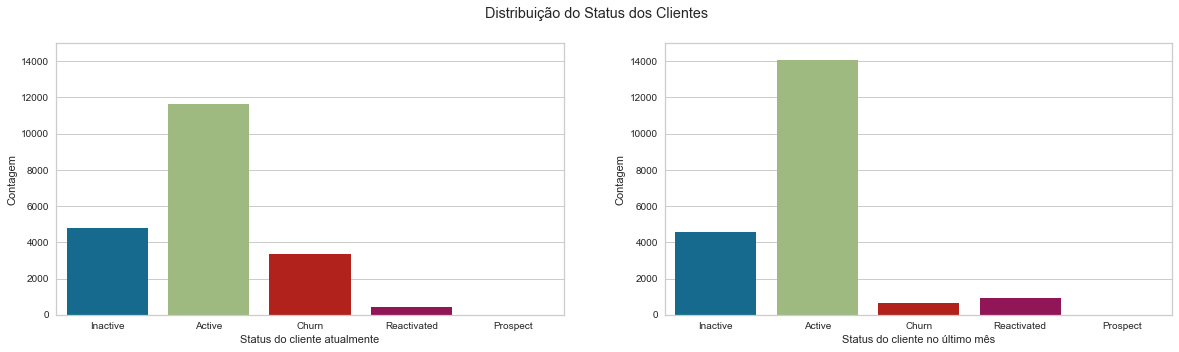

In [69]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))
fig.suptitle('Distribuição do Status dos Clientes')

sns.countplot(ax=axes[0], x=mkt_eda['ifood_status'],
              order=['Inactive', 'Active', 'Churn', 'Reactivated', 'Prospect']);
axes[0].set(xlabel='Status do cliente atualmente', ylabel='Contagem');
axes[0].set_ylim(0,15000);

sns.countplot(ax=axes[1],x=mkt_eda['ifood_status_last_month'],
              order=['Inactive', 'Active', 'Churn', 'Reactivated', 'Prospect']);
axes[1].set(xlabel='Status do cliente no último mês', ylabel='Contagem');
axes[1].set_ylim(0,15000);

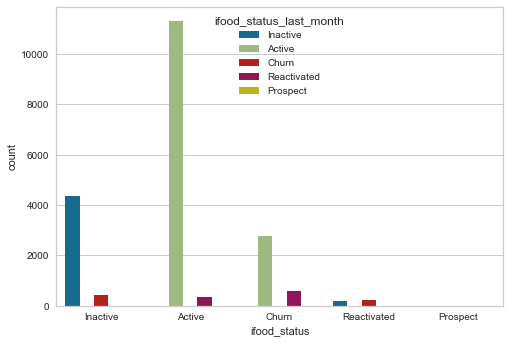

In [70]:
sns.countplot(data=mkt_eda, x='ifood_status',
              order=['Inactive', 'Active', 'Churn', 'Reactivated', 'Prospect'], 
              hue='ifood_status_last_month', 
              hue_order=['Inactive', 'Active', 'Churn', 'Reactivated', 'Prospect']);

In [71]:
status = pd.crosstab(index=[mkt_eda['ifood_status']], columns=[mkt_eda['ifood_status_last_month']], normalize=False)
status['total_current'] = status.sum(axis=1)
status.append(pd.DataFrame(status.sum(axis=0)).T.rename(index={0: 'total_last_month'}))

ifood_status_last_month,Active,Churn,Inactive,New,Prospect,Reactivated,total_current
Active,11312,0,0,0,1,336,11649
Churn,2768,0,0,1,0,586,3355
Inactive,0,428,4377,0,0,0,4805
Reactivated,0,234,206,0,0,0,440
total_last_month,14080,662,4583,1,1,922,20249


Os gráficos acima permitem algumas interpretações visuais, e a tabela acima, em que cada coluna mostra a quantidade no mês passado, e cada linha mostra no mês corrente (exceto a última linha e coluna, que são os totais somados):
- O número de clientes ativos continua alto (11649), porém, reduziu em relação ao mês passado(14080)
- Houve um aumento na quantidade de Churn (de 662 para 3355)
- O número de inativos aumentou ligeiramente (de 4583 para 4805)
- Houve uma redução no número de reativados (de 922 para 440)

Além disso, o gráfico de interação e a tabela permitem uma análise numérica precisa do movimento de cada cliente:
- Vemos que 586 dos clientes que haviam reativado a conta no mês anterior se tornaram Churn novamente no mês corrente, e apenas 336 (36%) dos que reativaram se mantem ativos
- 206 que estavam inativos reativaram a conta este mês, assim como 234 considerados Churn mes passado

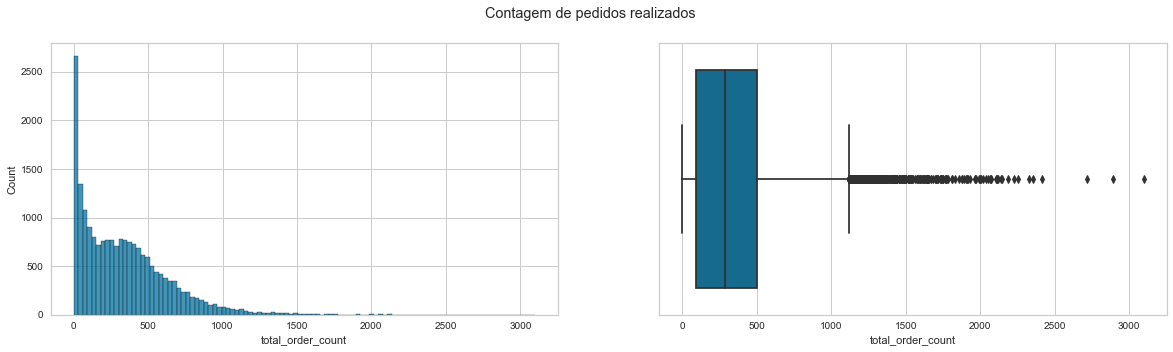

In [72]:
fig, axes = plt.subplots(1, 2, figsize = (20,5))
fig.suptitle('Contagem de pedidos realizados')
sns.histplot(ax=axes[0], x=mkt_eda['total_order_count']);
sns.boxplot(ax=axes[1],x=mkt_eda['total_order_count']);

- A quantidade de maior repetição é de uma quantidade muito baixa de pedidos. 
- Existem muitos clientes que realizaram até 500 ordens.
- Clientes que pediram mais de, em torno de, 1100 ordens são considerados outliers.

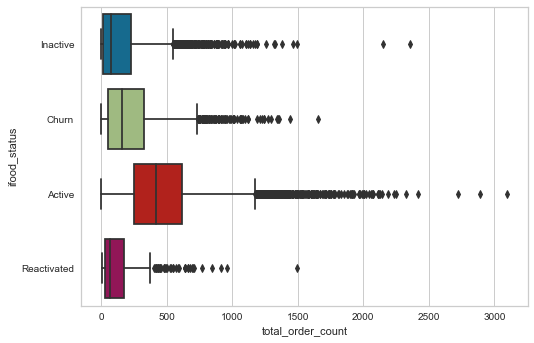

In [73]:
sns.boxplot(data=mkt_eda, x = 'total_order_count', y = 'ifood_status');

Quando avaliamos por status vemos que os clientes ativos fazem mais pedidos e tem uma mediana mais alta. Os que reativaram a conta recentemente são os que menos realizaram pedidos até o momento.

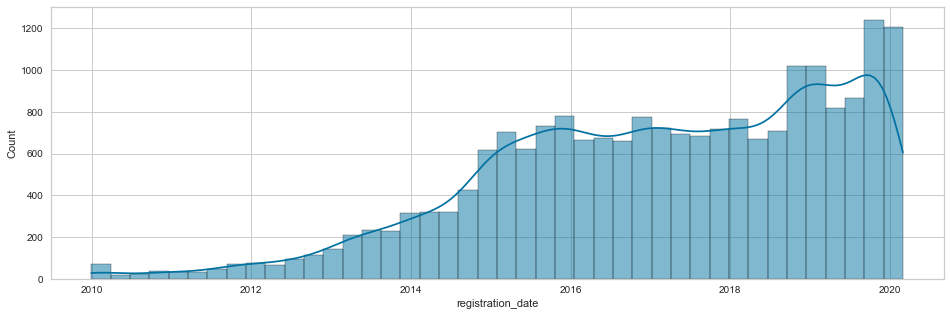

In [74]:
plt.figure(figsize=(16,5))
sns.histplot(data=mkt_eda, x='registration_date', kde=True);

A maior parte dos clientes são mais novos, existindo um salto na quantidade de novos registros em 2015, que se mantem estável até 2018, com um novo salto em 2019.

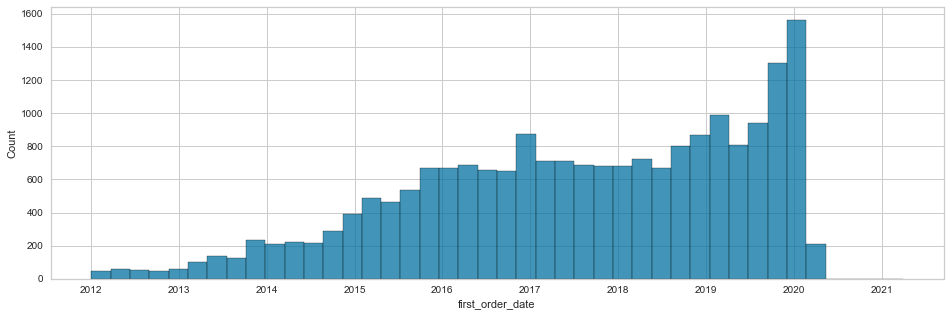

In [75]:
plt.figure(figsize=(16,5))
sns.histplot(data=mkt_eda, x='first_order_date');

As novas ordens seguem a tendência observada em novos registros, existindo um salto acentuado no final de 2019 e início de 2020.

In [76]:
mkt_eda['registration_to_order'] = (mkt_eda['first_order_date']-mkt_eda['registration_date'])

In [77]:
mkt_eda['registration_to_order'].describe(percentiles=[0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

count                           20249
mean      155 days 22:18:09.831596622
std       396 days 07:51:16.118256448
min               -899 days +00:00:00
1%                  -1 days +00:00:00
5%                  -1 days +00:00:00
10%                 -1 days +00:00:00
15%                   0 days 00:00:00
25%                   0 days 00:00:00
50%                   0 days 00:00:00
75%                  64 days 00:00:00
90%       548 days 04:48:00.000000064
95%      1050 days 14:23:59.999999872
99%      1919 days 12:28:48.000000032
max                3633 days 00:00:00
Name: registration_to_order, dtype: object

Surpreendentemente existem casos em que a data do primeiro pedido é anterior à data de registro da conta, e boa parte destes são 1 dia de diferença. <br>
Uma hipótese é que houve algum problema com a conta, como suspeita de fraude, e depois teve uma liberação manual, que sobreescreveu a data original. Assim, assumiremos a data de pedido como data de registro, dado que iso é a mediana dos dados.

In [78]:
mkt_eda['registration_to_order_hrs'] = mkt_eda['registration_to_order'].apply(lambda x: x.total_seconds())/(60*60)

In [79]:
aux3 = mkt_eda[mkt_eda['registration_to_order_hrs']<0]['first_order_date']
for idx, value in aux3.items():
    mkt_eda['registration_date'].iloc[idx] = value

In [80]:
mkt_eda['registration_to_order'] = (mkt_eda['first_order_date']-mkt_eda['registration_date'])
mkt_eda['registration_to_order_hrs'] = mkt_eda['registration_to_order'].apply(lambda x: x.total_seconds())/(60*60)

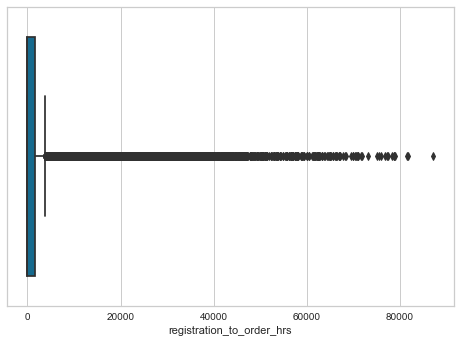

In [81]:
sns.boxplot(data=mkt_eda, x='registration_to_order_hrs');

#### Sessions

In [82]:
sessions_eda = sessions_clean.copy()

In [83]:
sessions_eda.head(2)

,session_id,user_account_uuid,session_started,session_ended,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,media_campaign,load_time,available_restaurants,rownumber
0,0a364c77-4375-4334-8f64-a06bdd22229c,5a2fbdea-e2ee-41a5-b47c-41fbebdc78ef,2020-02-01 00:00:03.924000+00:00,2020-02-01 00:10:51.217000+00:00,19,5,6,6,7,False,5.0,462.0,1
1,b01811cd-ad2c-42f1-bccf-b90698ccc7a8,20cb43a7-c90d-4451-b067-e1b934746de6,2020-02-01 00:00:09.616000+00:00,2020-02-01 00:14:22.713000+00:00,14,1,0,0,0,False,5.0,128.0,2


In [84]:
sessions_eda.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99], datetime_is_numeric=True)

,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,load_time,available_restaurants,rownumber
count,3.591511e+06,3.591511e+06,3.591511e+06,3.591511e+06,3.591511e+06,3.591511e+06,3.591511e+06,3.591511e+06
mean,6.541976e+00,3.401753e+00,1.613600e+00,2.015747e+00,7.375651e-01,3.251220e+01,1.161834e+03,1.795756e+06
std,1.290502e+01,6.024095e+00,2.866229e+00,4.228897e+00,2.103870e+00,9.078831e+02,1.121173e+03,1.036780e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-7.597200e+04,0.000000e+00,1.000000e+00
1%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,3.591610e+04
5%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,1.795765e+05
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,3.240000e+02,8.978785e+05
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,8.310000e+02,1.795756e+06
75%,8.000000e+00,4.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,5.000000e+00,1.650000e+03,2.693634e+06
95%,2.600000e+01,1.300000e+01,6.000000e+00,8.000000e+00,2.000000e+00,1.600000e+01,3.561000e+03,3.411936e+06


In [85]:
sessions_eda.describe(include='object')

,session_id,user_account_uuid
count,3591511,3591511
unique,3591511,20095
top,1b0cf9c9-d306-4510-b3d3-f7df19492758,9ca6a64b-e88c-456a-a42b-c0b1a85d025c
freq,1,1618


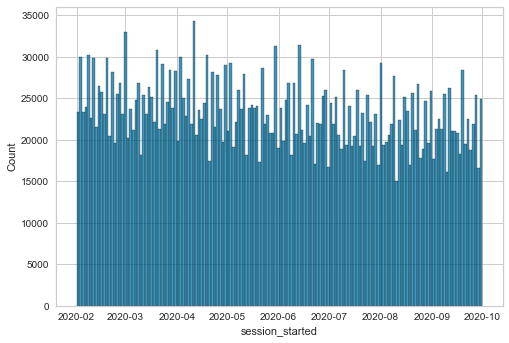

In [86]:
sns.histplot(data=sessions_eda, x='session_started');

In [87]:
sessions_eda['session_duration'] = (sessions_eda['session_ended'] - sessions_eda['session_started']).apply(
    lambda x: x.total_seconds())/(60)

count    3.591511e+06
mean     2.050399e+01
std      2.832106e+03
min     -5.356736e+06
25%      1.356183e+00
50%      8.026575e+00
75%      2.863038e+01
max      1.195457e+05
Name: session_duration, dtype: float64

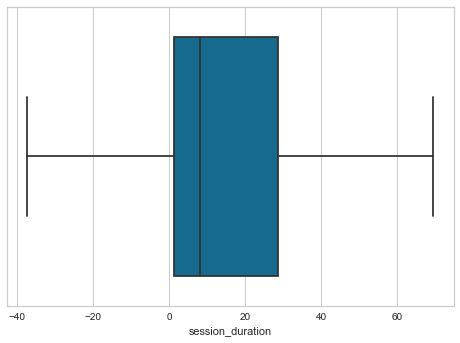

In [88]:
sns.boxplot(data=sessions_eda, x='session_duration', showfliers=False);

sessions_eda['session_duration'].describe()

count    3.591511e+06
mean     6.541976e+00
std      1.290502e+01
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      8.000000e+00
max      2.612000e+03
Name: sum_view_restaurant_screen, dtype: float64

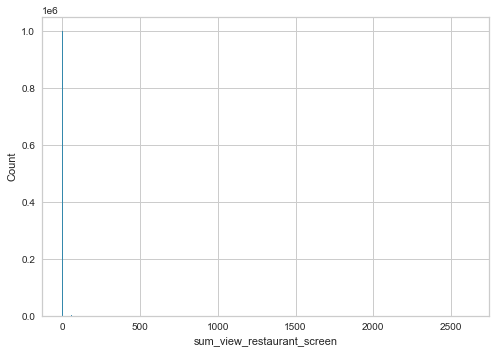

In [89]:
sns.histplot(data=sessions_eda, x='sum_view_restaurant_screen');
sessions_eda['sum_view_restaurant_screen'].describe()

In [90]:
sessions_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3591511 entries, 0 to 3591510
Data columns (total 14 columns):
 #   Column                      Dtype              
---  ------                      -----              
 0   session_id                  object             
 1   user_account_uuid           object             
 2   session_started             datetime64[ns, UTC]
 3   session_ended               datetime64[ns, UTC]
 4   sum_view_restaurant_screen  int64              
 5   sum_view_dish_screen        int64              
 6   sum_click_add_item          int64              
 7   sum_view_checkout           int64              
 8   sum_callback_purchase       int64              
 9   media_campaign              bool               
 10  load_time                   float64            
 11  available_restaurants       float64            
 12  rownumber                   int64              
 13  session_duration            float64            
dtypes: bool(1), datetime64[ns, UTC](2)

#### Orders

In [91]:
orders_eda = orders_clean.copy()

In [92]:
orders_eda.head(2)

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,875.0,False,5375.0,0.0,ANDROID,MOBILE,9.39.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,83c3e069dbd7267a7565a16b879cd968c0968a27ac16e6...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.38,RJ,RIO DE JANEIRO,PAVUNA,21650420,-43.38,-22.83,False,2020-02-28 14:07:25.953000+00:00,2020-02-28 16:06:03.701000+00:00,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8,2020-02-28 19:06:31.861000+00:00
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,weekend dinner,RESTAURANT,0.0,False,2987.5,1250.0,IOS,MOBILE,9.63.0,-22.93-43.18,RJ,RIO DE JANEIRO,FLAMENGO,-43.18,-22.94,2531d200d387f462ed6e096086723c43b48de9b6c3ec05...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.93-43.21,RJ,RIO DE JANEIRO,Rio Comprido,20261170,-43.22,-22.93,True,2020-08-21 21:12:23.295000+00:00,2020-08-21 21:59:18.732000+00:00,1.0,407bab9f-f485-48cd-abea-66e6283058c3,5.0,8,2020-09-04 00:14:14.365000+00:00


In [93]:
orders_eda.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99], datetime_is_numeric=True)

,delivery_fee,total_amount,subsidy_amount,customer_long,customer_lat,merchant_zipcode,merchant_long,merchant_lat,lag_last_order,review_score,nps_score
count,226269.000000,226269.000000,226269.000000,226269.000000,226269.000000,2.262690e+05,226269.000000,226269.000000,226269.000000,226269.000000,226269.000000
mean,405.418965,6017.809350,343.687580,-45.693016,-23.192878,1.693620e+07,-45.692937,-23.193716,2.502424,4.666207,9.108150
std,504.026635,5180.780032,677.852181,2.184032,2.206372,2.094803e+07,2.194552,2.206171,11.980583,0.928577,1.895903
min,-1247.500000,0.000000,-2.500000,-67.870000,-31.780000,0.000000e+00,-67.840000,-31.780000,-1.000000,1.000000,1.000000
1%,0.000000,625.000000,-1.250000,-50.420000,-25.510000,1.046010e+06,-50.430000,-25.520000,0.000000,1.000000,1.000000
5%,0.000000,1373.750000,0.000000,-49.270000,-25.430000,1.319040e+06,-49.270000,-25.430000,0.000000,2.000000,5.000000
25%,0.000000,2768.750000,0.000000,-46.710000,-23.600000,4.048000e+06,-46.700000,-23.600000,0.000000,5.000000,9.000000
50%,0.000000,4500.000000,0.000000,-46.620000,-23.530000,6.473073e+06,-46.620000,-23.540000,1.000000,5.000000,10.000000
75%,748.750000,7523.750000,623.750000,-43.350000,-22.940000,2.222003e+07,-43.350000,-22.950000,2.000000,5.000000,10.000000
95%,1487.500000,15498.750000,1747.500000,-43.190000,-22.820000,8.041020e+07,-43.190000,-22.820000,8.000000,5.000000,10.000000


In [94]:
orders_eda.describe(include='object')

,order_id,order_shift,order_origin,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,account_id
count,226269,226269,226269,226269,226269,226269,226269,226269,226269,226269,226269,226269,226269,226269,226269,226269,226269,226269
unique,226269,10,3,3,2,213,4141,27,315,4443,38007,61,3497,5544,27,327,7558,13964
top,60bc1c68-09ba-4cff-ad0f-6cf5e4d776fd,weekday lunch,RESTAURANT,ANDROID,MOBILE,9.37.1,-23.59-46.75,SP,SAO PAULO,Vila Mariana,b673fc594de4cf0015db6620559afe2e29e6acee429683...,Lanches,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-23.6-46.73,SP,SAO PAULO,Centro,d300ac6b-3fd5-4f24-b80e-a2a0066f925c
freq,1,58433,219886,118145,202494,9130,2912,129942,115186,4023,629,44267,146490,3080,129955,113613,3371,834


order_shift
weekday lunch        0.258246
weekday dinner       0.237417
weekend dinner       0.224604
weekend lunch        0.100685
weekday snack        0.059142
weekday breakfast    0.054616
weekend snack        0.026115
weekday dawn         0.016918
weekend dawn         0.014713
weekend breakfast    0.007544
dtype: float64

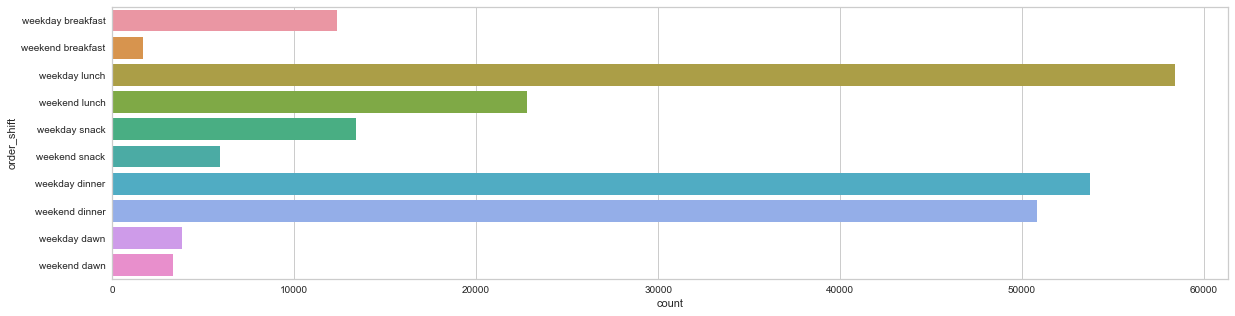

In [95]:
plt.figure(figsize=(20,5))
sns.countplot(data=orders_eda, y='order_shift', order=
              ['weekday breakfast', 'weekend breakfast',
               'weekday lunch', 'weekend lunch',
               'weekday snack', 'weekend snack',
               'weekday dinner', 'weekend dinner',
               'weekday dawn', 'weekend dawn']);

orders_eda.value_counts('order_shift', normalize=True)

order_origin
RESTAURANT      0.971790
STORE           0.021205
QUICKLY_MEAL    0.007005
dtype: float64

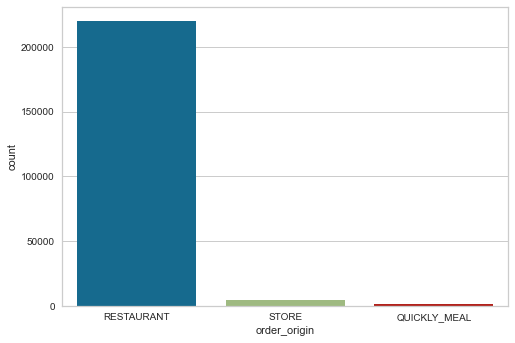

In [96]:
sns.countplot(data=orders_eda, x='order_origin');

orders_eda.value_counts('order_origin', normalize=True)

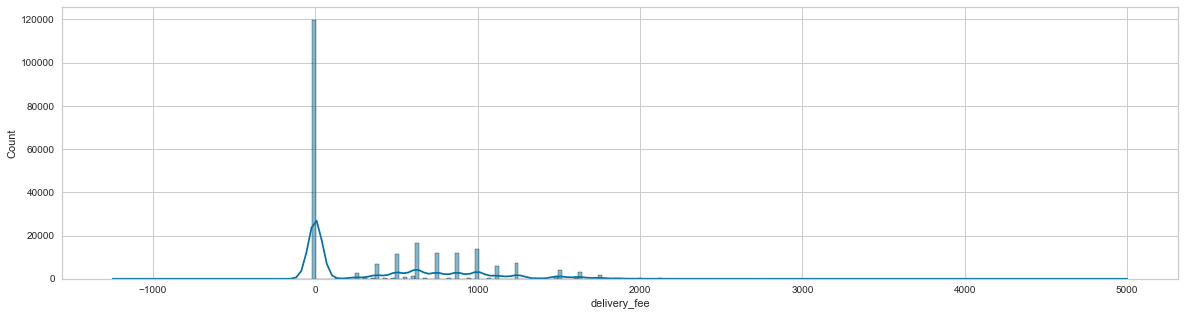

In [97]:
plt.figure(figsize=(20,5))
sns.histplot(data=orders_eda, x='delivery_fee', kde=True);

In [98]:
orders_eda.value_counts('scheduled', normalize=True)

scheduled
False    0.975313
True     0.024687
dtype: float64

count    226269.000000
mean       6017.809350
std        5180.780032
min           0.000000
25%        2768.750000
50%        4500.000000
75%        7523.750000
max      174873.750000
Name: total_amount, dtype: float64

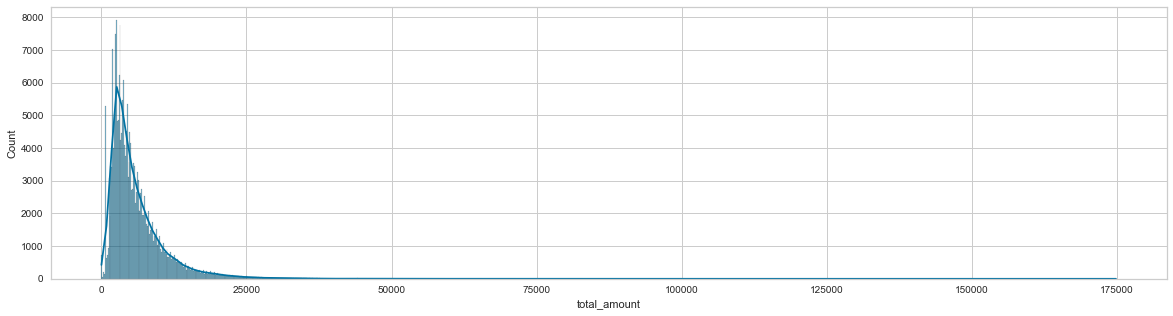

In [99]:
plt.figure(figsize=(20,5))
sns.histplot(data=orders_eda, x='total_amount', kde=True);

orders_eda['total_amount'].describe()

Valores em centavos, assim, a maior parte das ordens se encontra entre 27 reais e 75 reais, existindo, no entanto, ordens de até 1748 reais.

count    226269.000000
mean        343.687580
std         677.852181
min          -2.500000
25%           0.000000
50%           0.000000
75%         623.750000
max       19611.250000
Name: subsidy_amount, dtype: float64

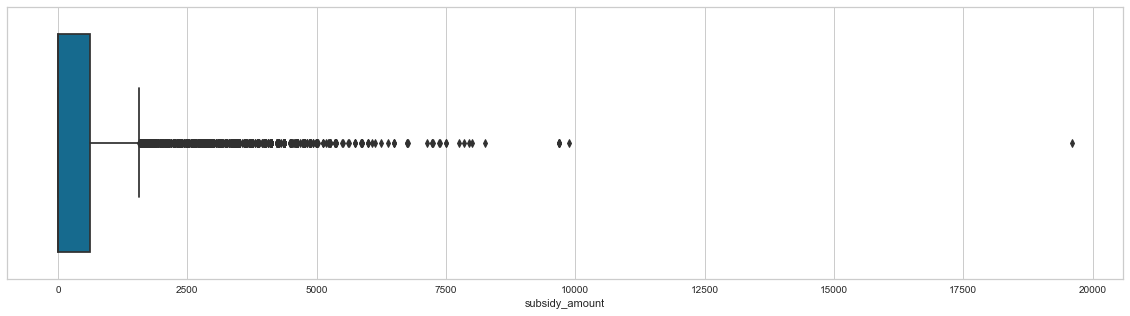

In [100]:
plt.figure(figsize=(20,5))
sns.boxplot(data=orders_eda, x='subsidy_amount');
orders_eda['subsidy_amount'].describe()

device_platform
ANDROID    0.522144
IOS        0.375836
DESKTOP    0.102020
dtype: float64

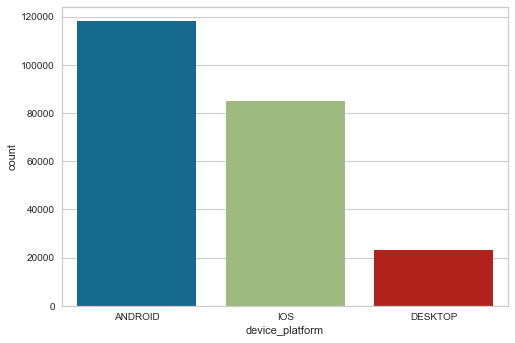

In [101]:
sns.countplot(data=orders_eda, x='device_platform');

orders_eda.value_counts('device_platform', normalize=True)

device_type
MOBILE    0.894926
SITE      0.105074
dtype: float64

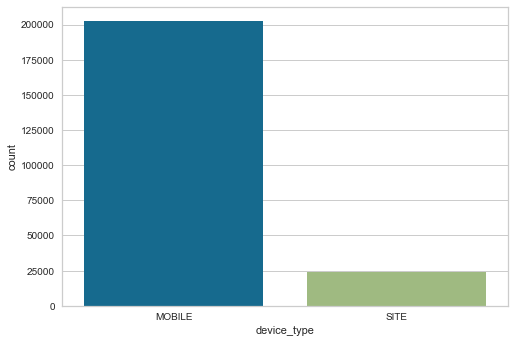

In [102]:
sns.countplot(data=orders_eda, x='device_type');

orders_eda.value_counts('device_type', normalize=True)

In [103]:
orders_eda.value_counts('device_app_version')

device_app_version
9.37.1    9130
9.46.1    7954
9.54.0    6547
8.12.0    6283
9.64.0    6135
          ... 
9.71.0       1
9.12.0       1
8.12.1       1
9.17.0       1
8.0.4        1
Length: 213, dtype: int64

state_label
SP    0.574281
RJ    0.330306
PR    0.062828
MG    0.006329
DF    0.003628
RS    0.003597
CE    0.003518
SC    0.002161
PA    0.001476
GO    0.001348
ES    0.001326
BA    0.001189
PE    0.001061
MS    0.000981
AM    0.000862
SE    0.000818
PB    0.000769
MT    0.000720
PI    0.000707
AL    0.000601
RN    0.000522
RR    0.000358
MA    0.000305
RO    0.000261
AP    0.000027
TO    0.000013
AC    0.000009
dtype: float64

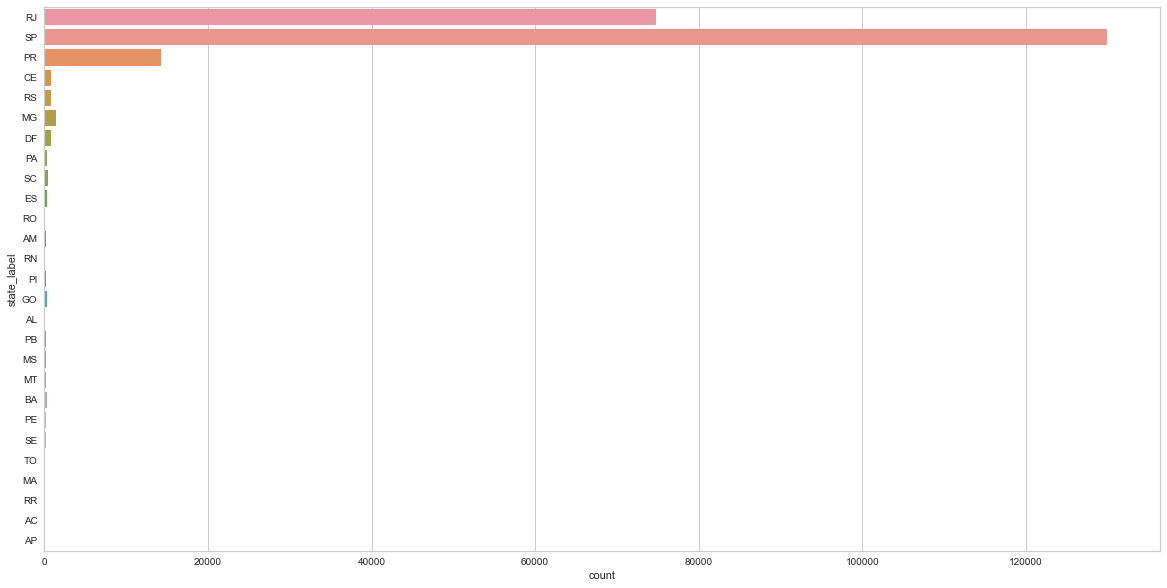

In [104]:
plt.figure(figsize=(20,10))
sns.countplot(data=orders_eda, y='state_label');

orders_eda.value_counts('state_label', normalize=True)

In [105]:
orders_eda['city'].nunique()

315

In [106]:
orders_eda['district'].nunique()

4443

In [107]:
from math import radians, cos, sin, asin, sqrt

In [108]:
def DistanceFromCoord(lat1,lon1,lat2,lon2):
    '''
    Parameters
    ----------
    lat1: Float
        Latitude da coordenada 1.

    lon1: Float
        Longitude da coordenada 1.

    lat2: Float
        Latitude da coordenada 2.

    lon2: Float
        Longitude da coordenada 2.
        
    Baseado em: https://www.geeksforgeeks.org/program-distance-two-points-earth/#:~:text=For%20this%20divide%20the%20values,is%20the%20radius%20of%20Earth.
    
    Return
    ------

    float
        Distance: Distância em km entre as duas coordenadas fornecidas    
    
    '''
    
    R= 6371 # Raio da Terra em km
    lon1rad = radians(lon1)
    lon2rad = radians(lon2)
    lat1rad = radians(lat1)
    lat2rad = radians(lat2)
    
    dlon = lon2rad - lon1rad
    dlat = lat2rad - lat1rad
    
    a = sin(dlat/2)**2 + cos(lat1rad)*cos(lat2rad)*sin(dlon/2)**2
    c = 2*asin(sqrt(a))
    Distance = R*c
    
    return Distance

In [109]:
orders_eda['Distance_customer_merchant'] = orders_eda.apply(lambda row: DistanceFromCoord(row['customer_lat'], 
                                                                                  row['customer_long'],
                                                                                  row['merchant_lat'], 
                                                                                  row['merchant_long']), axis=1)

In [110]:
orders_eda['Distance_customer_merchant'].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

count    226269.000000
mean          2.398692
std          23.208812
min           0.000000
1%            0.000000
5%            0.000000
25%           1.111949
50%           2.039139
75%           3.253571
95%           6.032407
99%           8.045865
max        9313.511500
Name: Distance_customer_merchant, dtype: float64

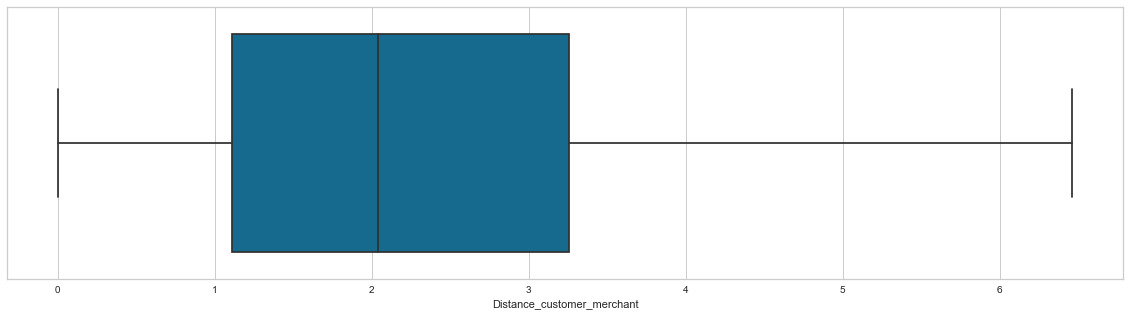

In [111]:
plt.figure(figsize=(20,5))
sns.boxplot(data=orders_eda, x='Distance_customer_merchant', showfliers=False);

dish_type
Lanches              0.195639
Comida Brasileira    0.186101
Pizza                0.143617
Comida Japonesa      0.138808
Doces & Bolos        0.042392
                       ...   
Colombiana           0.000009
Xis                  0.000009
Africana             0.000009
Paranaense           0.000004
Típica do Norte      0.000004
Length: 61, dtype: float64

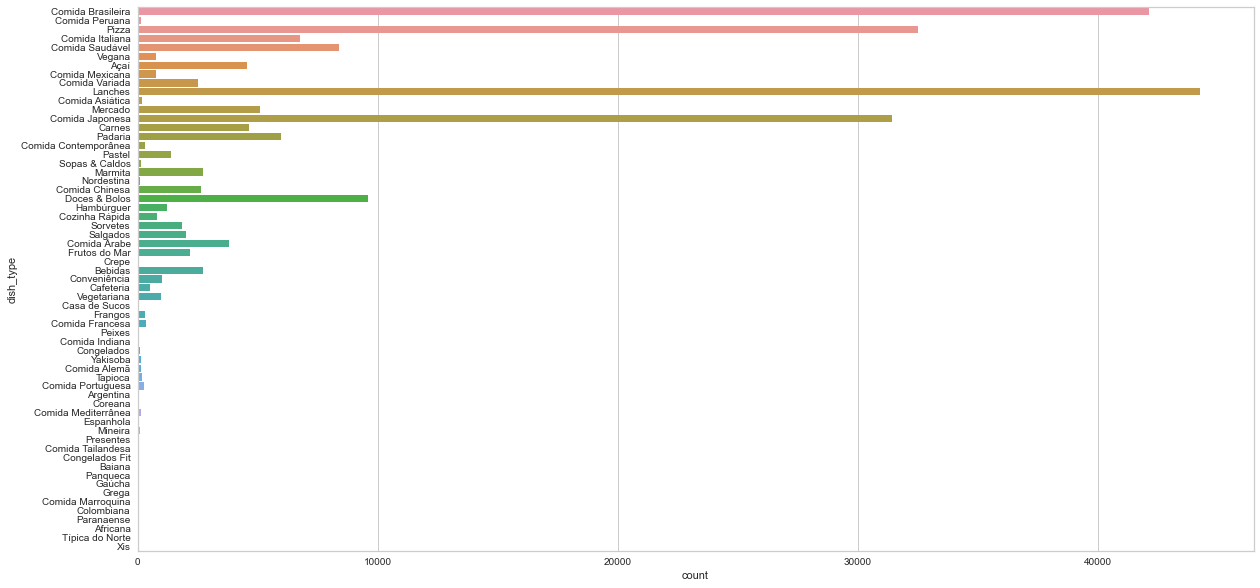

In [112]:
plt.figure(figsize=(20,10))
sns.countplot(data=orders_eda, y='dish_type');

orders_eda.value_counts('dish_type', normalize=True)

In [113]:
orders_eda.value_counts('dish_type', normalize=True).head(9)

dish_type
Lanches              0.195639
Comida Brasileira    0.186101
Pizza                0.143617
Comida Japonesa      0.138808
Doces & Bolos        0.042392
Comida Saudável      0.037013
Comida Italiana      0.029933
Padaria              0.026411
Mercado              0.022610
dtype: float64

In [114]:
top_dish = orders_eda.value_counts('dish_type', normalize=True).head(9)

In [115]:
most_common = orders_eda[['account_id', 'dish_type']].groupby('account_id')['dish_type'].agg(
    lambda x: pd.Series.mode(x)[0])

In [116]:
most_common.nunique()

54

In [117]:
most_common.value_counts(normalize=True).head(9)

Lanches              0.263750
Comida Brasileira    0.255156
Comida Japonesa      0.082856
Pizza                0.082641
Doces & Bolos        0.045116
Comida Italiana      0.034804
Comida Saudável      0.034446
Açaí                 0.033658
Carnes               0.026497
Name: dish_type, dtype: float64

In [118]:
most_common.value_counts(normalize=True).head(12).sum()

0.9063305643082213

Vemos que os primeiros 9 tipos de comidas mais pedidos representam 84% do total de pedidos. Se agruparmos os pedidos por usuário, avaliando o mais pedido, com exceção de Padaria e Mercado que são substituídos por Açaí e Carnes, os outros 7 tipos com mais pedidos no total estão no topo sendo os que mais frequentemente são os mais pedidos pelo usuário. 

Isso indica que, apesar de muitas pessoas realizarem pedidos de padarias e mercados, estas não são seus tipos preferidos de pedidos. Já açaí e carnes são comprados os mais pedidos de algumas pessoas, mas sendo menos comprados de forma geral.

Poderemos abordar assim, os 9 tipos mais comumns e os demais tratar como 'Outros', tendo no total 10 categorias e não as 61 originais.

In [119]:
orders_eda['dish_type_top'] = orders_eda['dish_type'].apply(lambda x: x if x in top_dish.index.to_list() else 'Others')

In [120]:
orders_eda.value_counts('dish_type', normalize=True)

dish_type
Lanches              0.195639
Comida Brasileira    0.186101
Pizza                0.143617
Comida Japonesa      0.138808
Doces & Bolos        0.042392
                       ...   
Colombiana           0.000009
Xis                  0.000009
Africana             0.000009
Paranaense           0.000004
Típica do Norte      0.000004
Length: 61, dtype: float64

In [121]:
orders_eda[['account_id', 'dish_type']].groupby('account_id')['dish_type'].agg(
    lambda x: pd.Series.mode(x)[0]).value_counts(normalize=True)

Lanches                 0.263750
Comida Brasileira       0.255156
Comida Japonesa         0.082856
Pizza                   0.082641
Doces & Bolos           0.045116
Comida Italiana         0.034804
Comida Saudável         0.034446
Açaí                    0.033658
Carnes                  0.026497
Mercado                 0.017187
Bebidas                 0.015683
Padaria                 0.014537
Comida Árabe            0.013821
Comida Chinesa          0.008737
Marmita                 0.007663
Comida Variada          0.007663
Frutos do Mar           0.006015
Salgados                0.004512
Vegetariana             0.004154
Hambúrguer              0.004010
Vegana                  0.003867
Cafeteria               0.003724
Conveniência            0.003652
Sorvetes                0.003581
Comida Mexicana         0.003437
Cozinha Rápida          0.002865
Pastel                  0.002721
Comida Francesa         0.002005
Comida Contemporânea    0.001934
Comida Asiática         0.001217
Comida Por

In [122]:
orders_eda['restaurant_id'].value_counts()

b673fc594de4cf0015db6620559afe2e29e6acee429683df4bcf82301fb8b9b3    629
f1416af976281df43ae8daabd5f5b0fa56487a7641c3c702c303ed51072d32b4    560
d3dcb01f6b3626d611fbb2b43adceb218a9b0b68977c34136a1e252b2ac72199    441
cc6f3a7a83faf0c0ce4e7ec414b1b1b29aedfce9143a67bc709e9fec5bc567b8    391
6ae8352019bbc81a970005d68f84f5e0c38e00f3d223f01647b6339c064435e1    368
                                                                   ... 
2e79a32195b2ba771b8021ebbdcf409511e1ed2b9c9d9e176e77316d141592f7      1
38aa0acc680f76c36bd9e25e06390a6298d05084e4114c96b0979f6a557ffe53      1
570d7d0504d580a9cfbf77158382791687ea0f5ff28689d443aac6c1f58e7e24      1
ec2b681d3b15daf47f1a95141126c17738fb10025605fff425a816bc41104064      1
7d05a560776b5486cced82b841f34f8347c6ec525c13f205ab5dbdb239ac1fbe      1
Name: restaurant_id, Length: 38007, dtype: int64

In [123]:
orders_eda['group_id'].value_counts()

ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f60a0801063e95842570    146490
d1f320b6b48e3e8d776ca2c97d20ed08ad124c3851987b29588b26b065873684      3602
6c87a914ae675436eed3905f052ea29f897396dfd8c75c2441bec0e631c5243b      2298
81bab5fdb02f68291fb109bf9bcd420ea847be7b4f212eced6d5295abbc43574      1663
b9e8a0acf65dbed3357ed392b059810b0642545811d0bfb90b1b740b9111810d      1445
                                                                     ...  
d412d978bea96fcaeb225469db6d0fecec6c15bc52084e6b8a009b3911bbc215         1
95c257fe73adaccadd6e374d1d33545a0c5c75374a356441c6a43680c182ddd1         1
f2fb1eb3eb4a20b6b7b444749889fa216eef4955c26610f022b3a9e39538fae6         1
34d15adb2359600fdd1ea4b505dba3bfbf11ddd1aa665d8a54d5839b0298ad0e         1
4649a78133f668006cc550b57ae21a654f32e3919b9efeb03e0358c85fe6b4b0         1
Name: group_id, Length: 3497, dtype: int64

has_free_delivery
True     0.529392
False    0.470608
dtype: float64

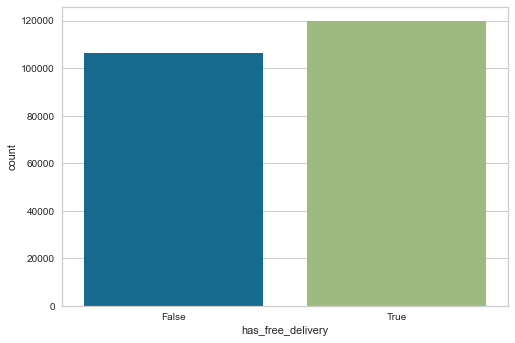

In [124]:
sns.countplot(data=orders_eda, x='has_free_delivery');

orders_eda.value_counts('has_free_delivery', normalize=True)

In [125]:
orders_eda['time_to_conclude'] = (orders_eda['concluded_date']-orders_eda['confirmed_date']).apply(
    lambda x: x.total_seconds())/(60*60)

count    226269.000000
mean          2.207012
std           3.182861
min          -3.976917
25%           0.595112
50%           1.999807
75%           3.999862
max         180.478078
Name: time_to_conclude, dtype: float64

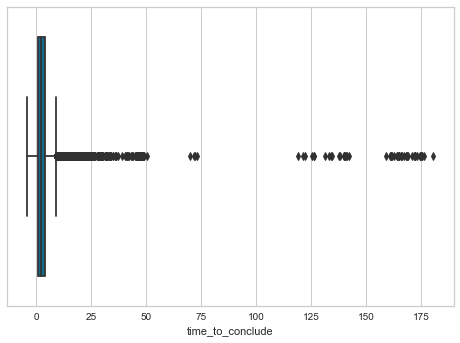

In [126]:
sns.boxplot(data=orders_eda, x='time_to_conclude');
orders_eda['time_to_conclude'].describe()

Novamente, uma situação inesperada, onde o tempo para concluir o pedido é negativo.

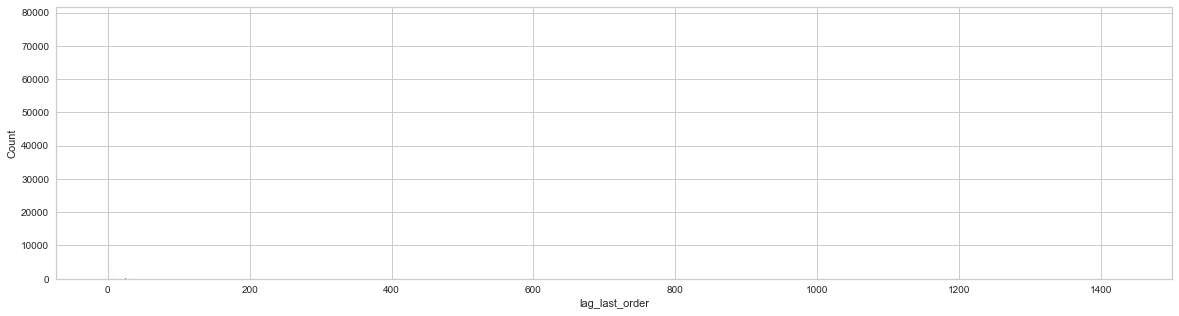

In [127]:
plt.figure(figsize=(20,5))
sns.histplot(data=orders_eda, x='lag_last_order');

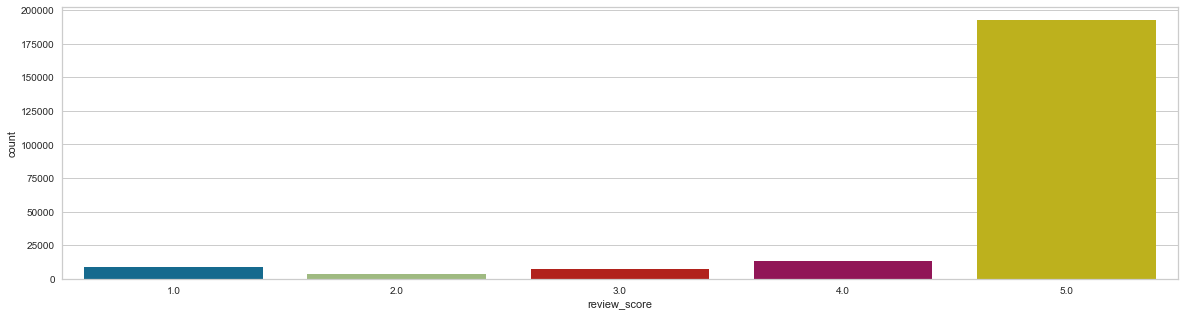

In [128]:
plt.figure(figsize=(20,5))
sns.countplot(data=orders_eda, x='review_score');

In [129]:
orders_eda['time_to_review'] = (orders_eda['review_created_at']-orders_eda['concluded_date']).apply(
    lambda x: x.total_seconds())/(60*60)

count    226269.000000
mean         57.607970
std          80.666276
min        -173.666214
25%           3.524059
50%          21.830975
75%          75.752236
max         381.341674
Name: time_to_review, dtype: float64

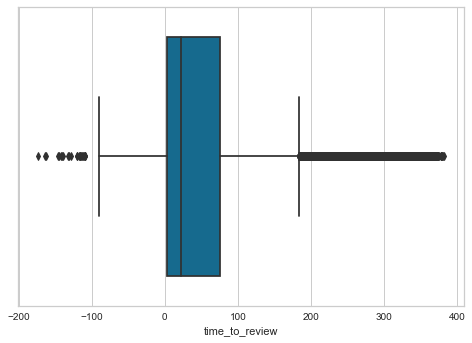

In [130]:
sns.boxplot(data=orders_eda, x='time_to_review');
orders_eda['time_to_review'].describe()

Mais uma vez, um valor negativo obtido, de modo que o usuário fez a review antes de concluído o pedido.

In [131]:
orders_eda['time_to_review2'] = (orders_eda['review_created_at']-orders_eda['confirmed_date']).apply(
    lambda x: x.total_seconds())/(60*60)

count    226269.000000
mean         59.814982
std          80.842466
min          -0.892341
25%           5.171096
50%          24.793521
75%          77.821450
max         383.685944
Name: time_to_review2, dtype: float64

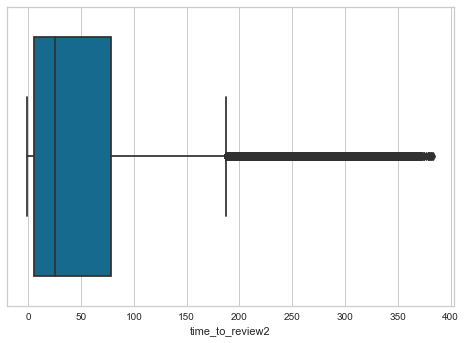

In [132]:
sns.boxplot(data=orders_eda, x='time_to_review2');
orders_eda['time_to_review2'].describe()

## 6. Feature Engineering <a name="featureengineering"></a>

Para a criação do cluster é necessário um único dataframe com informações agrupadas por cliente, resumindo informações das diferentes sessões e ordens realizadas e unindo-as ao dataset de marketing, tendo `account_id` como chave primária.

O dataset de marketing já apresenta dados agrupados ou informações da situação atual, registro e primeiro pedido. Dele, transformaremos ainda a informação da data em que foi feito o registro e o primeiro pedido em dias decorridos desta data ao presente. A feature `registration_to_order_hrs`criada criada no dataset final.

#### Marketing

In [133]:
mkt_clean.head(2)

,account_id,registration_date,ifood_status,ifood_status_last_month,total_order_count,first_order_date
0,7c0450e7-a806-4208-8449-e4269a27e6b5,2020-02-02,Inactive,Inactive,8,2020-02-28
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,2016-05-17,Churn,Active,457,2017-03-19


In [134]:
def feat_eng_mkt(mkt_df):
    mkt_df_feteng = mkt_df.copy()
    today = pd.to_datetime(datetime.now())
    
  #  mkt_df_feteng['days_since_registration'] = (today - mkt_df_feteng['registration_date']).apply(
   # lambda x: x.total_seconds())/(24*60*60)
    mkt_df_feteng['days_since_first_order'] = (today - mkt_df_feteng['first_order_date']).apply(
    lambda x: x.total_seconds())/(24*60*60)
    
    aux3 = mkt_df_feteng[(mkt_df_feteng['first_order_date']<mkt_df_feteng['registration_date'])]['first_order_date']
    for idx, value in aux3.items():
        mkt_df_feteng['registration_date'].iloc[idx] = value
    
    mkt_df_feteng['registration_to_order_hrs'] = (mkt_df_feteng['first_order_date']-mkt_df_feteng['registration_date']).apply(
    lambda x: x.total_seconds())/(60*60)
    
    
    mkt_df_feteng = mkt_df_feteng.drop(columns=['registration_date', 'first_order_date'])
    
    return (mkt_df_feteng)

In [135]:
mkt_feateng = feat_eng_mkt(mkt_clean)

In [136]:
mkt_feateng.head(2)

,account_id,ifood_status,ifood_status_last_month,total_order_count,days_since_first_order,registration_to_order_hrs
0,7c0450e7-a806-4208-8449-e4269a27e6b5,Inactive,Inactive,8,851.560217,624.0
1,16d0afba-00b8-427a-ba1f-2e397a9fbb54,Churn,Active,457,1927.560217,7344.0


In [137]:
mkt_feateng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20249 entries, 0 to 20248
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   account_id                 20249 non-null  object 
 1   ifood_status               20249 non-null  object 
 2   ifood_status_last_month    20249 non-null  object 
 3   total_order_count          20249 non-null  int64  
 4   days_since_first_order     20249 non-null  float64
 5   registration_to_order_hrs  20249 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 949.3+ KB


#### Orders

In [138]:
orders_clean.head(2)

,order_id,order_shift,order_origin,delivery_fee,scheduled,total_amount,subsidy_amount,device_platform,device_type,device_app_version,centroid_id,state_label,city,district,customer_long,customer_lat,restaurant_id,dish_type,group_id,merchant_centroid_id,merchant_state,merchant_city,merchant_district,merchant_zipcode,merchant_long,merchant_lat,has_free_delivery,confirmed_date,concluded_date,lag_last_order,account_id,review_score,nps_score,review_created_at
0,000f4c94-ec38-488b-ad98-9bf3ea19d517,weekday lunch,RESTAURANT,875.0,False,5375.0,0.0,ANDROID,MOBILE,9.39.1,-22.83-43.35,RJ,RIO DE JANEIRO,Coelho Neto,-43.35,-22.83,83c3e069dbd7267a7565a16b879cd968c0968a27ac16e6...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.82-43.38,RJ,RIO DE JANEIRO,PAVUNA,21650420,-43.38,-22.83,False,2020-02-28 14:07:25.953000+00:00,2020-02-28 16:06:03.701000+00:00,1.0,70a2a5a3-8071-47fc-a623-e9995045314e,5.0,8,2020-02-28 19:06:31.861000+00:00
1,0018ed39-3ae0-4047-9c9e-fd9a2027e645,weekend dinner,RESTAURANT,0.0,False,2987.5,1250.0,IOS,MOBILE,9.63.0,-22.93-43.18,RJ,RIO DE JANEIRO,FLAMENGO,-43.18,-22.94,2531d200d387f462ed6e096086723c43b48de9b6c3ec05...,Comida Brasileira,ae3c8b8d99a39542f78af83dbbb42c81cd94199ec1b5f6...,-22.93-43.21,RJ,RIO DE JANEIRO,Rio Comprido,20261170,-43.22,-22.93,True,2020-08-21 21:12:23.295000+00:00,2020-08-21 21:59:18.732000+00:00,1.0,407bab9f-f485-48cd-abea-66e6283058c3,5.0,8,2020-09-04 00:14:14.365000+00:00


In [139]:
orders_clean.groupby(['account_id','state_label'])['total_amount'].count().to_frame().reset_index()

,account_id,state_label,total_amount
0,00073adf-7117-44ba-90fe-5879c9581b68,PR,1
1,000b1fec-8616-4014-9581-c5a944911ac3,RJ,4
2,000db136-b110-4dd6-9d1c-a70ab1ab2d75,SP,26
3,000f5a0c-cfac-44f9-a296-7f745b38a863,SP,11
4,0019a335-0326-4032-af5b-7b76413633e0,SP,2
...,...,...,...
14696,ffed5c4e-e18a-4cfc-b985-472d18b5b1f0,SP,1
14697,ffef562a-c954-4405-b89a-95908342766e,RJ,3
14698,fffbe0eb-4420-4f1d-b360-a3c235d02ea3,SP,22
14699,fffd0e0e-43e3-4705-8299-d5c9b016c3e4,SP,1


- Contagem:
  - order_id
  - restaurant_id
  - dish_type
- Soma:
  - scheduled
  - total_amount
  - has_free_delivery
- Describe (mean, std, min, 25%, 50%, 75%, max):
  - delivery_fee
  - total_amount
  - subsidy_amount
  - review_score
  - nps_score
  - distance (criado a partir de customer_long, customer_lat, merchant_long, merchant_lat)
  - delivery_time (criado a partir de concluded_date e confirmed_date)
- OHE
  - device_platform
  
- Most common
  - state_label
  - dish_type
  - order_shift

In [140]:
def aggregator(df, id_feature, agg_feature, agg_function):
    if agg_function =='count':
        df_agg = df[[id_feature, agg_feature]].groupby(id_feature).nunique()[agg_feature].reset_index()
        df_agg.columns = [id_feature, agg_function+'__'+agg_feature] 
        
    if agg_function =='sum':
        df_agg = df[[id_feature, agg_feature]].groupby(id_feature).sum()[agg_feature].reset_index() 
        df_agg.columns = [id_feature, agg_function+'__'+agg_feature] 
        
    if agg_function=='describe':
        df_agg = df[[id_feature, agg_feature]].groupby(id_feature).describe()[agg_feature].drop(
            'count', axis=1).reset_index()
        df_agg.columns = [id_feature, 'mean__'+agg_feature, 'std__'+agg_feature, 'min__'+agg_feature,  
                          '25p__'+agg_feature, '50p__'+agg_feature, '75p__'+agg_feature, 'max__'+agg_feature] 
        df_agg['std__'+agg_feature].fillna(0, inplace=True)
        
    if agg_function=='ohe_t':
        df_agg = df.groupby([id_feature,agg_feature])[agg_feature].count().to_frame().unstack()
        df_agg.columns = [agg_feature+'_'+nome for nome in df_agg.columns.droplevel().to_list()]
        df_agg.reset_index(inplace=True)
        df_agg.fillna(0, inplace=True)

    if agg_function=='ohe_p':
        df_agg = df.groupby([id_feature,agg_feature])[agg_feature].count().to_frame().unstack()
        df_agg.columns = [agg_feature+'_'+nome for nome in df_agg.columns.droplevel().to_list()]
        df_agg.fillna(0, inplace=True)
        df_agg['total'] = df_agg.sum(axis=1)
        df_agg = df_agg.apply(lambda row: row/df_agg['total'], axis=0)
        df_agg.reset_index(inplace=True)
        df_agg.drop('total', axis=1, inplace=True)

    if agg_function=='most_common':
        df_agg = df[[id_feature, agg_feature]].groupby(id_feature)[agg_feature].agg(
            lambda x: pd.Series.mode(x)[0]).reset_index()
        df_agg.columns = [id_feature, agg_function+'__'+agg_feature] 
        
    return (df_agg)

In [141]:
def feat_eng_orders(orders_df):
    orders_df_feteng = orders_df.copy()  
    
    # criando features 
    orders_df_feteng['dist_order'] = orders_df_feteng.apply(lambda row: DistanceFromCoord(row['customer_lat'], 
                                                                                  row['customer_long'],
                                                                                  row['merchant_lat'], 
                                                                                  row['merchant_long']), axis=1)   
    orders_df_feteng['delivery_time'] = (orders_df_feteng['concluded_date'] - orders_df_feteng['confirmed_date']).apply(
        lambda x: x.total_seconds())/(60*60)
    
    # agrupando features
    
    # base
    agg_orders = aggregator(orders_df_feteng, 'account_id', 'order_id', 'count')
    
    # sum
    list_sum = ['total_amount', 'scheduled', 'has_free_delivery']
    for feature in list_sum:
        aux = aggregator(orders_df_feteng, 'account_id', feature, 'sum')
        agg_orders = pd.merge(left = agg_orders, right = aux, on='account_id')
        if feature =='total_amount':
            pass
        else:
            agg_orders['sum__'+feature] = agg_orders['sum__'+feature]/agg_orders['count__order_id']
        
    # count
    list_count = ['restaurant_id', 'dish_type', 'order_shift']
    for feature in list_count:
        aux = aggregator(orders_df_feteng, 'account_id', feature, 'count')
        agg_orders = pd.merge(left = agg_orders, right = aux, on='account_id')
        
    
    # describe    
    list_describe = ['total_amount', 'delivery_fee', 'subsidy_amount', 'review_score', 'nps_score', 
                     'dist_order', 'delivery_time']
    for feature in list_describe:
        aux = aggregator(orders_df_feteng, 'account_id', feature, 'describe')
        agg_orders = pd.merge(left = agg_orders, right = aux, on='account_id')

    orders_df_feteng['dish_type'] = orders_df_feteng['dish_type'].apply(
        lambda x: x if x in top_dish.index.to_list() else 'Others')
        
    # OHE Percentual
    list_ohe_p = ['device_platform', 'order_shift', 'dish_type']
    for feature in list_ohe_p:
        aux = aggregator(orders_df_feteng, 'account_id', feature, 'ohe_p')
        agg_orders = pd.merge(left = agg_orders, right = aux, on='account_id')
    
    
    # most_common
    list_most_common = ['dish_type', 'state_label', 'order_shift']
    for feature in list_most_common:
        aux = aggregator(orders_df_feteng, 'account_id', feature, 'most_common')
        agg_orders = pd.merge(left = agg_orders, right = aux, on='account_id')
    
    return (agg_orders)

In [142]:
orders_feateng = feat_eng_orders(orders_clean)

In [143]:
orders_feateng.head(5)

,account_id,count__order_id,sum__total_amount,sum__scheduled,sum__has_free_delivery,count__restaurant_id,count__dish_type,count__order_shift,mean__total_amount,std__total_amount,min__total_amount,25p__total_amount,50p__total_amount,75p__total_amount,max__total_amount,mean__delivery_fee,std__delivery_fee,min__delivery_fee,25p__delivery_fee,50p__delivery_fee,75p__delivery_fee,max__delivery_fee,mean__subsidy_amount,std__subsidy_amount,min__subsidy_amount,25p__subsidy_amount,50p__subsidy_amount,75p__subsidy_amount,max__subsidy_amount,mean__review_score,std__review_score,min__review_score,25p__review_score,50p__review_score,75p__review_score,max__review_score,mean__nps_score,std__nps_score,min__nps_score,25p__nps_score,50p__nps_score,75p__nps_score,max__nps_score,mean__dist_order,std__dist_order,min__dist_order,25p__dist_order,50p__dist_order,75p__dist_order,max__dist_order,mean__delivery_time,std__delivery_time,min__delivery_time,25p__delivery_time,50p__delivery_time,75p__delivery_time,max__delivery_time,device_platform_ANDROID,device_platform_DESKTOP,device_platform_IOS,order_shift_weekday breakfast,order_shift_weekday dawn,order_shift_weekday dinner,order_shift_weekday lunch,order_shift_weekday snack,order_shift_weekend breakfast,order_shift_weekend dawn,order_shift_weekend dinner,order_shift_weekend lunch,order_shift_weekend snack,dish_type_Comida Brasileira,dish_type_Comida Italiana,dish_type_Comida Japonesa,dish_type_Comida Saudável,dish_type_Doces & Bolos,dish_type_Lanches,dish_type_Mercado,dish_type_Others,dish_type_Padaria,dish_type_Pizza,most_common__dish_type,most_common__state_label,most_common__order_shift
0,00073adf-7117-44ba-90fe-5879c9581b68,1,2737.50,0.000000,1.000000,1,1,1,2737.500000,0.000000,2737.50,2737.5000,2737.500,2737.5000,2737.50,0.000000,0.000000,0.00,0.000,0.000,0.00,0.00,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0,10.000000,0.000000,10.0,10.0,10.0,10.0,10.0,1.498039,0.000000,1.498039,1.498039,1.498039,1.498039,1.498039,0.950592,0.000000,0.950592,0.950592,0.950592,0.950592,0.950592,1.0,0.000000,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,Others,PR,weekday lunch
1,000b1fec-8616-4014-9581-c5a944911ac3,4,18671.25,0.250000,0.500000,4,4,3,4667.812500,1901.645498,1873.75,4311.2500,5368.125,5724.6875,6061.25,374.375000,444.175852,0.00,0.000,311.875,686.25,873.75,0.000000,0.000000,0.00,0.0,0.0,0.0,0.00,5.000000,0.000000,5.0,5.0,5.0,5.0,5.0,8.500000,0.577350,8.0,8.0,8.5,9.0,9.0,2.201302,1.362267,1.024160,1.024160,2.145778,3.322920,3.489492,0.976003,0.755404,0.397159,0.410529,0.753396,1.318870,2.000061,1.0,0.000000,0.000000,0.0,0.0,0.500000,0.250000,0.000000,0.0,0.0,0.250000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.250000,Comida Brasileira,RJ,weekday dinner
2,000db136-b110-4dd6-9d1c-a70ab1ab2d75,26,105322.50,0.000000,0.576923,23,14,5,4050.865385,1798.923351,1875.00,2420.6250,3836.875,5721.8750,6996.25,240.240385,307.349357,0.00,0.000,0.000,437.50,875.00,427.500000,581.922675,-1.25,0.0,0.0,842.5,2123.75,4.730769,0.603834,3.0,5.0,5.0,5.0,5.0,10.000000,0.000000,10.0,10.0,10.0,10.0,10.0,2.676937,1.204156,0.000000,2.039139,2.669845,3.708204,4.526114,1.865796,1.543763,0.209943,0.556005,1.282947,3.999837,4.005998,0.5,0.038462,0.461538,0.0,0.0,0.423077,0.192308,0.000000,0.0,0.0,0.269231,0.076923,0.038462,0.038462,0.076923,0.076923,0.000000,0.076923,0.269231,0.038462,0.269231,0.076923,0.076923,Lanches,SP,weekday dinner
3,000f5a0c-cfac-44f9-a296-7f745b38a863,11,70342.50,0.363636,0.272727,10,7,6,6394.772727,2908.112189,2373.75,4331.8750,5748.750,8098.1250,11145.00,760.454545,623.177160,0.00,124.375,873.750,1123.75,1748.75,0.113636,0.376889,0.00,0.0,0.0,0.0,1.25,4.636364,1.206045,1.0,5.0,5.0,5.0,5.0,9.181818,2.713602,1.0,10.0,10.0,10.0,10.0,3.044536,2.319925,0.000000,1.263265,2.446088,4.404682,7.559301,1.170243

In [144]:
orders_feateng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13964 entries, 0 to 13963
Data columns (total 83 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   account_id                     13964 non-null  object 
 1   count__order_id                13964 non-null  int64  
 2   sum__total_amount              13964 non-null  float64
 3   sum__scheduled                 13964 non-null  float64
 4   sum__has_free_delivery         13964 non-null  float64
 5   count__restaurant_id           13964 non-null  int64  
 6   count__dish_type               13964 non-null  int64  
 7   count__order_shift             13964 non-null  int64  
 8   mean__total_amount             13964 non-null  float64
 9   std__total_amount              13964 non-null  float64
 10  min__total_amount              13964 non-null  float64
 11  25p__total_amount              13964 non-null  float64
 12  50p__total_amount              13964 non-null 

#### Sessions

- Contagem:
  - session_id
- Soma:
  - media_campaign
- 

In [145]:
sessions_clean.head(2)

,session_id,user_account_uuid,session_started,session_ended,sum_view_restaurant_screen,sum_view_dish_screen,sum_click_add_item,sum_view_checkout,sum_callback_purchase,media_campaign,load_time,available_restaurants,rownumber
0,0a364c77-4375-4334-8f64-a06bdd22229c,5a2fbdea-e2ee-41a5-b47c-41fbebdc78ef,2020-02-01 00:00:03.924000+00:00,2020-02-01 00:10:51.217000+00:00,19,5,6,6,7,False,5.0,462.0,1
1,b01811cd-ad2c-42f1-bccf-b90698ccc7a8,20cb43a7-c90d-4451-b067-e1b934746de6,2020-02-01 00:00:09.616000+00:00,2020-02-01 00:14:22.713000+00:00,14,1,0,0,0,False,5.0,128.0,2


In [146]:
def feat_eng_sessions(sessions_df):
    sessions_df_feteng = sessions_df.copy() 

    # criando features 
    sessions_df_feteng['session_duration'] = (sessions_df_feteng['session_ended'] - sessions_df_feteng['session_started']).apply(
        lambda x: x.total_seconds())/(60)
    
    # base
    agg_sessions = aggregator(sessions_df_feteng, 'user_account_uuid', 'session_id', 'count')
    
    # sum
    list_sum = ['media_campaign']
    for feature in list_sum:
        aux = aggregator(sessions_df_feteng, 'user_account_uuid', feature, 'sum')
        agg_sessions = pd.merge(left = agg_sessions, right = aux, on='user_account_uuid')
        
    # describe    
    list_describe = ['sum_view_restaurant_screen', 'sum_view_dish_screen', 'sum_click_add_item', 'sum_view_checkout',
                     'sum_callback_purchase', 'load_time', 'available_restaurants', 'session_duration']
    for feature in list_describe:
        aux = aggregator(sessions_df_feteng, 'user_account_uuid', feature, 'describe')
        agg_sessions = pd.merge(left = agg_sessions, right = aux, on='user_account_uuid')
    
        
    return (agg_sessions)

In [147]:
sessions_feateng = feat_eng_sessions(sessions_clean)

In [148]:
sessions_feateng.head(2)

,user_account_uuid,count__session_id,sum__media_campaign,mean__sum_view_restaurant_screen,std__sum_view_restaurant_screen,min__sum_view_restaurant_screen,25p__sum_view_restaurant_screen,50p__sum_view_restaurant_screen,75p__sum_view_restaurant_screen,max__sum_view_restaurant_screen,mean__sum_view_dish_screen,std__sum_view_dish_screen,min__sum_view_dish_screen,25p__sum_view_dish_screen,50p__sum_view_dish_screen,75p__sum_view_dish_screen,max__sum_view_dish_screen,mean__sum_click_add_item,std__sum_click_add_item,min__sum_click_add_item,25p__sum_click_add_item,50p__sum_click_add_item,75p__sum_click_add_item,max__sum_click_add_item,mean__sum_view_checkout,std__sum_view_checkout,min__sum_view_checkout,25p__sum_view_checkout,50p__sum_view_checkout,75p__sum_view_checkout,max__sum_view_checkout,mean__sum_callback_purchase,std__sum_callback_purchase,min__sum_callback_purchase,25p__sum_callback_purchase,50p__sum_callback_purchase,75p__sum_callback_purchase,max__sum_callback_purchase,mean__load_time,std__load_time,min__load_time,25p__load_time,50p__load_time,75p__load_time,max__load_time,mean__available_restaurants,std__available_restaurants,min__available_restaurants,25p__available_restaurants,50p__available_restaurants,75p__available_restaurants,max__available_restaurants,mean__session_duration,std__session_duration,min__session_duration,25p__session_duration,50p__session_duration,75p__session_duration,max__session_duration
0,00008f48-df50-41cc-998b-03e3c0dc373a,137,3,7.445255,8.372679,0.0,2.0,5.0,9.0,47.0,2.248175,2.475709,0.0,0.0,2.0,3.0,14.0,1.496350,1.627539,0.0,0.0,1.0,2.0,9.0,1.335766,1.335474,0.0,0.0,1.0,2.0,6.0,0.686131,0.578434,0.0,0.0,1.0,1.0,3.0,3.642336,1.958155,1.0,2.0,4.0,5.0,16.0,556.620438,309.504398,0.0,331.0,552.0,743.0,1287.0,16.085757,16.720359,0.02395,2.992667,9.295250,24.724183,81.552317
1,000545e9-7929-42fa-8515-d67b4d5c3fc9,115,0,4.095652,5.309663,0.0,0.0,3.0,5.5,35.0,1.269565,1.645418,0.0,0.0,1.0,2.0,9.0,0.913043,1.056020,0.0,0.0,1.0,2.0,4.0,0.800000,0.966092,0.0,0.0,1.0,1.0,5.0,0.591304,0.660883,0.0,0.0,1.0,1.0,4.0,4.200000,4.615382,0.0,4.0,4.0,4.0,52.0,2502.347826,1656.244283,0.0,1513.0,2603.0,3515.5,5539.0,14.508195,28.761411,-0.00080,1.358225,6.320833,19.677717,273.951033


In [149]:
sessions_feateng.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20095 entries, 0 to 20094
Data columns (total 59 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_account_uuid                 20095 non-null  object 
 1   count__session_id                 20095 non-null  int64  
 2   sum__media_campaign               20095 non-null  int64  
 3   mean__sum_view_restaurant_screen  20095 non-null  float64
 4   std__sum_view_restaurant_screen   20095 non-null  float64
 5   min__sum_view_restaurant_screen   20095 non-null  float64
 6   25p__sum_view_restaurant_screen   20095 non-null  float64
 7   50p__sum_view_restaurant_screen   20095 non-null  float64
 8   75p__sum_view_restaurant_screen   20095 non-null  float64
 9   max__sum_view_restaurant_screen   20095 non-null  float64
 10  mean__sum_view_dish_screen        20095 non-null  float64
 11  std__sum_view_dish_screen         20095 non-null  float64
 12  min_

#### Cluster dataframe

In [150]:
cluster_df = pd.merge(left = mkt_feateng, right = orders_feateng, on='account_id', how='inner')

In [151]:
cluster_df = pd.merge(left = cluster_df, right = sessions_feateng, left_on='account_id', right_on='user_account_uuid')

In [152]:
cluster_df.drop('user_account_uuid', axis=1, inplace=True)

In [153]:
cluster_df.set_index('account_id', inplace=True)

In [154]:
cluster_df.head(2)

,ifood_status,ifood_status_last_month,total_order_count,days_since_first_order,registration_to_order_hrs,count__order_id,sum__total_amount,sum__scheduled,sum__has_free_delivery,count__restaurant_id,count__dish_type,count__order_shift,mean__total_amount,std__total_amount,min__total_amount,25p__total_amount,50p__total_amount,75p__total_amount,max__total_amount,mean__delivery_fee,std__delivery_fee,min__delivery_fee,25p__delivery_fee,50p__delivery_fee,75p__delivery_fee,max__delivery_fee,mean__subsidy_amount,std__subsidy_amount,min__subsidy_amount,25p__subsidy_amount,50p__subsidy_amount,75p__subsidy_amount,max__subsidy_amount,mean__review_score,std__review_score,min__review_score,25p__review_score,50p__review_score,75p__review_score,max__review_score,mean__nps_score,std__nps_score,min__nps_score,25p__nps_score,50p__nps_score,75p__nps_score,max__nps_score,mean__dist_order,std__dist_order,min__dist_order,25p__dist_order,50p__dist_order,75p__dist_order,max__dist_order,mean__delivery_time,std__delivery_time,min__delivery_time,25p__delivery_time,50p__delivery_time,75p__delivery_time,max__delivery_time,device_platform_ANDROID,device_platform_DESKTOP,device_platform_IOS,order_shift_weekday breakfast,order_shift_weekday dawn,order_shift_weekday dinner,order_shift_weekday lunch,order_shift_weekday snack,order_shift_weekend breakfast,order_shift_weekend dawn,order_shift_weekend dinner,order_shift_weekend lunch,order_shift_weekend snack,dish_type_Comida Brasileira,dish_type_Comida Italiana,dish_type_Comida Japonesa,dish_type_Comida Saudável,dish_type_Doces & Bolos,dish_type_Lanches,dish_type_Mercado,dish_type_Others,dish_type_Padaria,dish_type_Pizza,most_common__dish_type,most_common__state_label,most_common__order_shift,count__session_id,sum__media_campaign,mean__sum_view_restaurant_screen,std__sum_view_restaurant_screen,min__sum_view_restaurant_screen,25p__sum_view_restaurant_screen,50p__sum_view_restaurant_screen,75p__sum_view_restaurant_screen,max__sum_view_restaurant_screen,mean__sum_view_dish_screen,std__sum_view_dish_screen,min__sum_view_dish_screen,25p__sum_view_dish_screen,50p__sum_view_dish_screen,75p__sum_view_dish_screen,max__sum_view_dish_screen,mean__sum_click_add_item,std__sum_click_add_item,min__sum_click_add_item,25p__sum_click_add_item,50p__sum_click_add_item,75p__sum_click_add_item,max__sum_click_add_item,mean__sum_view_checkout,std__sum_view_checkout,min__sum_view_checkout,25p__sum_view_checkout,50p__sum_view_checkout,75p__sum_view_checkout,max__sum_view_checkout,mean__sum_callback_purchase,std__sum_callback_purchase,min__sum_callback_purchase,25p__sum_callback_purchase,50p__sum_callback_purchase,75p__sum_callback_purchase,max__sum_callback_purchase,mean__load_time,std__load_time,min__load_time,25p__load_time,50p__load_time,75p__load_time,max__load_time,mean__available_restaurants,std__available_restaurants,min__available_restaurants,25p__available_restaurants,50p__available_restaurants,75p__available_restaurants,max__available_restaurants,mean__session_duration,std__session_duration,min__session_duration,25p__session_duration,50p__session_duration,75p__session_duration,max__session_duration
account_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7c0450e7-a806-4208-8449-e4269a27e6b5,Inactive,Inactive,8,851.560217,624.0,2,11238.75,0.5,1.0,2,2,2,5619.375,3897.042248,2863.75,4241.5625,5619.375,6997.1875,8375.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,1.624331,0.847916,1.024764,1.324548,1.624331,1.924115,2.223899,2.128187,1.540539,1.038862,1.583524,2.128187,2.67285,3.217512,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,Lanches,RJ,weekday snack,72,1,2.222222,3.374395,0.0,0.0,1.0,2.25,17.0,1.583333,3.376597,0.0,0.0,0.0,1.0,15.0,0.500000,1.472757,0.0,0.0,0.0,0.0,9.0,0.791667,2.162012,0.0,0.0,0.0,0.0,11.0,0

In [155]:
find_missing(cluster_df)

,ColumnName,TotalMissing,PercentMissing


In [156]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13904 entries, 7c0450e7-a806-4208-8449-e4269a27e6b5 to e0ec291a-cd2f-428a-a6ab-5f88b5d141dd
Columns: 145 entries, ifood_status to max__session_duration
dtypes: float64(133), int64(7), object(5)
memory usage: 15.5+ MB


In [157]:
features_cluster = [
# 'ifood_status',
# 'ifood_status_last_month',
 'total_order_count',
 'count__order_id',
 'days_since_first_order',
## 'registration_to_order_hrs',
 'sum__scheduled',
 'sum__has_free_delivery',
## 'count__restaurant_id',
 'count__dish_type',
 'count__order_shift',
 'sum__total_amount',
# 'mean__total_amount',
# 'std__total_amount',
# 'min__total_amount',
# '25p__total_amount',
 '50p__total_amount',
# '75p__total_amount',
# 'max__total_amount',
# 'mean__delivery_fee',
# 'std__delivery_fee',
# 'min__delivery_fee',
# '25p__delivery_fee',
 '50p__delivery_fee',
# '75p__delivery_fee',
# 'max__delivery_fee',
# 'mean__subsidy_amount',
# 'std__subsidy_amount',
# 'min__subsidy_amount',
# '25p__subsidy_amount',
 '50p__subsidy_amount',
# '75p__subsidy_amount',
# 'max__subsidy_amount',
# 'mean__review_score',
# 'std__review_score',
# 'min__review_score',
# '25p__review_score',
 '50p__review_score',
# '75p__review_score',
# 'max__review_score',
# 'mean__nps_score',
# 'std__nps_score',
# 'min__nps_score',
# '25p__nps_score',
# '50p__nps_score',
# '75p__nps_score',
# 'max__nps_score',
# 'mean__dist_order',
# 'std__dist_order',
# 'min__dist_order',
# '25p__dist_order',
 '50p__dist_order',
# '75p__dist_order',
# 'max__dist_order',
# 'mean__delivery_time',
# 'std__delivery_time',
# 'min__delivery_time',
# '25p__delivery_time',
 '50p__delivery_time',
# '75p__delivery_time',
# 'max__delivery_time',
 'device_platform_ANDROID',
 'device_platform_DESKTOP',
 'device_platform_IOS',
 'order_shift_weekday breakfast',
 'order_shift_weekday dawn',
 'order_shift_weekday dinner',
 'order_shift_weekday lunch',
 'order_shift_weekday snack',
 'order_shift_weekend breakfast',
 'order_shift_weekend dawn',
 'order_shift_weekend dinner',
 'order_shift_weekend lunch',
 'order_shift_weekend snack',
 'dish_type_Comida Brasileira',
 'dish_type_Comida Italiana',
 'dish_type_Comida Japonesa',
 'dish_type_Comida Saudável',
 'dish_type_Doces & Bolos',
 'dish_type_Lanches',
 'dish_type_Mercado',
 'dish_type_Others',
 'dish_type_Padaria',
 'dish_type_Pizza',
# 'most_common__dish_type',
# 'most_common__state_label',
# 'most_common__order_shift',
 'count__session_id',
 'sum__media_campaign',
# 'mean__sum_view_restaurant_screen',
# 'std__sum_view_restaurant_screen',
# 'min__sum_view_restaurant_screen',
# '25p__sum_view_restaurant_screen',
## '50p__sum_view_restaurant_screen',
# '75p__sum_view_restaurant_screen',
# 'max__sum_view_restaurant_screen',
# 'mean__sum_view_dish_screen',
# 'std__sum_view_dish_screen',
# 'min__sum_view_dish_screen',
# '25p__sum_view_dish_screen',
## '50p__sum_view_dish_screen',
# '75p__sum_view_dish_screen',
# 'max__sum_view_dish_screen',
# 'mean__sum_click_add_item',
# 'std__sum_click_add_item',
# 'min__sum_click_add_item',
# '25p__sum_click_add_item',
## '50p__sum_click_add_item',
# '75p__sum_click_add_item',
# 'max__sum_click_add_item',
# 'mean__sum_view_checkout',
# 'std__sum_view_checkout',
# 'min__sum_view_checkout',
# '25p__sum_view_checkout',
# '50p__sum_view_checkout',
# '75p__sum_view_checkout',
# 'max__sum_view_checkout',
# 'mean__sum_callback_purchase',
# 'std__sum_callback_purchase',
# 'min__sum_callback_purchase',
# '25p__sum_callback_purchase',
# '50p__sum_callback_purchase',
# '75p__sum_callback_purchase',
# 'max__sum_callback_purchase',
# 'mean__load_time',
# 'std__load_time',
# 'min__load_time',
# '25p__load_time',
# '50p__load_time',
# '75p__load_time',
# 'max__load_time',
# 'mean__available_restaurants',
# 'std__available_restaurants',
# 'min__available_restaurants',
# '25p__available_restaurants',
 '50p__available_restaurants',
# '75p__available_restaurants',
# 'max__available_restaurants',
# 'mean__session_duration',
# 'std__session_duration',
# 'min__session_duration',
# '25p__session_duration',
## '50p__session_duration',
# '75p__session_duration'#,
# 'max__session_duration'
]

In [158]:
df_cluster = cluster_df[features_cluster]

In [159]:
scaler = RobustScaler()

In [160]:
df_cluster_robust = pd.DataFrame(scaler.fit_transform(df_cluster), index=df_cluster.index, columns=df_cluster.columns)

## 7. Análise Exploratória Final <a name="finaleda"></a>

Faremos uma última análise nos dados, a fim de verificar a distribuição das features usadas a segmentação.

In [161]:
df_cluster_robust.head(2)

,total_order_count,count__order_id,days_since_first_order,sum__scheduled,sum__has_free_delivery,count__dish_type,count__order_shift,sum__total_amount,50p__total_amount,50p__delivery_fee,50p__subsidy_amount,50p__review_score,50p__dist_order,50p__delivery_time,device_platform_ANDROID,device_platform_DESKTOP,device_platform_IOS,order_shift_weekday breakfast,order_shift_weekday dawn,order_shift_weekday dinner,order_shift_weekday lunch,order_shift_weekday snack,order_shift_weekend breakfast,order_shift_weekend dawn,order_shift_weekend dinner,order_shift_weekend lunch,order_shift_weekend snack,dish_type_Comida Brasileira,dish_type_Comida Italiana,dish_type_Comida Japonesa,dish_type_Comida Saudável,dish_type_Doces & Bolos,dish_type_Lanches,dish_type_Mercado,dish_type_Others,dish_type_Padaria,dish_type_Pizza,count__session_id,sum__media_campaign,50p__available_restaurants
account_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7c0450e7-a806-4208-8449-e4269a27e6b5,-0.824873,-0.2,-0.881372,0.5,0.743802,-0.25,0.0,-0.216034,0.026966,-0.5825,0.0,0.0,-0.387970,0.779683,0.0,0.0,0.0,0.0,0.0,-0.5,-0.35,16.25,0.0,0.0,0.666667,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.928571,0.5,-0.3,0.0,0.0,-0.625000,0.000000,-0.338785
61c051ee-d37c-45c6-8c22-c236db3b62b7,-0.322335,0.1,-0.377201,0.8,0.471074,-0.25,0.0,-0.203401,-0.810367,-0.5825,0.0,0.0,-0.719524,0.384588,0.0,0.0,0.0,0.0,0.0,-0.5,1.89,0.00,0.0,0.0,-0.500000,1.4,0.0,2.88,0.0,0.0,0.0,0.0,0.148571,0.0,-0.3,0.0,0.0,-0.402174,-0.333333,-0.451402


In [162]:
df_cluster_robust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13904 entries, 7c0450e7-a806-4208-8449-e4269a27e6b5 to e0ec291a-cd2f-428a-a6ab-5f88b5d141dd
Data columns (total 40 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   total_order_count              13904 non-null  float64
 1   count__order_id                13904 non-null  float64
 2   days_since_first_order         13904 non-null  float64
 3   sum__scheduled                 13904 non-null  float64
 4   sum__has_free_delivery         13904 non-null  float64
 5   count__dish_type               13904 non-null  float64
 6   count__order_shift             13904 non-null  float64
 7   sum__total_amount              13904 non-null  float64
 8   50p__total_amount              13904 non-null  float64
 9   50p__delivery_fee              13904 non-null  float64
 10  50p__subsidy_amount            13904 non-null  float64
 11  50p__review_score              13904 non-null

In [163]:
df_cluster_robust.describe()

,total_order_count,count__order_id,days_since_first_order,sum__scheduled,sum__has_free_delivery,count__dish_type,count__order_shift,sum__total_amount,50p__total_amount,50p__delivery_fee,50p__subsidy_amount,50p__review_score,50p__dist_order,50p__delivery_time,device_platform_ANDROID,device_platform_DESKTOP,device_platform_IOS,order_shift_weekday breakfast,order_shift_weekday dawn,order_shift_weekday dinner,order_shift_weekday lunch,order_shift_weekday snack,order_shift_weekend breakfast,order_shift_weekend dawn,order_shift_weekend dinner,order_shift_weekend lunch,order_shift_weekend snack,dish_type_Comida Brasileira,dish_type_Comida Italiana,dish_type_Comida Japonesa,dish_type_Comida Saudável,dish_type_Doces & Bolos,dish_type_Lanches,dish_type_Mercado,dish_type_Others,dish_type_Padaria,dish_type_Pizza,count__session_id,sum__media_campaign,50p__available_restaurants
count,13904.000000,13904.000000,13904.000000,13904.00000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000,13904.000000
mean,0.122601,1.200834,0.045353,0.02671,0.009187,0.207135,0.332950,1.018671,0.269272,0.021358,0.852333,-1.229790,0.147840,0.319104,-0.470987,0.017587,0.453399,0.011576,0.013064,0.152910,0.285214,1.663915,0.005344,0.014134,0.146453,0.765984,0.030180,0.644324,0.036306,2.119458,0.036313,0.051794,0.273728,0.022705,0.330621,0.022945,0.855860,0.117575,0.725259,0.186173
std,0.773797,3.853232,0.630875,0.11030,0.503449,0.862424,0.645953,3.253408,1.055211,0.608079,1.718068,2.454049,11.944370,1.072505,0.492435,0.112285,0.492401,0.072471,0.079830,0.733093,0.801614,4.533344,0.046291,0.080411,0.700803,1.445766,0.106633,0.960670,0.127274,5.250304,0.130032,0.150079,0.800103,0.100976,0.837997,0.099558,1.696897,0.794198,2.292337,0.763944
min,-0.842640,-0.300000,-1.249305,0.00000,-0.619835,-0.500000,-0.333333,-0.376590,-1.228405,-0.582500,-0.004000,-8.000000,-1.439048,-0.724594,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,-0.350000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.371429,0.000000,-0.300000,0.000000,0.000000,-1.010870,-0.333333,-0.852336
25%,-0.482234,-0.200000,-0.499537,0.00000,-0.528926,-0.500000,-0.333333,-0.235763,-0.390932,-0.582500,0.000000,-1.000000,-0.486173,-0.312430,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.500000,-0.350000,0.000000,0.000000,0.000000,-0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.371429,0.000000,-0.300000,0.000000,0.000000,-0.472826,-0.333333,-0.403738
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.517766,0.800000,0.500463,0.00000,0.471074,0.500000,0.666667,0.764237,0.609068,0.417500,1.000000,0.000000,0.513827,0.687570,0.000000,0.000000,1.000000,0.000000,0.000000,0.500000,0.650000,1.000000,0.000000,0.000000,0.500000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.628571,0.000000,0.700000,0.000000,1.000000,0.527174,0.666667,0.596262
max,7.017766,83.000000,1.880445,1.00000,0.743802,6.500000,2.666667,77.838369,22.245974,2.750833,31.600000,0.000000,1404.372890,59.979009,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.450000,32.500000,1.000000,1.000000,1.833333,7.000000,1.000000,3.600000,1.000000,27.000000,1.000000,1.000000,2.228571,1.000000,2.700000,1.000000,7.500000,7.777174,50.000000,2.876636

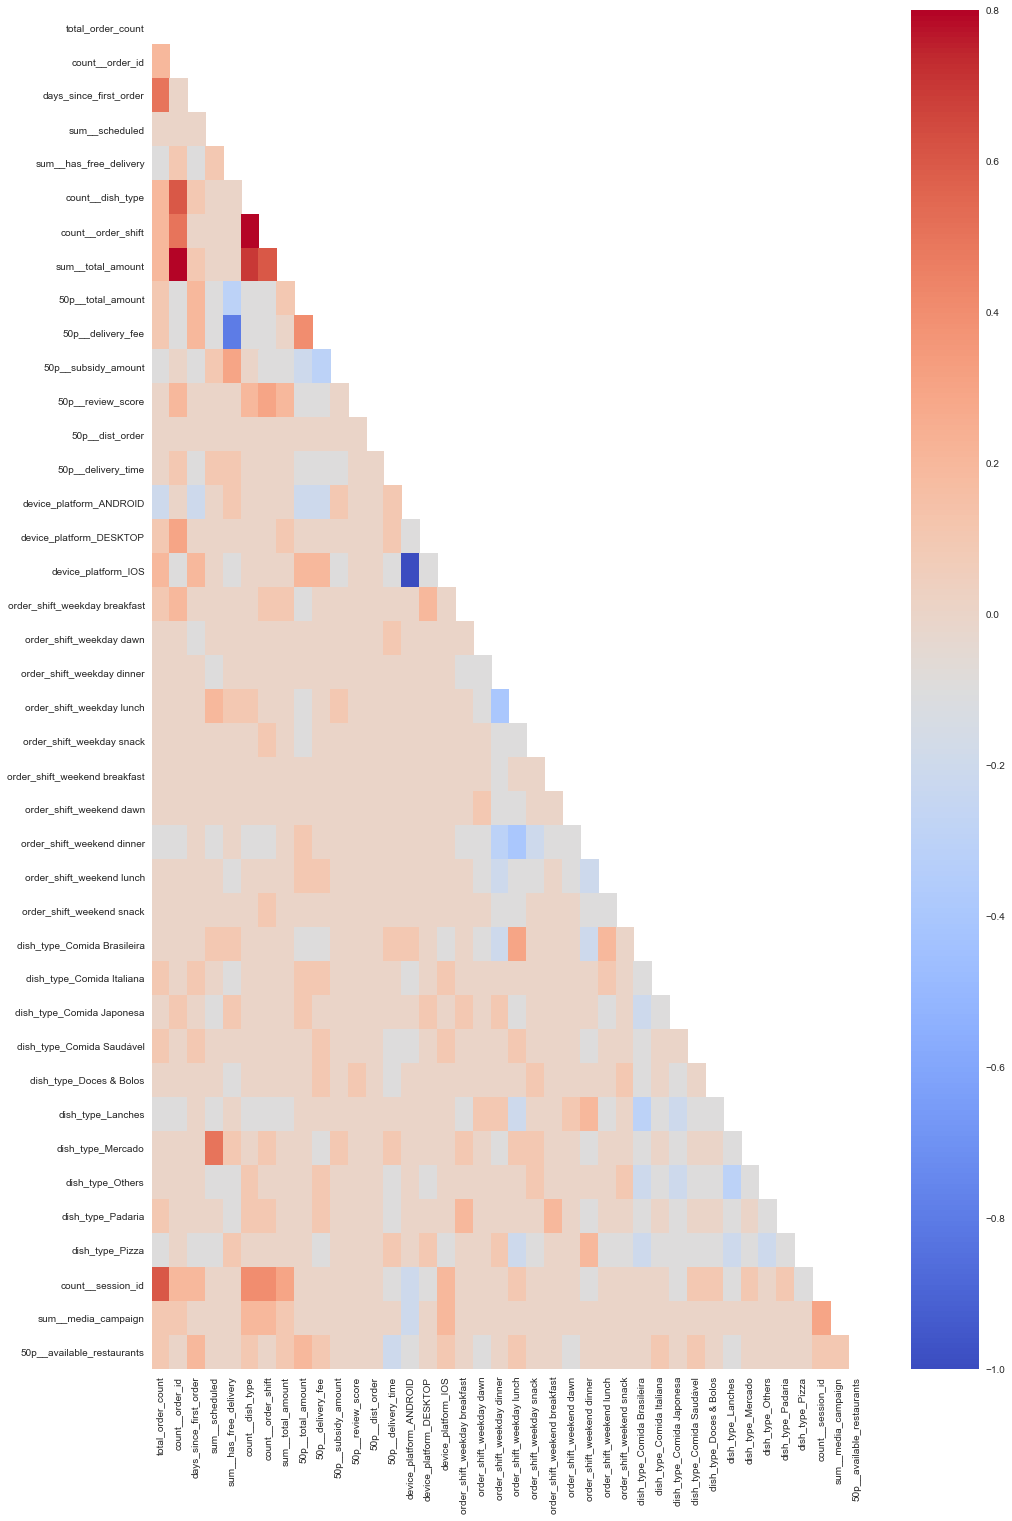

In [164]:
plt.figure(figsize=(16,25))
mask = np.triu(np.ones_like(df_cluster_robust.corr(), dtype=bool))

sns.heatmap(df_cluster_robust.corr().round(1), annot=False, mask=mask, cmap='coolwarm')
plt.show()

In [165]:
'''for col in df_cluster_scaled.columns[:]:
    fig, eixo = plt.subplots(1,2,figsize=(20,3))
    fig.suptitle(col, fontsize=16)
    sns.histplot(data =df_cluster_robust, x=col, ax=eixo[0], kde=True)
    sns.boxplot(data =df_cluster_robust, x=col, ax=eixo[1], showfliers=False)    
    
    plt.tight_layout()
    plt.show()'''

'for col in df_cluster_scaled.columns[:]:\n    fig, eixo = plt.subplots(1,2,figsize=(20,3))\n    fig.suptitle(col, fontsize=16)\n    sns.histplot(data =df_cluster_robust, x=col, ax=eixo[0], kde=True)\n    sns.boxplot(data =df_cluster_robust, x=col, ax=eixo[1], showfliers=False)    \n    \n    plt.tight_layout()\n    plt.show()'

## 8. Redução de Dimensionalidade <a name="reducao_dimensionalidade"></a>

### PCA

In [166]:
pca_rs = PCA(n_components=7)
pca_rs.fit(df_cluster_robust)

PCA(n_components=7)

In [167]:
res_pca_rs = pca_rs.fit_transform(df_cluster_robust)

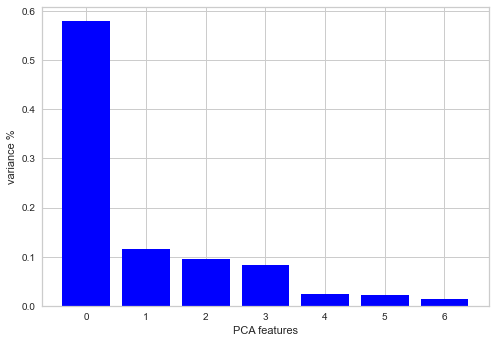

In [168]:
features = range(pca_rs.n_components_)
plt.bar(features, pca_rs.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

df_pca_rs = pd.DataFrame(res_pca_rs, index=df_cluster_robust.index, columns=[
    'PC'+(str(n+1)) for n in range(pca_rs.n_components_)])

In [169]:
df_pca_rs.head(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
account_id,,,,,,,
7c0450e7-a806-4208-8449-e4269a27e6b5,-0.550849,-4.092965,3.559486,13.832781,-1.238490,-1.162572,0.382062
61c051ee-d37c-45c6-8c22-c236db3b62b7,-0.858443,-2.417989,-1.235463,-1.623768,-1.240788,-1.094953,0.755405


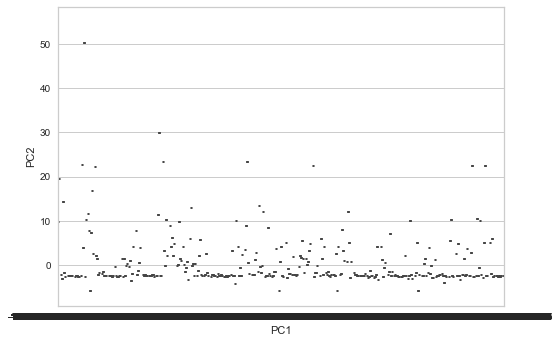

In [170]:
sns.boxplot(data=df_pca_rs, x='PC1', y='PC2');

### TSNE

In [171]:
tsne_rs = TSNE(learning_rate=50, n_components=3)
tsne_rs.fit(df_cluster_robust)

TSNE(learning_rate=50, n_components=3)

In [172]:
res_tsne_rs = tsne_rs.fit_transform(df_cluster_robust)
print(res_tsne_rs.shape)

(13904, 3)


In [173]:
df_tsne_rs = pd.DataFrame(res_tsne_rs, index=df_cluster.index, columns=['PC1', 'PC2', 'PC3'])

In [174]:
df_tsne_rs.head(2)

,PC1,PC2,PC3
account_id,,,
7c0450e7-a806-4208-8449-e4269a27e6b5,-13.751378,8.643694,-16.116343
61c051ee-d37c-45c6-8c22-c236db3b62b7,8.936234,-7.349771,9.228017


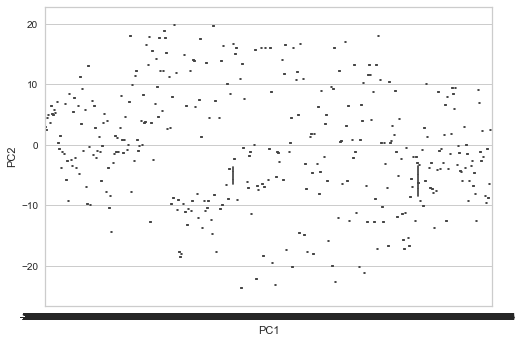

In [175]:
sns.boxplot(data=df_tsne_rs, x='PC1', y='PC2');

## 9. Segmentação <a name="clustering"></a>

Serão investigadas diferentes formas de se identificar o número de clusters ideal.

In [176]:
def elbowplot(df, elbowmetric, model):
    print("Elbow Score Plot (" + str(elbowmetric) + " metric):")
    vis = KElbowVisualizer(
        model, 
        k=(2,nK), 
        metric=elbowmetric,
        locate_elbow=True, 
        timings=False)
    vis.fit(df)      
    print("elbow value = optimal k:", f'{vis.elbow_value_:.0f}', \
            " | elbow score:", f'{vis.elbow_score_:,.3f}')
    vis.show()  

In [177]:
def elbowplot_metrics(df):
    # call elbow plot for each of 3 alternative metrics
    # distortion = mean sum of squared distances to center
    # silhouette = mean ratio of intra-cluster and nearest-cluster distance
    # calinski = ratio of within to between cluster dispersion
    
    model = KMeans(random_state=RNDN)
    _ = [elbowplot(df, m, model) for m in tqdm(["distortion", "silhouette", "calinski_harabasz"])]    

In [178]:
def inertia_plot(df):
    # kmeans: looking for the elbow - compare number of clusters by their inertia scores

    # run kMeans for alternative number of clusters k
    inertia_scores = [KMeans(
                    n_clusters=k, 
                    init='k-means++', 
                    n_init=10, max_iter=100, random_state=RNDN). \
                    fit(df).inertia_ \
                    for k in range(2,nK)]
    

    dict_inertia = dict(zip(range(2,nK), inertia_scores))

    # scree plot: look for elbow
    plt.figure(figsize=[8,5])
    plt.plot(range(2,nK), inertia_scores, color="blue")
    plt.title("inertia (sum of squared errors) vs. number of clusters")
    plt.xticks(np.arange(2,nK,1.0))
    plt.xlabel("number of clusters K")
    plt.ylabel("inertia");
    
    return(inertia_scores)

In [179]:
def find_Knee(df, inertia_scores):
    # inertia scores: confirm visual clue of elbow plot
    # KneeLocator class will detect elbows if curve is convex; if concavem will detect knees
    inertia_knee_a3 = KneeLocator(
        range(2,nK), 
        inertia_scores, 
        S=0.1, curve="convex", direction="decreasing")

    K_inertia_a3 = inertia_knee_a3.elbow 
    print("elbow at k =", f'{K_inertia_a3:.0f} clusters')

In [180]:
def find_silhuette_score(df):

    # find maximum silhouette score for up to kN clusters
    sil_scores = [silhouette_score(
                                df, 
                                KMeans(n_clusters=k, random_state=RNDN). \
                                fit_predict(df)) \
                                for k in tqdm(range(2,nK))]

    dict_sil = dict(zip(range(2,nK), sil_scores))
    print("silhouette scores:")
    _ = [print(k, ":", f'{v:,.3f}') for k,v in dict_sil.items()]
    K_sil_a3 = max(dict_sil, key=dict_sil.get)            # optimal clusters
    sil_opt_a3 = dict_sil[K_sil_a3]                       # optimal silhouette score
    print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

    plt.figure(figsize=[7,5])
    plt.plot(range(2,nK), sil_scores, color="red")
    plt.title("silhouette scores vs. number of clusters")
    plt.xticks(np.arange(2,nK,1))
    plt.xlabel("number of clusters K")
    plt.ylabel("silhouette score")
    plt.show()

In [181]:
def complete_silhouettes(df):
    # silhouette score plots with Yellowbrick
    dict_score = dict()
    fig, ax = plt.subplots(int(np.ceil(nK/2)-1), 2, figsize=(15,30))

    for i in tqdm(range(2,nK)):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=RNDN)
        q, mod = divmod(i, 2)
        vis = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod], is_fitted=False)
        vis.fit(df)
        vis.finalize()
        dict_score[i] = vis.silhouette_score_


    print("silhouette scores for k clusters:")
    _ = [print(k,":",f'{v:.3f}') for k,v in dict_score.items()]

    K_sil_a3 = max(dict_score, key=dict_score.get)          # optimal clusters
    sil_opt_a3 = dict_score[K_sil_a3]                       # optimal (maximal) silhouette score
    print("maximum silhouette score for", f'{K_sil_a3:.0f} clusters: ', f'{sil_opt_a3:.3f}')

Avaliaremos entre 2 e 11 clusters, utilizando um random_state=42.

In [182]:
RNDN = 42                   # random state
nK = 12                     # initial guess: clusters

#### PCA

  0%|          | 0/3 [00:00<?, ?it/s]

Elbow Score Plot (distortion metric):
elbow value = optimal k: 5  | elbow score: 537,859.160


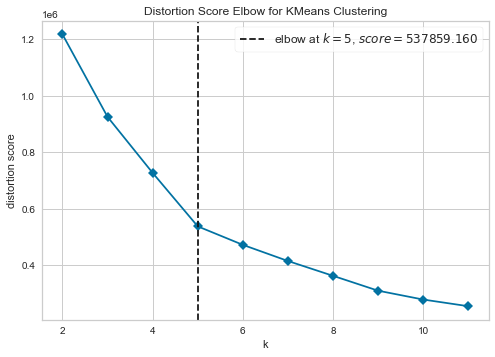

 33%|███▎      | 1/3 [00:03<00:06,  3.41s/it]

Elbow Score Plot (silhouette metric):
elbow value = optimal k: 2  | elbow score: 0.993


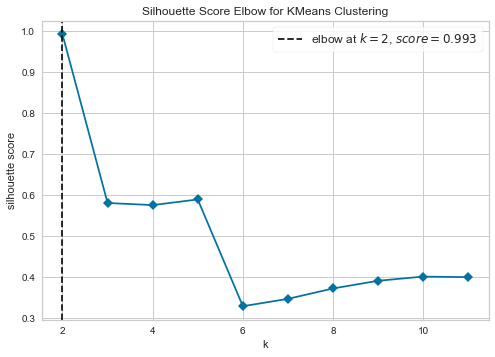

 67%|██████▋   | 2/3 [00:33<00:19, 19.35s/it]

Elbow Score Plot (calinski_harabasz metric):
elbow value = optimal k: 2  | elbow score: 22,540.141


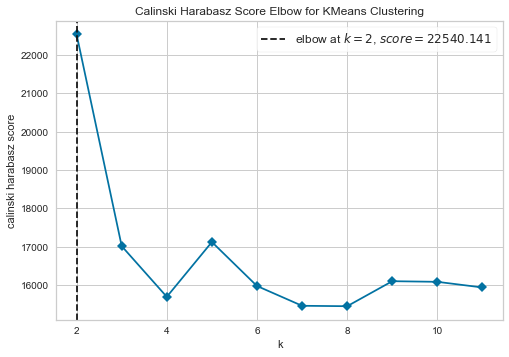

100%|██████████| 3/3 [00:37<00:00, 12.37s/it]


In [183]:
elbowplot_metrics(df_pca_rs)

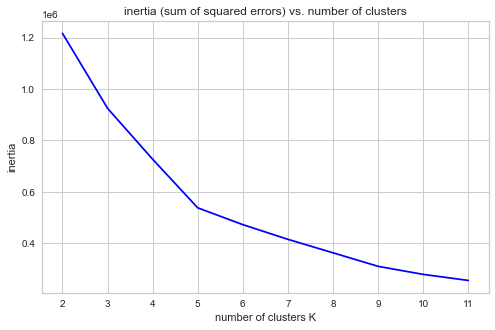

In [184]:
inertia_scores_rs_pca = inertia_plot(df_pca_rs)

In [185]:
find_Knee(df_pca_rs, inertia_scores_rs_pca)

elbow at k = 5 clusters


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

silhouette scores:
2 : 0.993
3 : 0.581
4 : 0.575
5 : 0.589
6 : 0.328
7 : 0.346
8 : 0.372
9 : 0.391
10 : 0.401
11 : 0.399
maximum silhouette score for 2 clusters:  0.993


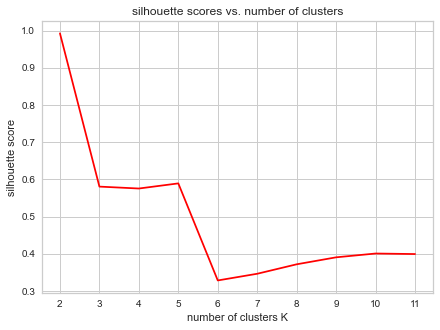

In [186]:
find_silhuette_score(df_pca_rs)

100%|██████████| 10/10 [00:55<00:00,  5.60s/it]


silhouette scores for k clusters:
2 : 0.993
3 : 0.581
4 : 0.575
5 : 0.589
6 : 0.328
7 : 0.346
8 : 0.372
9 : 0.391
10 : 0.401
11 : 0.399
maximum silhouette score for 2 clusters:  0.993


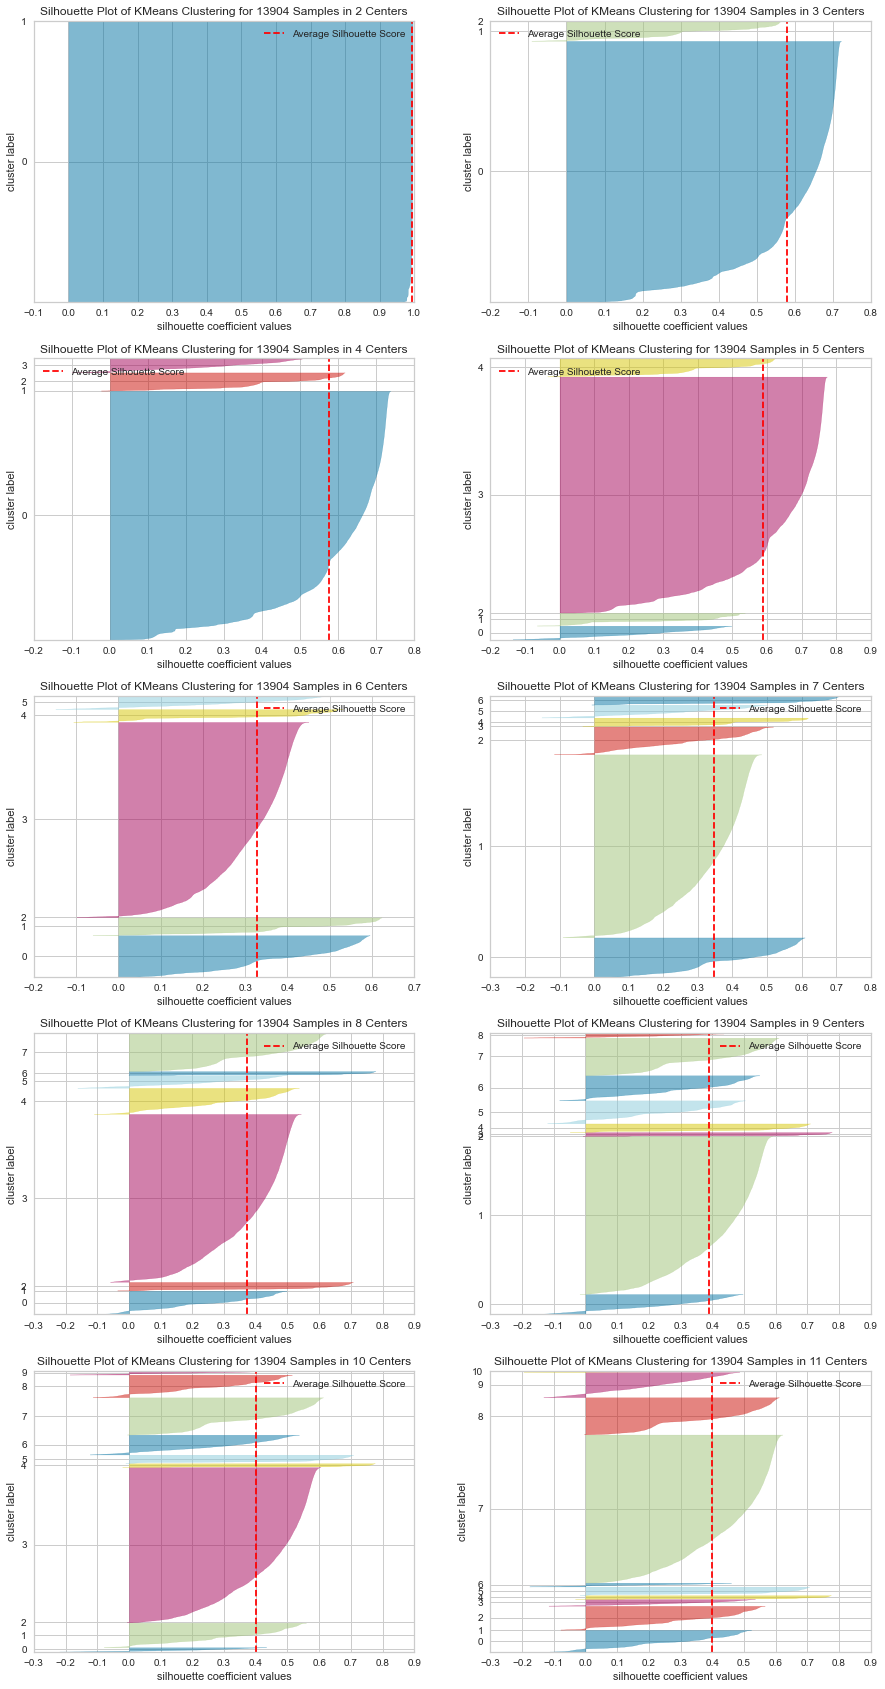

In [187]:
complete_silhouettes(df_pca_rs)

#### TSNE

  0%|          | 0/3 [00:00<?, ?it/s]

Elbow Score Plot (distortion metric):
elbow value = optimal k: 6  | elbow score: 1,140,860.109


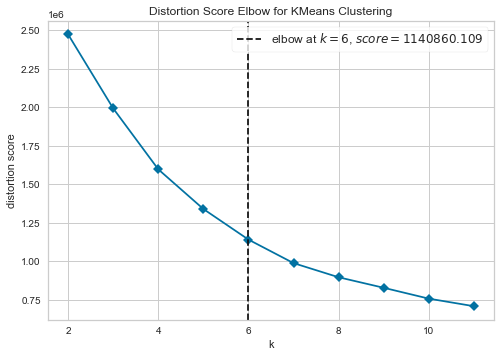

 33%|███▎      | 1/3 [00:04<00:09,  4.98s/it]

Elbow Score Plot (silhouette metric):
elbow value = optimal k: 2  | elbow score: 0.289


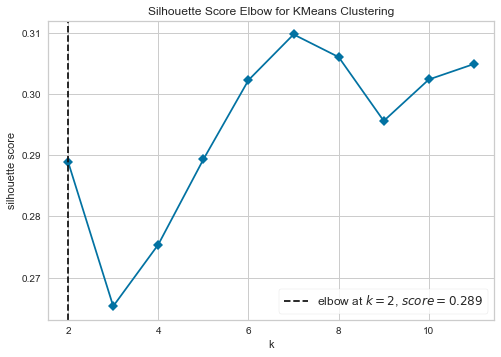

 67%|██████▋   | 2/3 [00:46<00:26, 26.21s/it]

Elbow Score Plot (calinski_harabasz metric):
elbow value = optimal k: 2  | elbow score: 6,233.184


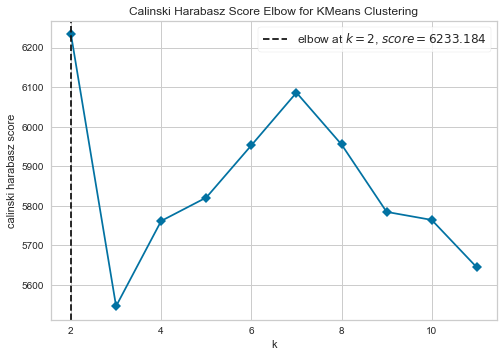

100%|██████████| 3/3 [00:50<00:00, 16.86s/it]


In [188]:
elbowplot_metrics(df_tsne_rs)

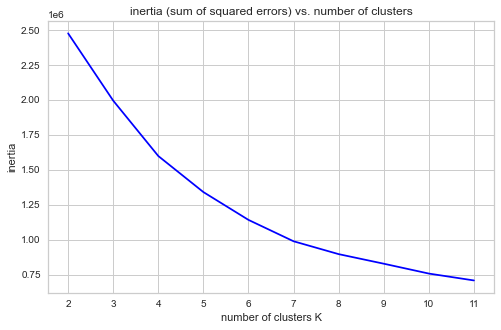

In [189]:
inertia_scores_rs_tsne = inertia_plot(df_tsne_rs)

In [190]:
find_Knee(df_tsne_rs, inertia_scores_rs_tsne)

elbow at k = 6 clusters


100%|██████████| 10/10 [00:42<00:00,  4.26s/it]


silhouette scores:
2 : 0.289
3 : 0.265
4 : 0.275
5 : 0.289
6 : 0.302
7 : 0.310
8 : 0.306
9 : 0.296
10 : 0.302
11 : 0.305
maximum silhouette score for 7 clusters:  0.310


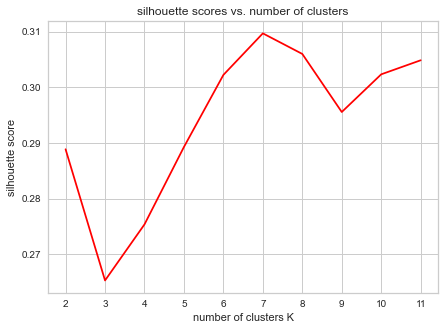

In [191]:
find_silhuette_score(df_tsne_rs)

100%|██████████| 10/10 [01:17<00:00,  7.76s/it]


silhouette scores for k clusters:
2 : 0.289
3 : 0.265
4 : 0.275
5 : 0.289
6 : 0.302
7 : 0.310
8 : 0.306
9 : 0.296
10 : 0.302
11 : 0.305
maximum silhouette score for 7 clusters:  0.310


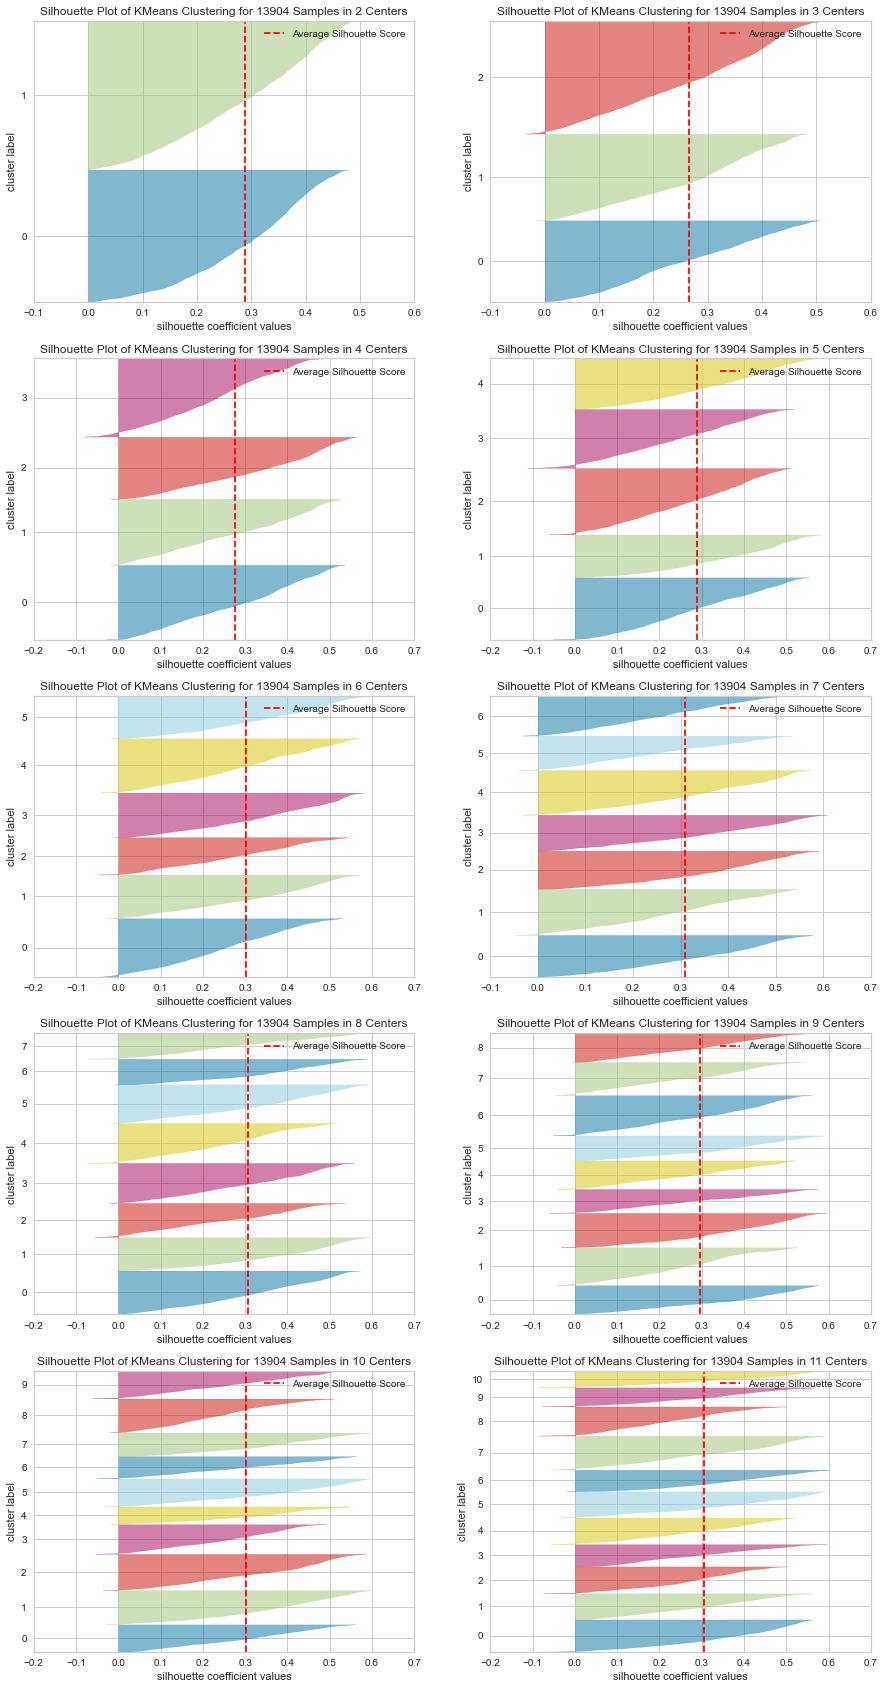

In [192]:
complete_silhouettes(df_tsne_rs)

### Produtização

Seguiremos a segmentação com:
- k = 7
- df = df_tsne_rs

In [193]:
K=7
df_selected = df_tsne_rs

KMeans

In [194]:
model_kmeans = KMeans(n_clusters=K, random_state=RNDN)
res_kmeans = model_kmeans.fit_predict(df_selected)

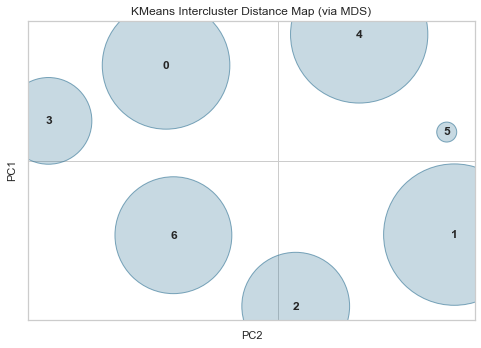

In [195]:
# optimal number of clusters: intercluster distances
visD = InterclusterDistance(
    model_kmeans, max_size=20000, legend=False, random_state=RNDN)
visD.fit(df_selected)
visD.finalize()

MeanShift

In [196]:
bw = estimate_bandwidth(df_selected, quantile=0.05)
print("bandwidth estimated by sklearn:", f'{bw:.2f}')

bandwidth estimated by sklearn: 8.32


In [197]:
model_meanshift = MeanShift(bandwidth=bw, bin_seeding=True)
res_meanshift = model_meanshift.fit_predict(df_selected)

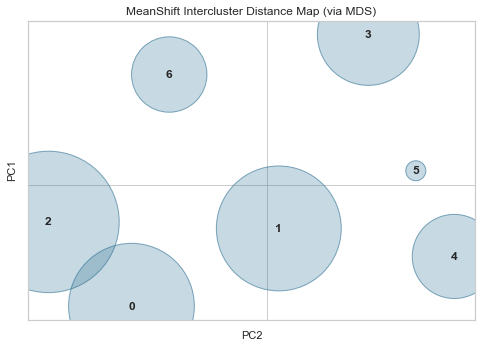

In [198]:
# optimal number of clusters: intercluster distances
visD = InterclusterDistance(
    model_meanshift, max_size=20000, legend=False, random_state=RNDN)
visD.fit(df_selected)
visD.finalize()

Dendogram

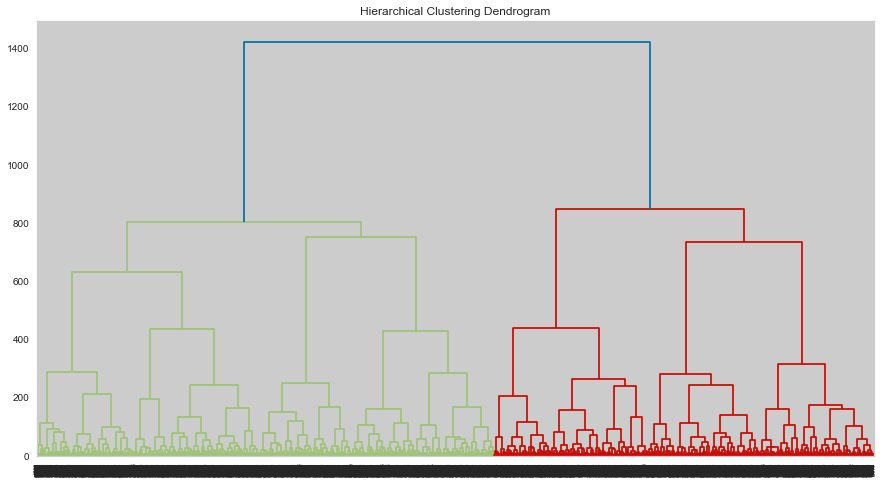

In [199]:
mergings = linkage(df_selected, method='ward')

plt.figure(figsize=(15,8))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(mergings,
           leaf_rotation=90
            )
plt.show()

In [200]:
res_dendrogram = fcluster(mergings, 500, criterion='distance')

Resultados

In [201]:
final_df = cluster_df.copy()

In [202]:
final_df['Cluster']=res_kmeans # res_kmeans, res_meanshift

In [203]:
sil_final = silhouette_score(df_selected, final_df["Cluster"])
print("silhouette score", f'{sil_final:.3f}')

silhouette score 0.310


In [204]:
final_df.head(2)

,ifood_status,ifood_status_last_month,total_order_count,days_since_first_order,registration_to_order_hrs,count__order_id,sum__total_amount,sum__scheduled,sum__has_free_delivery,count__restaurant_id,count__dish_type,count__order_shift,mean__total_amount,std__total_amount,min__total_amount,25p__total_amount,50p__total_amount,75p__total_amount,max__total_amount,mean__delivery_fee,std__delivery_fee,min__delivery_fee,25p__delivery_fee,50p__delivery_fee,75p__delivery_fee,max__delivery_fee,mean__subsidy_amount,std__subsidy_amount,min__subsidy_amount,25p__subsidy_amount,50p__subsidy_amount,75p__subsidy_amount,max__subsidy_amount,mean__review_score,std__review_score,min__review_score,25p__review_score,50p__review_score,75p__review_score,max__review_score,mean__nps_score,std__nps_score,min__nps_score,25p__nps_score,50p__nps_score,75p__nps_score,max__nps_score,mean__dist_order,std__dist_order,min__dist_order,25p__dist_order,50p__dist_order,75p__dist_order,max__dist_order,mean__delivery_time,std__delivery_time,min__delivery_time,25p__delivery_time,50p__delivery_time,75p__delivery_time,max__delivery_time,device_platform_ANDROID,device_platform_DESKTOP,device_platform_IOS,order_shift_weekday breakfast,order_shift_weekday dawn,order_shift_weekday dinner,order_shift_weekday lunch,order_shift_weekday snack,order_shift_weekend breakfast,order_shift_weekend dawn,order_shift_weekend dinner,order_shift_weekend lunch,order_shift_weekend snack,dish_type_Comida Brasileira,dish_type_Comida Italiana,dish_type_Comida Japonesa,dish_type_Comida Saudável,dish_type_Doces & Bolos,dish_type_Lanches,dish_type_Mercado,dish_type_Others,dish_type_Padaria,dish_type_Pizza,most_common__dish_type,most_common__state_label,most_common__order_shift,count__session_id,sum__media_campaign,mean__sum_view_restaurant_screen,std__sum_view_restaurant_screen,min__sum_view_restaurant_screen,25p__sum_view_restaurant_screen,50p__sum_view_restaurant_screen,75p__sum_view_restaurant_screen,max__sum_view_restaurant_screen,mean__sum_view_dish_screen,std__sum_view_dish_screen,min__sum_view_dish_screen,25p__sum_view_dish_screen,50p__sum_view_dish_screen,75p__sum_view_dish_screen,max__sum_view_dish_screen,mean__sum_click_add_item,std__sum_click_add_item,min__sum_click_add_item,25p__sum_click_add_item,50p__sum_click_add_item,75p__sum_click_add_item,max__sum_click_add_item,mean__sum_view_checkout,std__sum_view_checkout,min__sum_view_checkout,25p__sum_view_checkout,50p__sum_view_checkout,75p__sum_view_checkout,max__sum_view_checkout,mean__sum_callback_purchase,std__sum_callback_purchase,min__sum_callback_purchase,25p__sum_callback_purchase,50p__sum_callback_purchase,75p__sum_callback_purchase,max__sum_callback_purchase,mean__load_time,std__load_time,min__load_time,25p__load_time,50p__load_time,75p__load_time,max__load_time,mean__available_restaurants,std__available_restaurants,min__available_restaurants,25p__available_restaurants,50p__available_restaurants,75p__available_restaurants,max__available_restaurants,mean__session_duration,std__session_duration,min__session_duration,25p__session_duration,50p__session_duration,75p__session_duration,max__session_duration,Cluster
account_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7c0450e7-a806-4208-8449-e4269a27e6b5,Inactive,Inactive,8,851.560217,624.0,2,11238.75,0.5,1.0,2,2,2,5619.375,3897.042248,2863.75,4241.5625,5619.375,6997.1875,8375.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,5.0,5.0,5.0,5.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,1.624331,0.847916,1.024764,1.324548,1.624331,1.924115,2.223899,2.128187,1.540539,1.038862,1.583524,2.128187,2.67285,3.217512,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,Lanches,RJ,weekday snack,72,1,2.222222,3.374395,0.0,0.0,1.0,2.25,17.0,1.583333,3.376597,0.0,0.0,0.0,1.0,15.0,0.500000,1.472757,0.0,0.0,0.0,0.0,9.0,0.791667,2.162012,0.0,0.0,0.0,0

## 10. Resultados <a name="results"></a>

In [205]:
features_cluster_analysis = [
 'Cluster',
 'ifood_status',
 'ifood_status_last_month',
 'total_order_count',
 'count__order_id',
 'days_since_first_order',
 'registration_to_order_hrs',
 'sum__scheduled',
 'sum__has_free_delivery',
# 'sum__subsidy_amount',
 'count__restaurant_id',
 'count__dish_type',
 'count__order_shift',
 'sum__total_amount',
# 'mean__total_amount',
# 'std__total_amount',
# 'min__total_amount',
# '25p__total_amount',
 '50p__total_amount',
# '75p__total_amount',
# 'max__total_amount',
# 'mean__delivery_fee',
# 'std__delivery_fee',
# 'min__delivery_fee',
# '25p__delivery_fee',
 '50p__delivery_fee',
# '75p__delivery_fee',
# 'max__delivery_fee',
# 'mean__subsidy_amount',
# 'std__subsidy_amount',
# 'min__subsidy_amount',
# '25p__subsidy_amount',
  '50p__subsidy_amount',
# '75p__subsidy_amount',
# 'max__subsidy_amount',
# 'mean__review_score',
# 'std__review_score',
# 'min__review_score',
# '25p__review_score',
 '50p__review_score',
# '75p__review_score',
# 'max__review_score',
# 'mean__nps_score',
# 'std__nps_score',
# 'min__nps_score',
# '25p__nps_score',
 '50p__nps_score',
# '75p__nps_score',
# 'max__nps_score',
# 'mean__dist_order',
# 'std__dist_order',
# 'min__dist_order',
# '25p__dist_order',
 '50p__dist_order',
# '75p__dist_order',
# 'max__dist_order',
# 'mean__delivery_time',
# 'std__delivery_time',
# 'min__delivery_time',
# '25p__delivery_time',
 '50p__delivery_time',
# '75p__delivery_time',
# 'max__delivery_time',
 'device_platform_ANDROID',
 'device_platform_DESKTOP',
 'device_platform_IOS',
 'order_shift_weekday breakfast',
 'order_shift_weekday dawn',
 'order_shift_weekday dinner',
 'order_shift_weekday lunch',
 'order_shift_weekday snack',
 'order_shift_weekend breakfast',
 'order_shift_weekend dawn',
 'order_shift_weekend dinner',
 'order_shift_weekend lunch',
 'order_shift_weekend snack',
 'dish_type_Comida Brasileira',
 'dish_type_Comida Italiana',
 'dish_type_Comida Japonesa',
 'dish_type_Comida Saudável',
 'dish_type_Doces & Bolos',
 'dish_type_Lanches',
 'dish_type_Mercado',
 'dish_type_Others',
 'dish_type_Padaria',
 'dish_type_Pizza',
 'most_common__dish_type',
 'most_common__state_label',
 'most_common__order_shift',
 'count__session_id',
 'sum__media_campaign',
# 'mean__sum_view_restaurant_screen',
# 'std__sum_view_restaurant_screen',
# 'min__sum_view_restaurant_screen',
# '25p__sum_view_restaurant_screen',
 '50p__sum_view_restaurant_screen',
# '75p__sum_view_restaurant_screen',
# 'max__sum_view_restaurant_screen',
# 'mean__sum_view_dish_screen',
# 'std__sum_view_dish_screen',
# 'min__sum_view_dish_screen',
# '25p__sum_view_dish_screen',
 '50p__sum_view_dish_screen',
# '75p__sum_view_dish_screen',
# 'max__sum_view_dish_screen',
# 'mean__sum_click_add_item',
# 'std__sum_click_add_item',
# 'min__sum_click_add_item',
# '25p__sum_click_add_item',
 '50p__sum_click_add_item',
# '75p__sum_click_add_item',
# 'max__sum_click_add_item',
# 'mean__sum_view_checkout',
# 'std__sum_view_checkout',
# 'min__sum_view_checkout',
# '25p__sum_view_checkout',
# '50p__sum_view_checkout',
# '75p__sum_view_checkout',
# 'max__sum_view_checkout',
# 'mean__sum_callback_purchase',
# 'std__sum_callback_purchase',
# 'min__sum_callback_purchase',
# '25p__sum_callback_purchase',
# '50p__sum_callback_purchase',
# '75p__sum_callback_purchase',
# 'max__sum_callback_purchase',
# 'mean__load_time',
# 'std__load_time',
# 'min__load_time',
# '25p__load_time',
# '50p__load_time',
# '75p__load_time',
# 'max__load_time',
# 'mean__available_restaurants',
# 'std__available_restaurants',
# 'min__available_restaurants',
# '25p__available_restaurants',
 '50p__available_restaurants',
# '75p__available_restaurants',
# 'max__available_restaurants',
# 'mean__session_duration',
# 'std__session_duration',
# 'min__session_duration',
# '25p__session_duration',
 '50p__session_duration',
# '75p__session_duration'#,
# 'max__session_duration'
]

In [206]:
df_final = final_df[features_cluster_analysis]

In [207]:
df_final.head(2)

,Cluster,ifood_status,ifood_status_last_month,total_order_count,count__order_id,days_since_first_order,registration_to_order_hrs,sum__scheduled,sum__has_free_delivery,count__restaurant_id,count__dish_type,count__order_shift,sum__total_amount,50p__total_amount,50p__delivery_fee,50p__subsidy_amount,50p__review_score,50p__nps_score,50p__dist_order,50p__delivery_time,device_platform_ANDROID,device_platform_DESKTOP,device_platform_IOS,order_shift_weekday breakfast,order_shift_weekday dawn,order_shift_weekday dinner,order_shift_weekday lunch,order_shift_weekday snack,order_shift_weekend breakfast,order_shift_weekend dawn,order_shift_weekend dinner,order_shift_weekend lunch,order_shift_weekend snack,dish_type_Comida Brasileira,dish_type_Comida Italiana,dish_type_Comida Japonesa,dish_type_Comida Saudável,dish_type_Doces & Bolos,dish_type_Lanches,dish_type_Mercado,dish_type_Others,dish_type_Padaria,dish_type_Pizza,most_common__dish_type,most_common__state_label,most_common__order_shift,count__session_id,sum__media_campaign,50p__sum_view_restaurant_screen,50p__sum_view_dish_screen,50p__sum_click_add_item,50p__available_restaurants,50p__session_duration
account_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7c0450e7-a806-4208-8449-e4269a27e6b5,4,Inactive,Inactive,8,2,851.560217,624.0,0.5,1.0,2,2,2,11238.75,5619.375,0.0,0.0,5.0,10.0,1.624331,2.128187,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0,0.0,0.0,Lanches,RJ,weekday snack,72,1,1.0,0.0,0.0,549.5,8.026575
61c051ee-d37c-45c6-8c22-c236db3b62b7,6,Active,Active,206,5,1395.560217,0.0,0.8,0.8,4,2,2,12120.00,1873.750,0.0,0.0,5.0,10.0,1.111949,1.578095,1.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.2,0.0,0.8,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,Comida Brasileira,SP,weekday lunch,113,0,0.0,1.0,1.0,429.0,7.135083


In [208]:
def cluster_pies(df):
    
    # number of categorical variables
    cat_features = ['ifood_status', 'ifood_status_last_month', 'most_common__dish_type', 'most_common__state_label', 
                    'most_common__order_shift']

    c = len(cat_features)
    
    # number of clusters
    K = df["Cluster"].nunique()

    for k in tqdm(range(K)):
        dfc = df[df["Cluster"]==k]
        total = dfc["total_order_count"].median()
        orders = dfc["count__order_id"].median()
        amount = dfc["50p__total_amount"].median()
        cases = dfc.shape[0]

        fig = plt.figure(figsize=(20, 8))
        fig.suptitle("Cluster " + str(k) + ": " + \
            f'{cases:,.0f}' + " cases | " + \
            "median orders " + f'{orders:.2f}' + \
            " | median total orders " + f'{total:.2f}' + \
            " | median amount " + f'{amount:.0f}')

        ax1 = plt.subplot2grid((2,c),(0,0))
        plt.pie(dfc["ifood_status"].value_counts(), labels=dfc["ifood_status"].value_counts().index)
        plt.title("ifood_status");

        ax1 = plt.subplot2grid((2,c),(0,1))
        plt.pie(dfc["ifood_status_last_month"].value_counts(), labels=dfc["ifood_status_last_month"].value_counts().index)
        plt.title("ifood_status_last_month");

        ax1 = plt.subplot2grid((2,c),(0,2))
        plt.pie(dfc["most_common__dish_type"].value_counts(), labels=dfc["most_common__dish_type"].value_counts().index)
        plt.title("most_common__dish_type");

        ax1 = plt.subplot2grid((2,c),(0,3))
        plt.pie(dfc["most_common__state_label"].value_counts(), labels=dfc["most_common__state_label"].value_counts().index)
        plt.title("most_common__state_label");

        ax1 = plt.subplot2grid((2,c),(0,4))
        plt.pie(dfc["most_common__order_shift"].value_counts(), labels=dfc["most_common__order_shift"].value_counts().index)
        plt.title("most_common__order_shift");

In [209]:
object_list = ['ifood_status', 'ifood_status_last_month', 'most_common__dish_type', 'most_common__state_label',
       'most_common__order_shift']
numeric_list = ['total_order_count', 'count__order_id', 'days_since_first_order',
                'registration_to_order_hrs', 'sum__scheduled', 'sum__has_free_delivery',
                'count__restaurant_id', 'count__dish_type',
                'count__order_shift', 'sum__total_amount', '50p__total_amount',
                '50p__delivery_fee', '50p__subsidy_amount',
                '50p__review_score', '50p__nps_score', '50p__dist_order',
                '50p__delivery_time', 'device_platform_ANDROID',
                'device_platform_DESKTOP', 'device_platform_IOS',
                'order_shift_weekday breakfast', 'order_shift_weekday dawn',
                'order_shift_weekday dinner', 'order_shift_weekday lunch',
                'order_shift_weekday snack', 'order_shift_weekend breakfast',
                'order_shift_weekend dawn', 'order_shift_weekend dinner',
                'order_shift_weekend lunch', 'order_shift_weekend snack',
                'dish_type_Comida Brasileira', 'dish_type_Comida Italiana',
                'dish_type_Comida Japonesa', 'dish_type_Comida Saudável',
                'dish_type_Doces & Bolos', 'dish_type_Lanches', 'dish_type_Mercado',
                'dish_type_Others', 'dish_type_Padaria', 'dish_type_Pizza',
                'count__session_id', 'sum__media_campaign',
                '50p__sum_view_restaurant_screen', '50p__sum_view_dish_screen',
                '50p__sum_click_add_item', '50p__available_restaurants',
                '50p__session_duration']

In [210]:
def plot_cluster_features(df):
    for column in df.columns[1:]:
        if column in object_list:
            plt.figure(figsize=(20, 4))
            sns.countplot(data=df, hue=column, x='Cluster')
        if column in numeric_list:
            plt.figure(figsize=(20, 4))
            sns.boxplot(data=df, y=column, x='Cluster', showfliers=False)

In [211]:
# helper function: medians and modes for each cluster
def cluster_profile(df):
    dfc = df.groupby("Cluster").agg({ 
        "ifood_status": lambda x: x.value_counts().index[0],
        "ifood_status_last_month": lambda x: x.value_counts().index[0],
        "total_order_count": "median",
        "days_since_first_order": "median",
        "registration_to_order_hrs": "median",
        "count__order_id": "median",
        "sum__total_amount": "median",
        "sum__scheduled": "median",
        "sum__has_free_delivery": "median",
        "count__restaurant_id": "median",
        "count__dish_type": "median",
        "count__order_shift": "median",
        "50p__total_amount": "median",
        "50p__delivery_fee": "median",
        "50p__subsidy_amount": "median",
        "50p__review_score": "median",
        "50p__nps_score": "median",
        "50p__dist_order": "median",
        "50p__delivery_time": "median",
        "device_platform_ANDROID": "median",
        "device_platform_DESKTOP": "median",
        "device_platform_IOS": "median",
        "order_shift_weekday breakfast": "median",
        "order_shift_weekday dawn": "median",
        "order_shift_weekday dinner": "median",
        "order_shift_weekday lunch": "median",
        "order_shift_weekday snack": "median",
        "order_shift_weekend breakfast": "median",
        "order_shift_weekend dawn": "median",
        "order_shift_weekend dinner": "median",
        "order_shift_weekend lunch": "median",
        "order_shift_weekend snack": "median",
        "dish_type_Comida Brasileira": "median",
        "dish_type_Comida Italiana": "median",
        "dish_type_Comida Japonesa": "median",
        "dish_type_Comida Saudável": "median",
        "dish_type_Doces & Bolos": "median",
        "dish_type_Lanches": "median",
        "dish_type_Mercado": "median",
        "dish_type_Others": "median",
        "dish_type_Padaria": "median",
        "dish_type_Pizza": "median",
        "most_common__dish_type": lambda x: x.value_counts().index[0],
        "most_common__state_label": lambda x: x.value_counts().index[0],
        "most_common__order_shift": lambda x: x.value_counts().index[0],
        "count__session_id": "median",
        "sum__media_campaign": "median",
        "50p__sum_view_restaurant_screen": "median",
        "50p__sum_view_dish_screen": "median",
        "50p__sum_click_add_item": "median",
        "50p__available_restaurants": "median",
        "50p__session_duration": "median"
    })    
    

    cluster_pies(df)
    plot_cluster_features(df)
    return dfc

100%|██████████| 7/7 [00:00<00:00,  7.35it/s]


Cluster,0,1,2,3,4,5,6
ifood_status,Active,Active,Active,Active,Active,Active,Active
ifood_status_last_month,Active,Active,Active,Active,Active,Active,Active
total_order_count,310,251,345,465,350,223,345
days_since_first_order,1819.560217,1708.560217,1857.560217,1860.560217,1817.560217,1601.560217,1913.560217
registration_to_order_hrs,0.0,0.0,0.0,0.0,0.0,0.0,0.0
count__order_id,5,2,2,57,10,2,3
sum__total_amount,39001.25,10023.75,11862.5,342167.5,56637.5,14930.625,23016.25
sum__scheduled,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sum__has_free_delivery,0.5,0.4,0.333333,0.454545,0.444444,0.666667,0.285714
count__restaurant_id,4,1,2,25,7,2,3


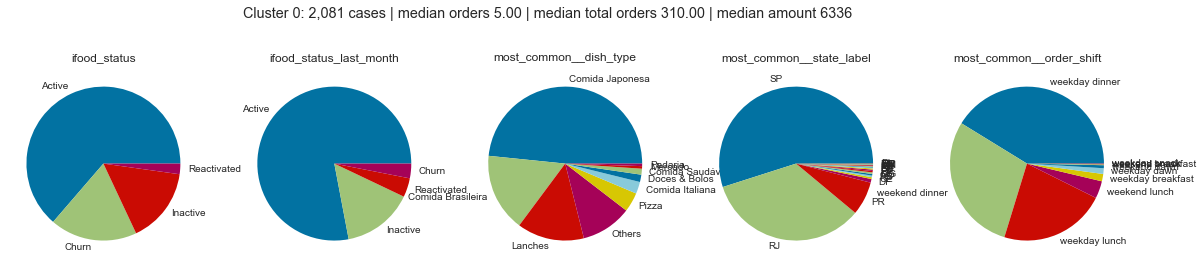

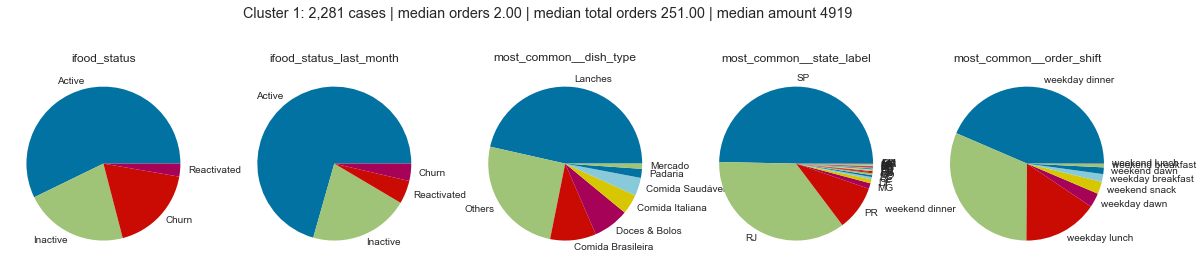

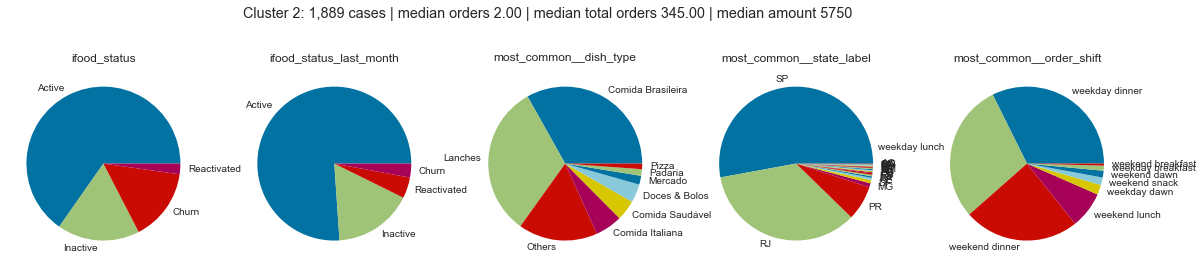

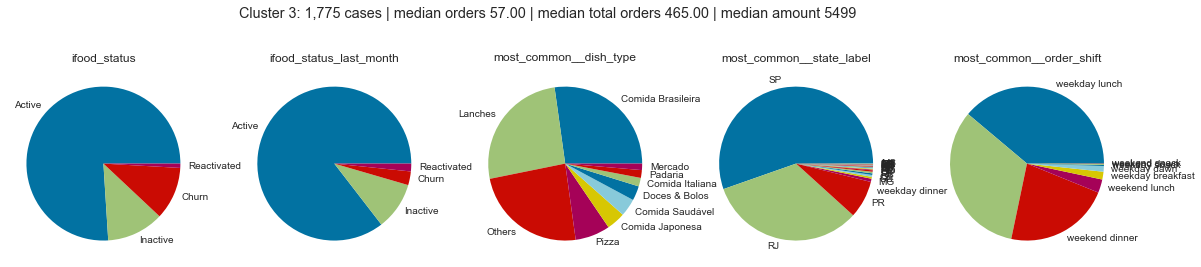

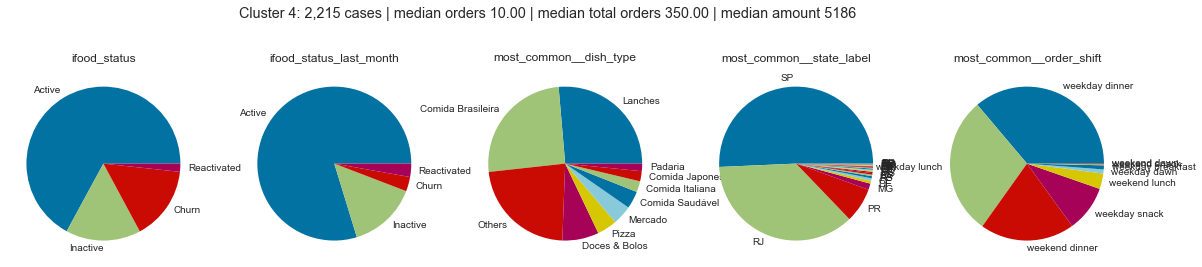

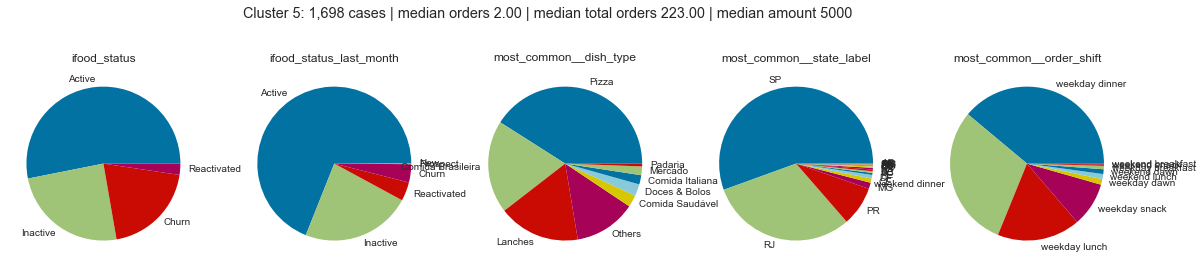

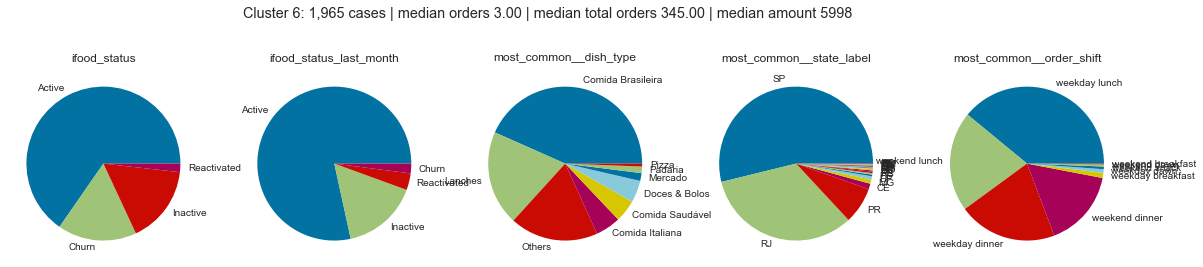

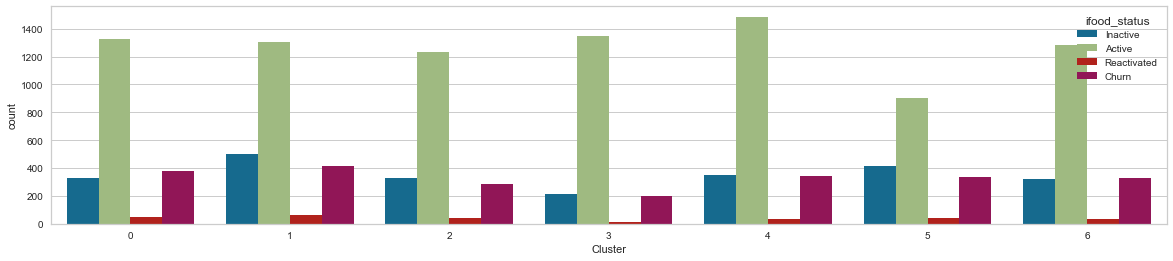

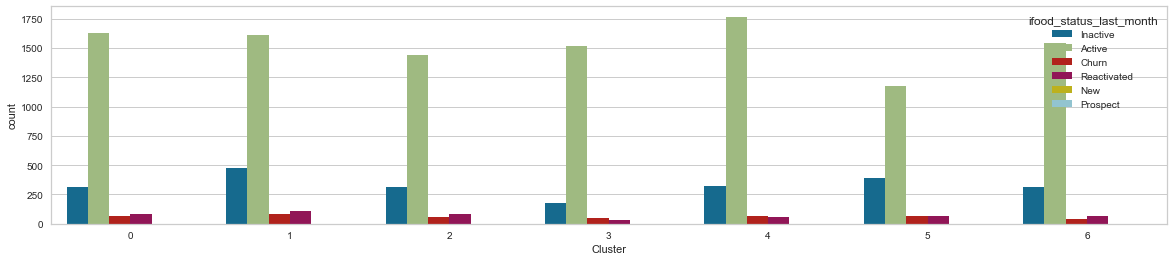

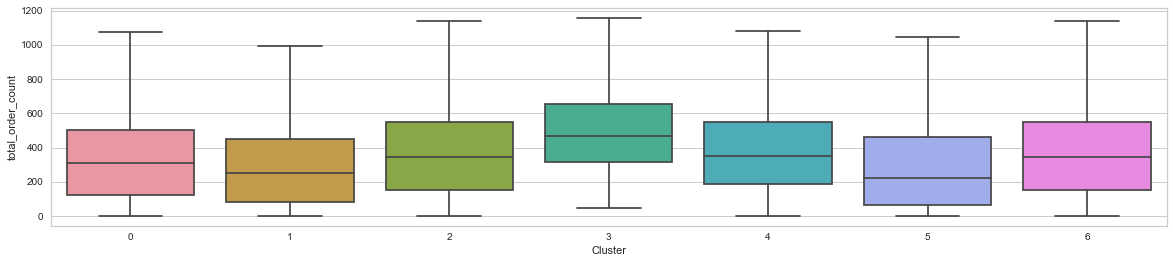

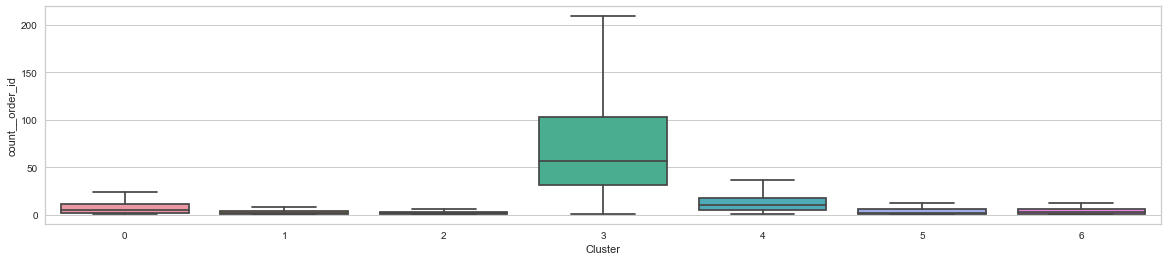

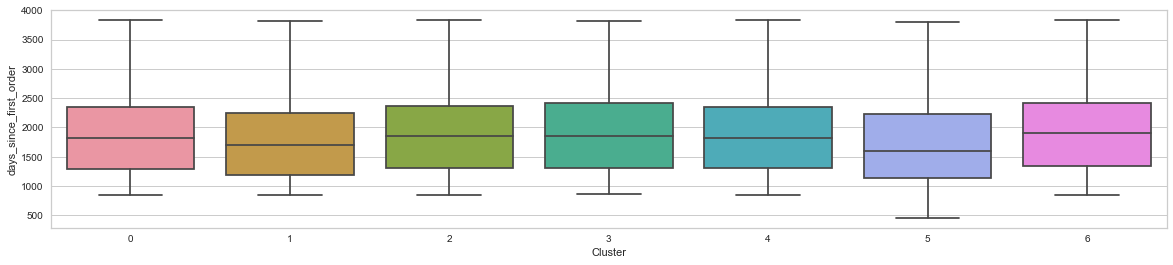

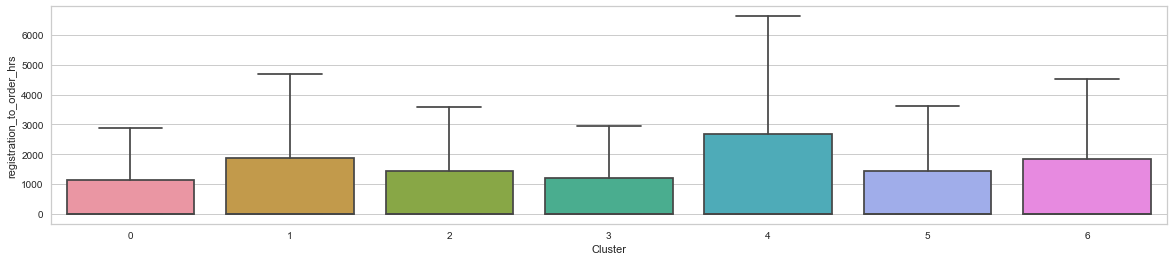

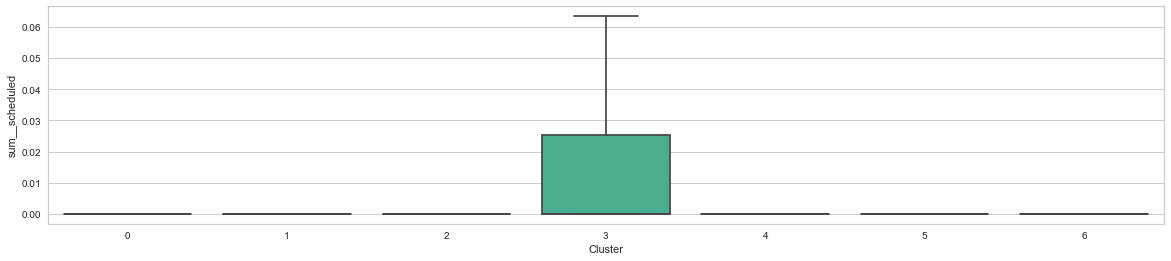

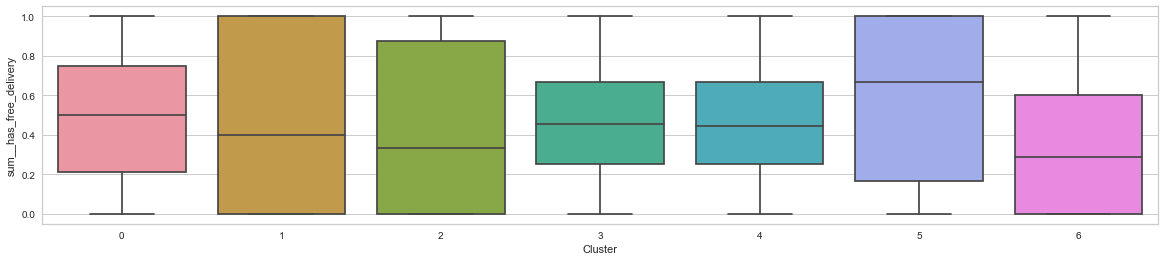

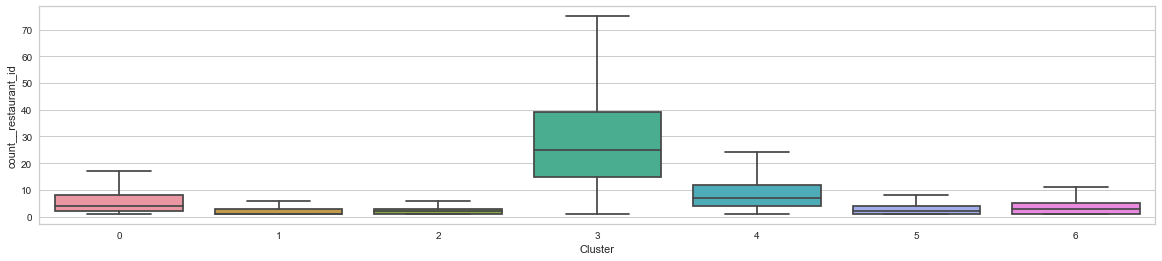

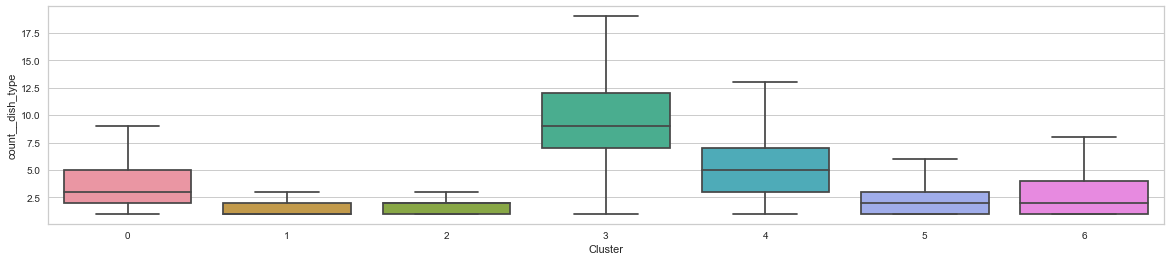

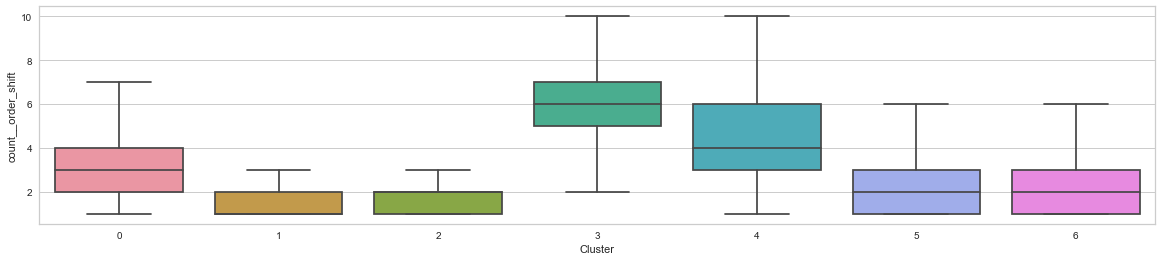

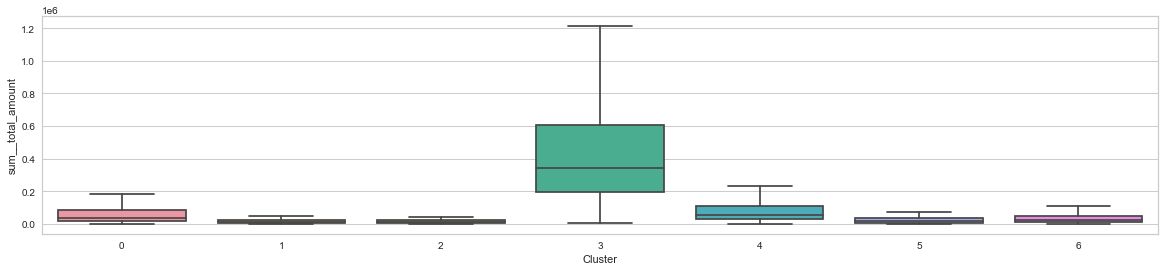

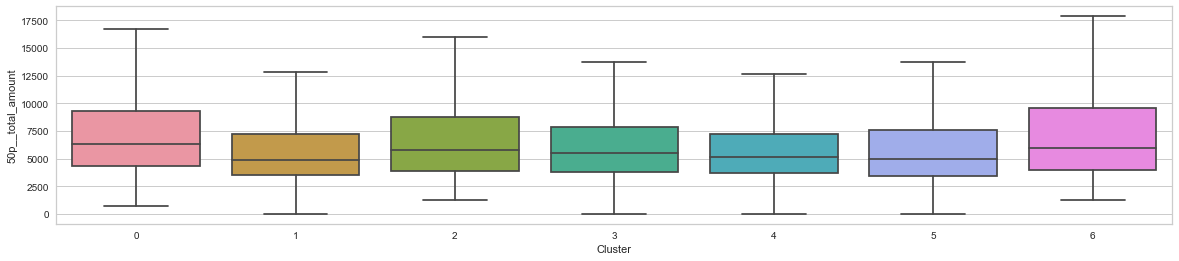

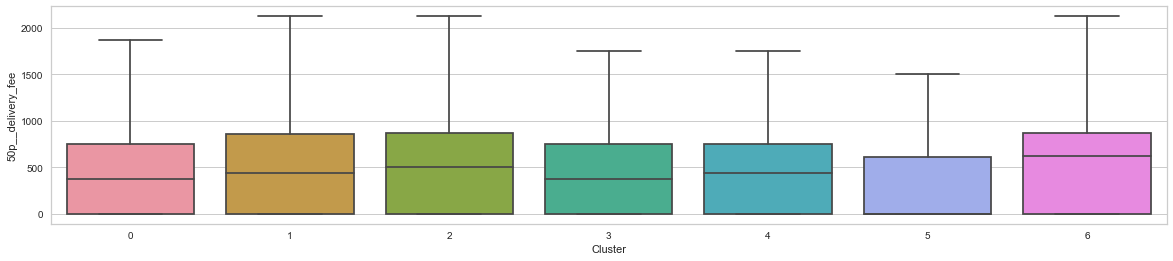

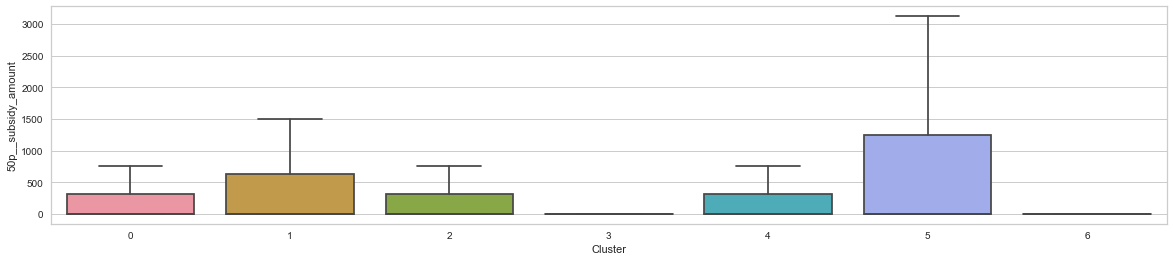

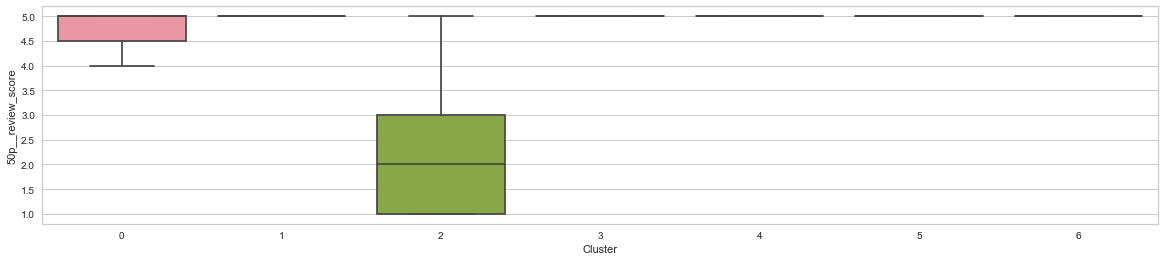

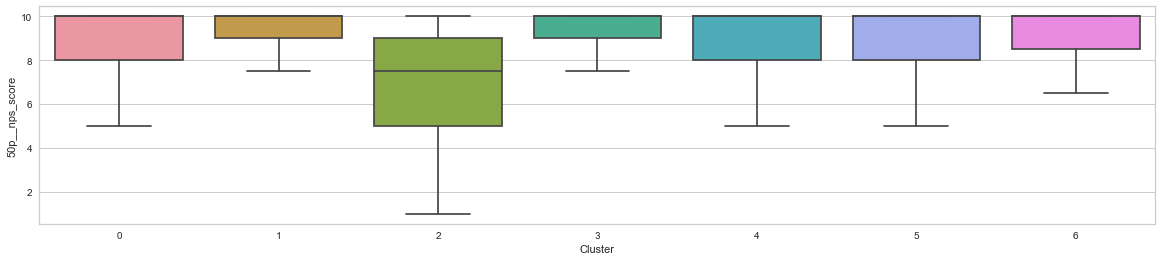

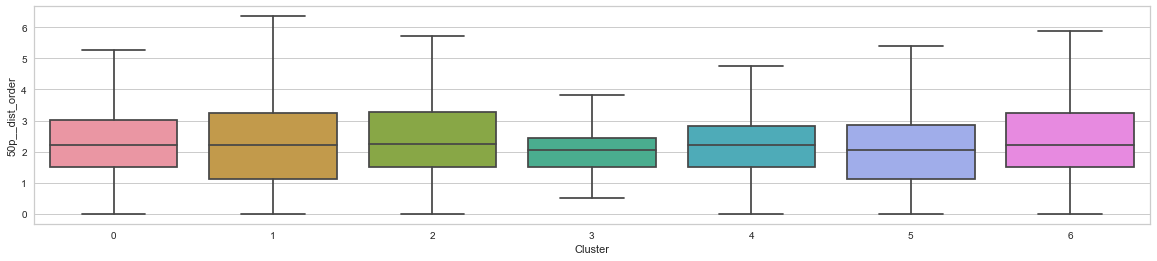

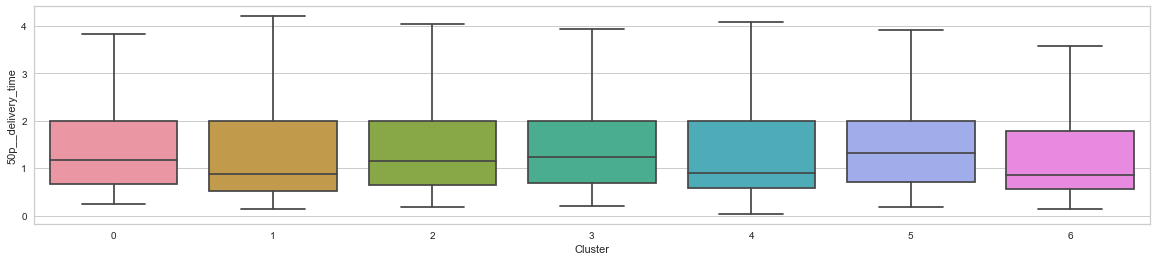

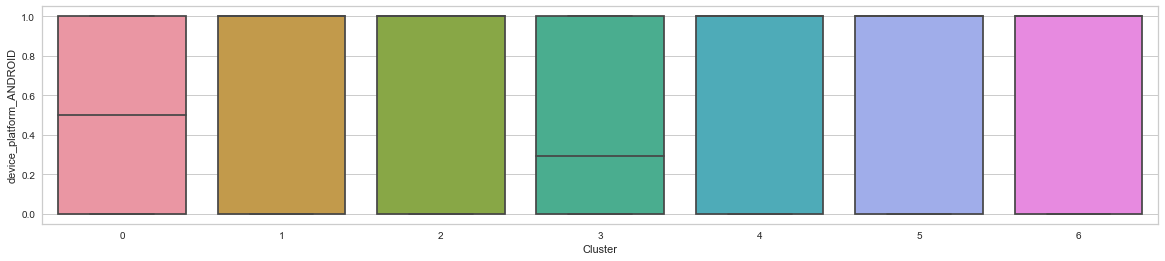

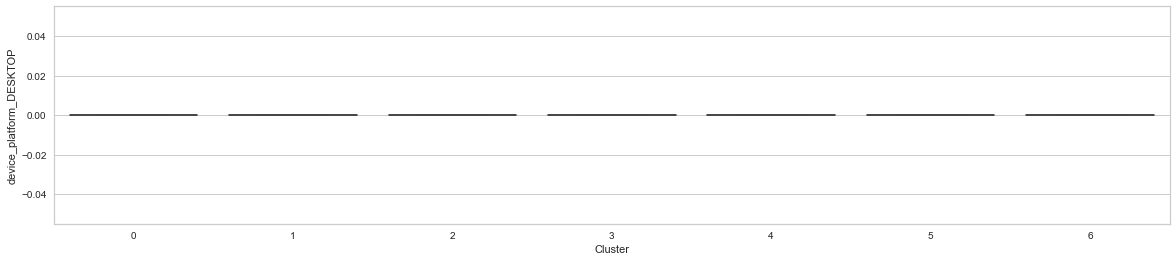

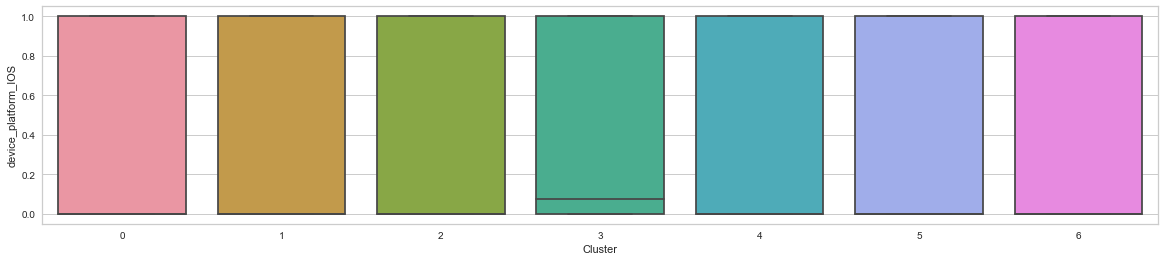

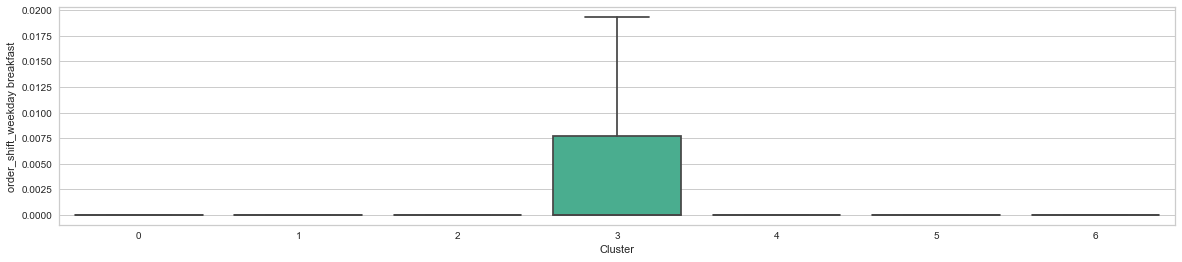

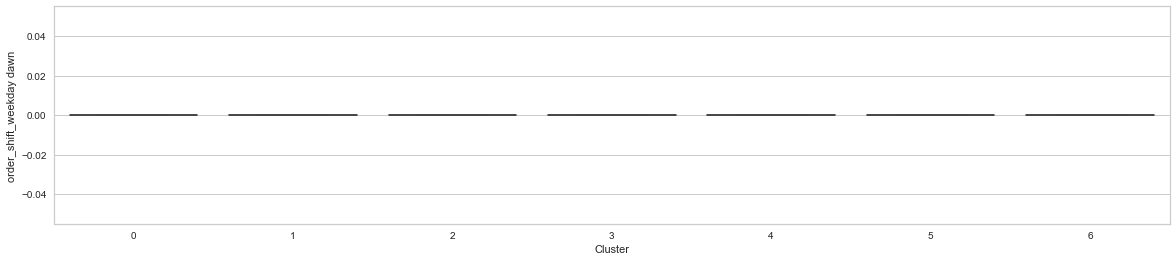

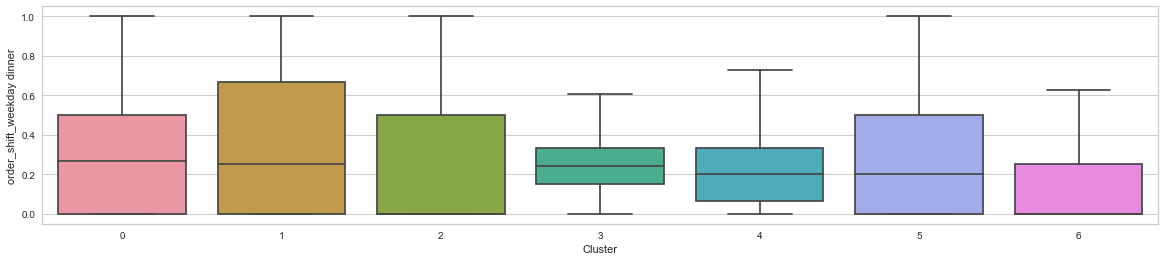

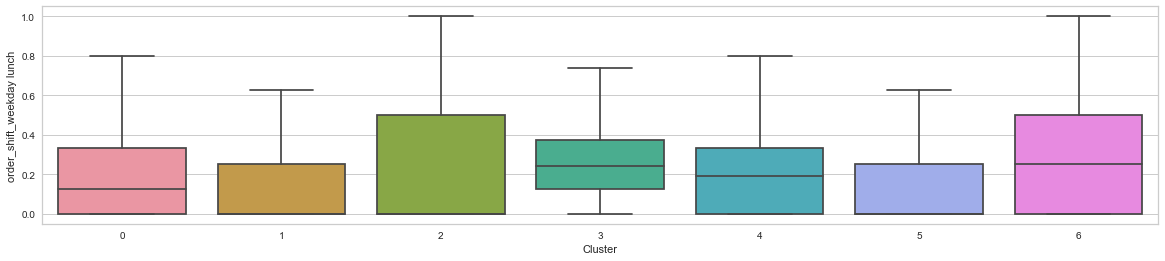

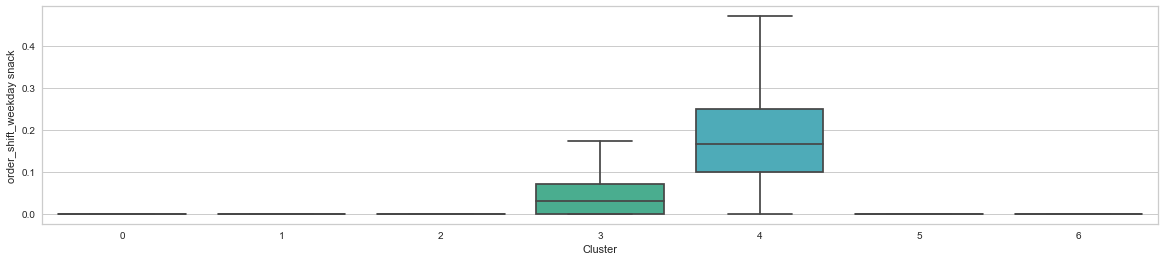

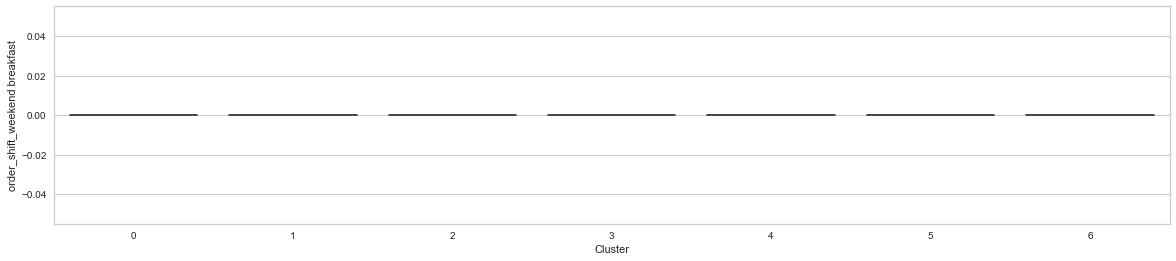

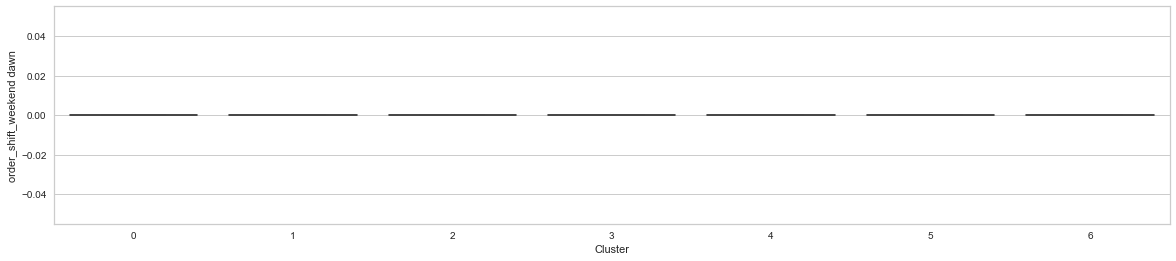

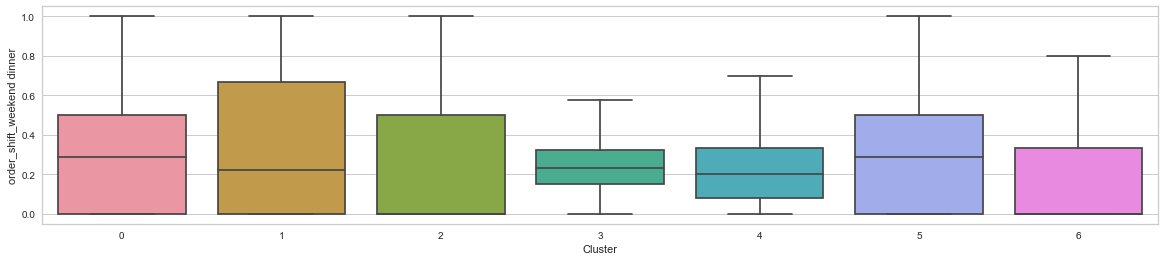

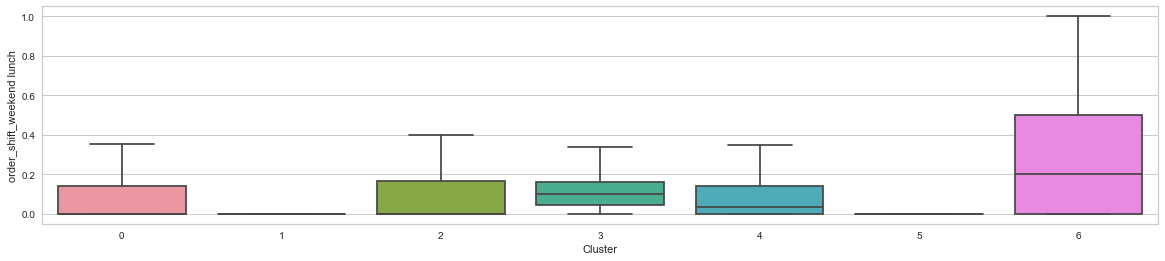

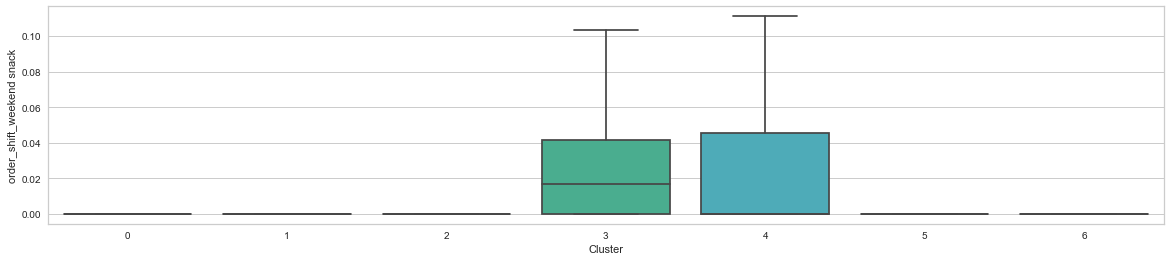

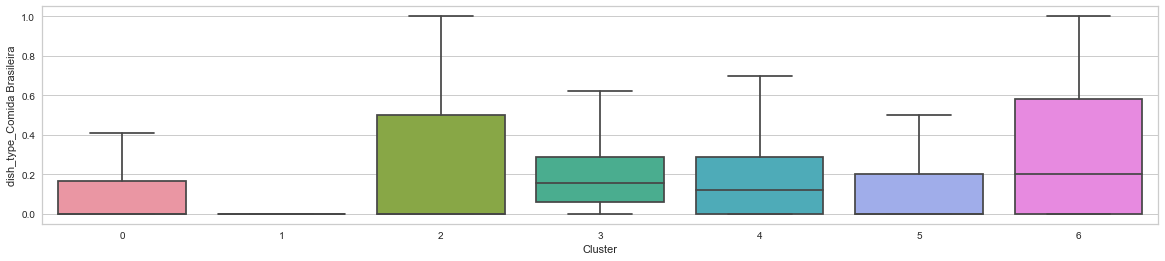

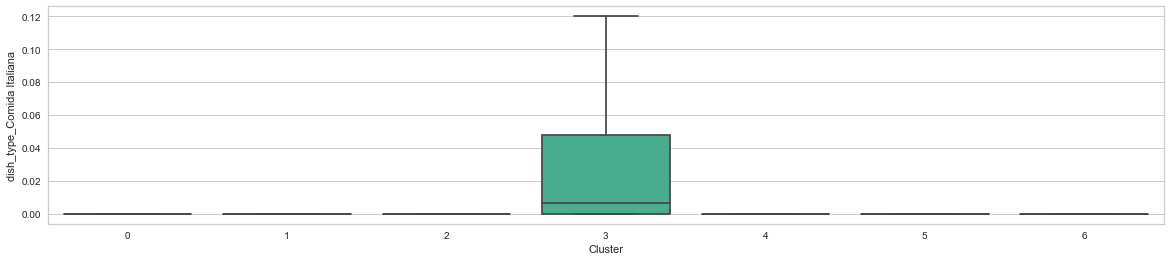

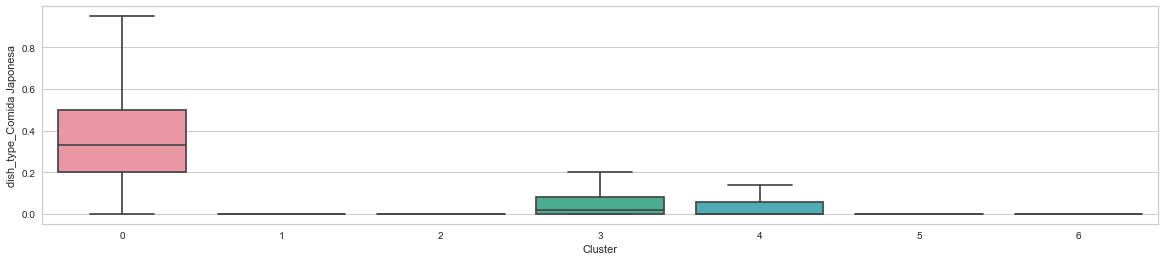

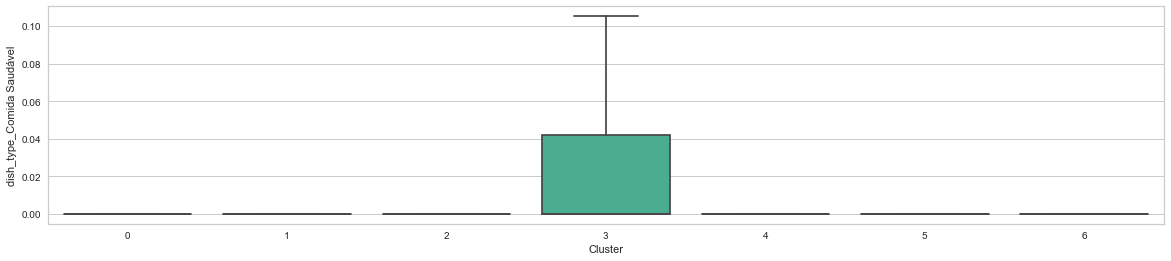

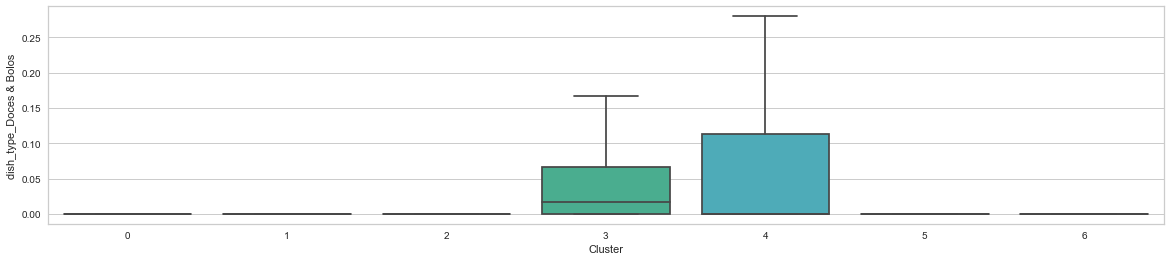

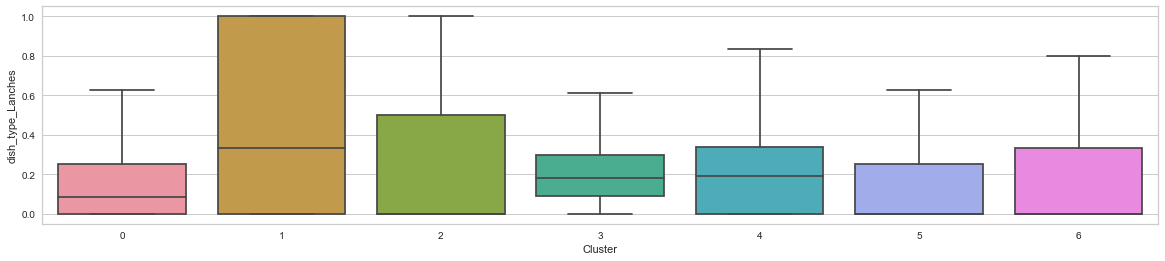

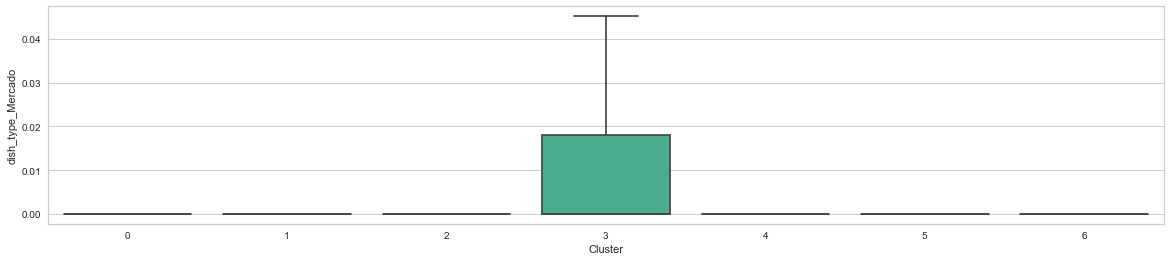

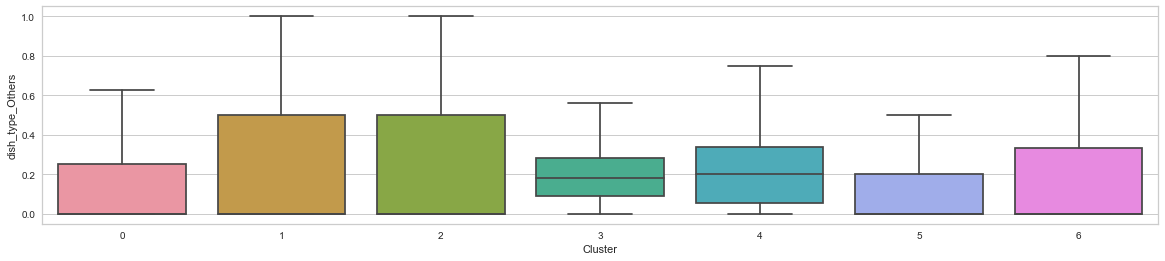

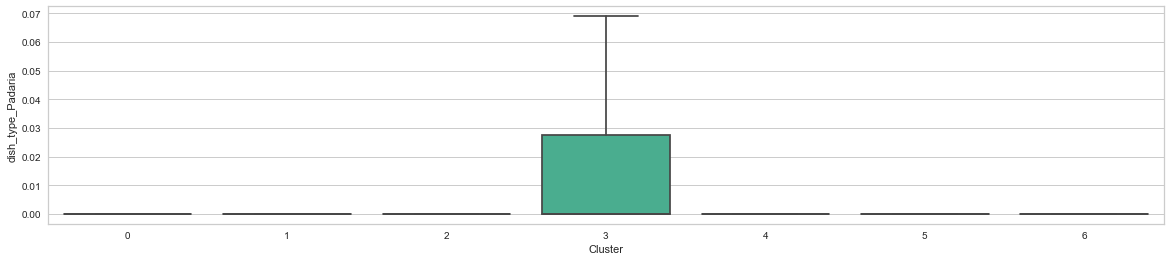

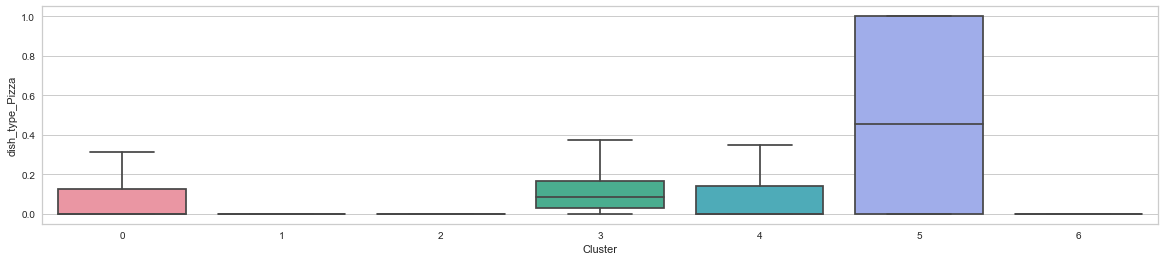

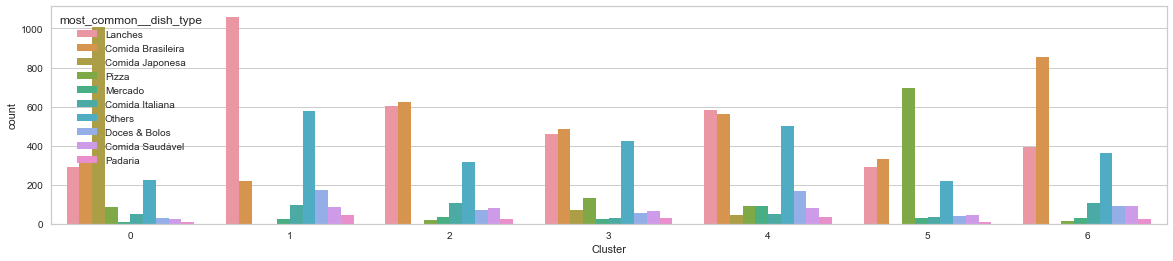

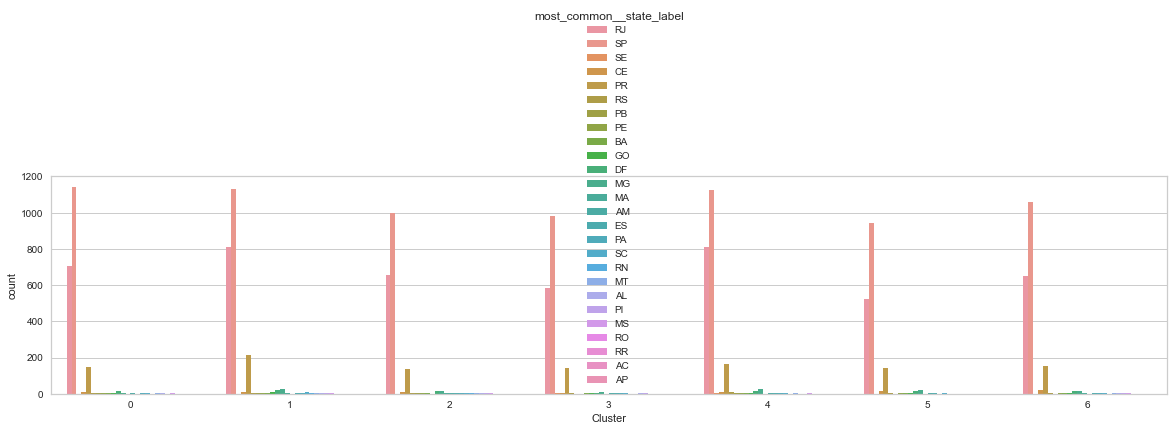

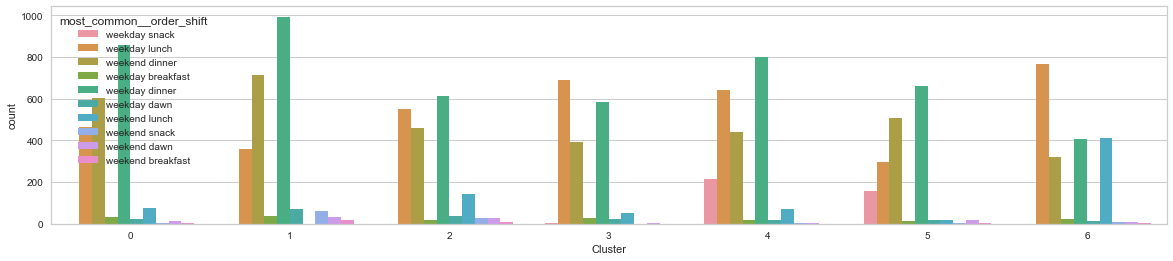

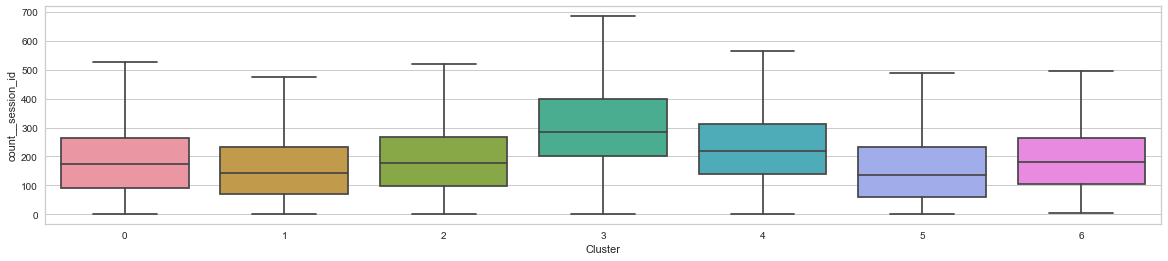

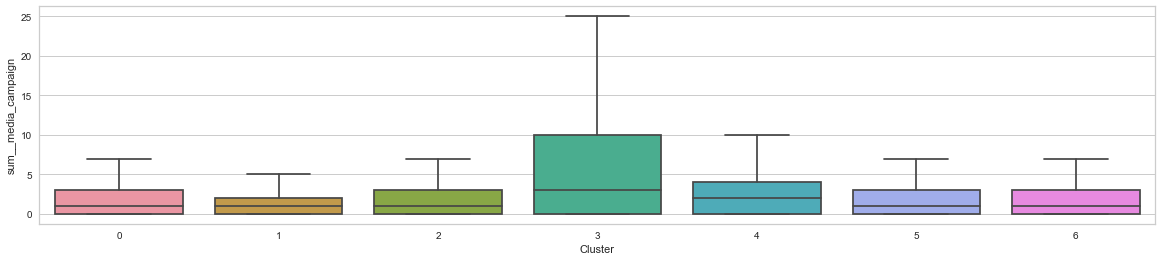

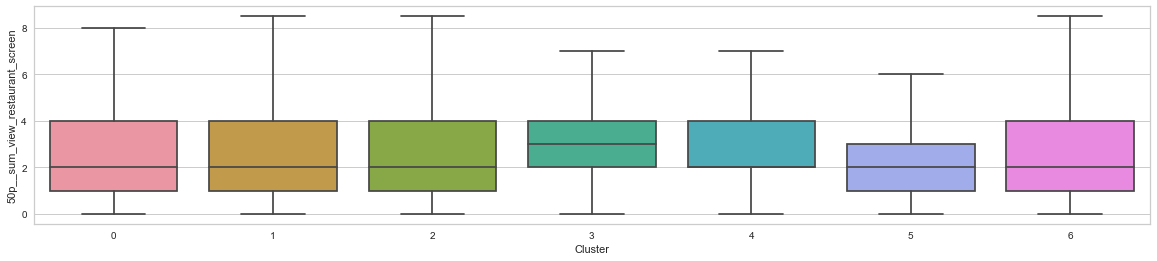

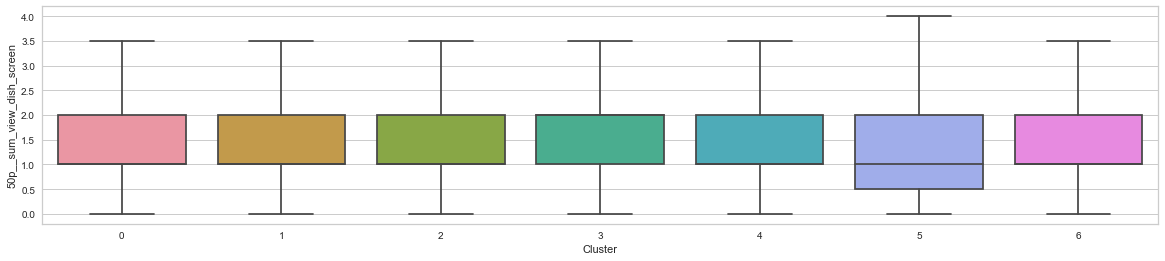

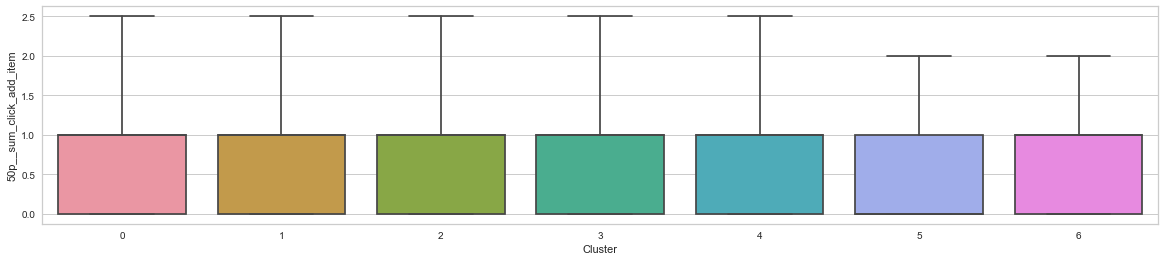

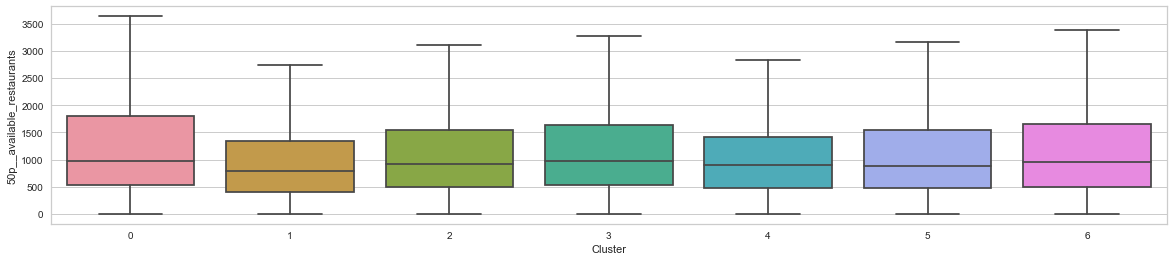

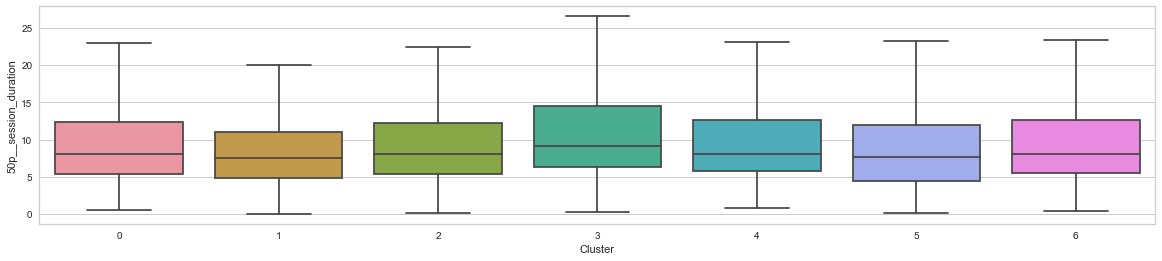

In [212]:
cluster_analysis = cluster_profile(df_final).T
cluster_analysis

## 11. Conclusão <a name="conclusao"></a>